 **KAGGLE CUSTOMER CHURN PREDICTION --2020**

###### 1、环境加载与数据加载

In [78]:
### 1.1、导入数据分析与建模所需的库
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import category_encoders as ce
from scipy.stats import chi2_contingency,randint, uniform
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix,roc_curve, precision_recall_curve, auc)
import lightgbm as lgb
import xgboost as xgb
import joblib

# 统一字体配置（避免重复设置）
plt.rcParams["font.family"] = ["SimHei", "Microsoft YaHei", "sans-serif"]
plt.rcParams['axes.unicode_minus'] = False

In [2]:
### 1.2、加载数据并查看基本信息
# 加载训练集
train_df = pd.read_csv(r"D:\pycharm\Customer_Churn_Prediction\churn_prediction_ipynb\train.csv")
# 查看原始数据
print("训练集前6行：")
display(train_df.head(6))
train_df.info()

训练集前6行：


,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,OH,107,area_code_415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,no
1,NJ,137,area_code_415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,no
2,OH,84,area_code_408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,no
3,OK,75,area_code_415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,no
4,MA,121,area_code_510,no,yes,24,218.2,88,37.09,348.5,108,29.62,212.6,118,9.57,7.5,7,2.03,3,no
5,MO,147,area_code_415,yes,no,0,157.0,79,26.69,103.1,94,8.76,211.8,96,9.53,7.1,6,1.92,0,no


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4250 entries, 0 to 4249
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   state                          4250 non-null   object 
 1   account_length                 4250 non-null   int64  
 2   area_code                      4250 non-null   object 
 3   international_plan             4250 non-null   object 
 4   voice_mail_plan                4250 non-null   object 
 5   number_vmail_messages          4250 non-null   int64  
 6   total_day_minutes              4250 non-null   float64
 7   total_day_calls                4250 non-null   int64  
 8   total_day_charge               4250 non-null   float64
 9   total_eve_minutes              4250 non-null   float64
 10  total_eve_calls                4250 non-null   int64  
 11  total_eve_charge               4250 non-null   float64
 12  total_night_minutes            4250 non-null   f

###### 2、数据清洗

In [3]:
# 2.1、检查缺失值
Missing_values_train = train_df.isnull().sum()
print(f'训练集缺失情况: {Missing_values_train}')

训练集缺失情况: state                            0
account_length                   0
area_code                        0
international_plan               0
voice_mail_plan                  0
number_vmail_messages            0
total_day_minutes                0
total_day_calls                  0
total_day_charge                 0
total_eve_minutes                0
total_eve_calls                  0
total_eve_charge                 0
total_night_minutes              0
total_night_calls                0
total_night_charge               0
total_intl_minutes               0
total_intl_calls                 0
total_intl_charge                0
number_customer_service_calls    0
churn                            0
dtype: int64


In [4]:
# 2.2、检查重复值
duplicate_count_train = train_df.duplicated().sum()
print(f"训练集重复行数量: {duplicate_count_train}")

训练集重复行数量: 0


In [5]:
# 2.3、检查异常值（数值型变量）
# 以数值型字段，用箱线图的IQR方法识别异常值，不做处理
total_outliers = 0
total_records = train_df.shape[0] * train_df.select_dtypes(include=['int64', 'float64']).shape[1]
for col in train_df.select_dtypes(include=['int64', 'float64']).columns:
    Q1 = train_df[col].quantile(0.25)
    Q3 = train_df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = train_df[(train_df[col] < lower_bound) | (train_df[col] > upper_bound)][col]
    total_outliers += outliers.shape[0]
    print(f'{col} 的异常值数量：{outliers.shape[0]}')
# 计算所有异常值占整体数据集的比例
outliers_ratio = total_outliers / total_records if total_records > 0 else 0
print(f'所有异常值占整体数据集的比例：{outliers_ratio * 100:.2f}%')

account_length 的异常值数量：20
number_vmail_messages 的异常值数量：86
total_day_minutes 的异常值数量：25
total_day_calls 的异常值数量：28
total_day_charge 的异常值数量：26
total_eve_minutes 的异常值数量：34
total_eve_calls 的异常值数量：24
total_eve_charge 的异常值数量：34
total_night_minutes 的异常值数量：37
total_night_calls 的异常值数量：33
total_night_charge 的异常值数量：37
total_intl_minutes 的异常值数量：62
total_intl_calls 的异常值数量：100
total_intl_charge 的异常值数量：62
number_customer_service_calls 的异常值数量：335
所有异常值占整体数据集的比例：1.48%


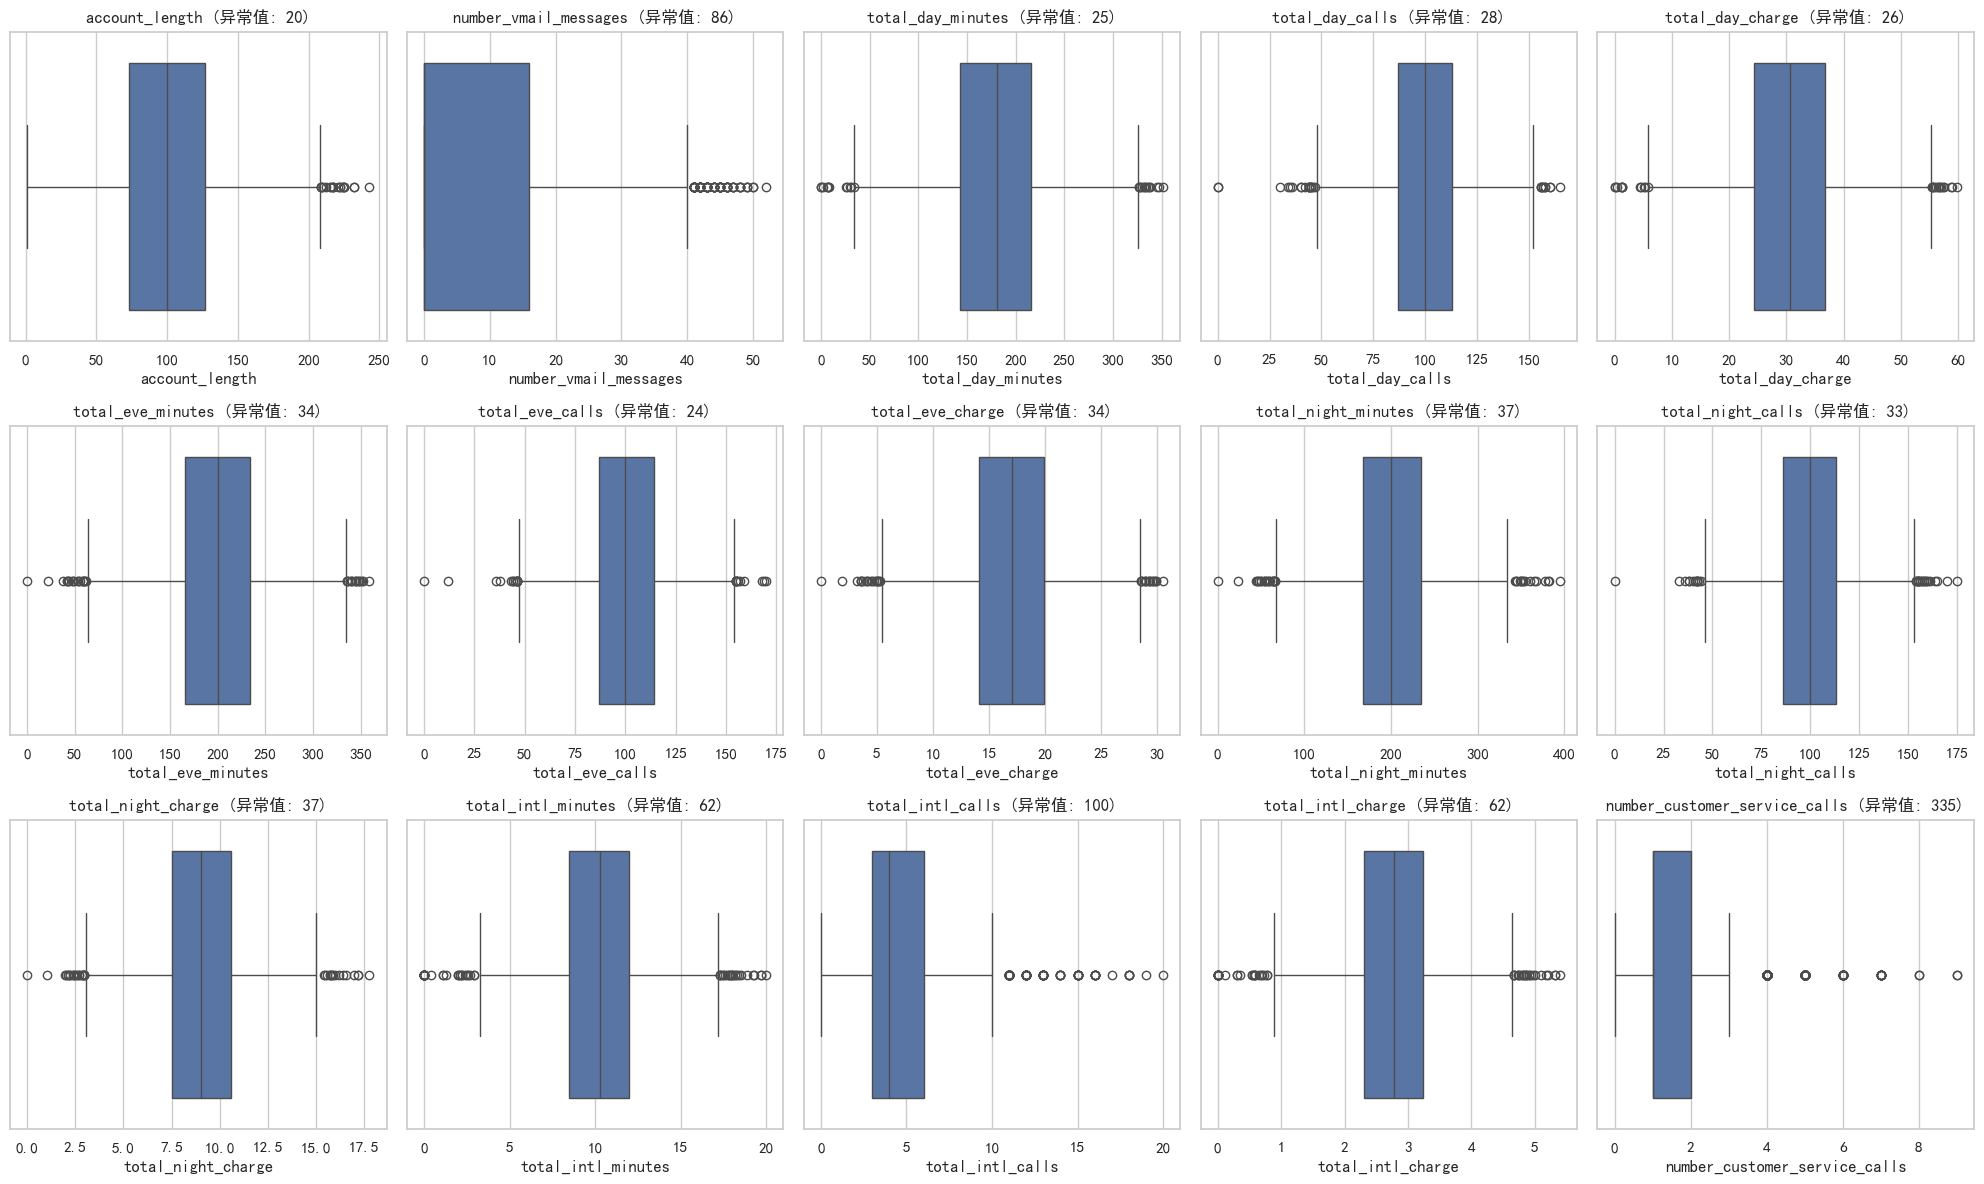

1、通过 IQR 方法分析了15个数值型变量，发现客服电话次数是主要异常值来源（335个），其次是国际通话次数（100 个）和各时段通话次数。整体数据质量良好，异常值比例仅 1.48%，无缺失值，无重复值。
2、在number_customer_service_calls（客服电话次数）方面，企业大客户或遇到复杂业务问题的客户频繁拨打客服是合理的，但这也可能是客户流失的重要预警信号，建议重点关注这部分客户
3、对于total_intl_minutes（国际通话分钟数）和total_intl_calls（国际通话次数），经常出国旅行、留学或从事跨境业务的人士有较多国际通话符合业务需求。
4、total_day_minutes等各时段通话相关变量，这些异常可能反映了特殊的客户行为模式，需要结合业务场景进一步分析。比如像出租车司机、快递员这类工作时间长且不固定的职业人群，各时段通话量高也属正常。


In [6]:
# 2.3.1 可视化数值特征异常值检测
sns.set(style="whitegrid")
plt.rcParams['font.sans-serif'] = ['SimHei']  # 解决中文显示问题
plt.rcParams['axes.unicode_minus'] = False    # 解决负号显示问题
# 选择所有数值型列
numeric_cols = train_df.select_dtypes(include=['int64','float64']).columns
# 计算画布布局（一行显示 5 个图）
n_cols = 5
n_rows = math.ceil(len(numeric_cols) / n_cols)
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 4 * n_rows))
# 循环绘制箱线图
for i, col in enumerate(numeric_cols):
    row = i // n_cols
    col_pos = i % n_cols
    # 计算IQR
    Q1 = train_df[col].quantile(0.25)
    Q3 = train_df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # 计算异常值数量
    outliers_count = len(train_df[(train_df[col] < lower_bound) | (train_df[col] > upper_bound)])
    # 绘制箱线图
    if n_rows == 1:
        sns.boxplot(x=train_df[col], ax=axes[col_pos])
        axes[col_pos].set_title(f"{col} (异常值: {outliers_count})")
    else:
        sns.boxplot(x=train_df[col], ax=axes[row, col_pos])
        axes[row, col_pos].set_title(f"{col} (异常值: {outliers_count})")

plt.tight_layout()
plt.show()

print("1、通过 IQR 方法分析了15个数值型变量，发现客服电话次数是主要异常值来源（335个），其次是国际通话次数（100 个）和各时段通话次数。整体数据质量良好，异常值比例仅 1.48%，无缺失值，无重复值。\n2、在number_customer_service_calls（客服电话次数）方面，企业大客户或遇到复杂业务问题的客户频繁拨打客服是合理的，但这也可能是客户流失的重要预警信号，建议重点关注这部分客户\n3、对于total_intl_minutes（国际通话分钟数）和total_intl_calls（国际通话次数），经常出国旅行、留学或从事跨境业务的人士有较多国际通话符合业务需求。\n4、total_day_minutes等各时段通话相关变量，这些异常可能反映了特殊的客户行为模式，需要结合业务场景进一步分析。比如像出租车司机、快递员这类工作时间长且不固定的职业人群，各时段通话量高也属正常。")

In [7]:
# 2.4 对分类变量进行频次统计
categorical_cols = train_df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    print(f'\nFrequency of {col}:')
    print(train_df[col].value_counts())
print("对5个分类型变量进行了频次统计，由统计结果可以看出无异常情况。 ")


Frequency of state:
state
WV    139
MN    108
ID    106
AL    101
VA    100
OR     99
TX     98
UT     97
NY     96
NJ     96
OH     95
WY     95
WI     94
MA     89
ME     89
CT     88
RI     87
KS     87
MI     87
VT     86
MD     86
KY     85
IN     83
NV     83
MS     82
WA     80
MO     80
CO     80
NC     80
MT     80
DE     80
IL     79
TN     79
NH     78
OK     78
NM     78
AZ     77
HI     77
FL     76
SD     75
NE     73
SC     72
DC     72
AR     71
LA     69
ND     67
PA     67
GA     64
IA     62
AK     61
CA     39
Name: count, dtype: int64

Frequency of area_code:
area_code
area_code_415    2108
area_code_408    1086
area_code_510    1056
Name: count, dtype: int64

Frequency of international_plan:
international_plan
no     3854
yes     396
Name: count, dtype: int64

Frequency of voice_mail_plan:
voice_mail_plan
no     3138
yes    1112
Name: count, dtype: int64

Frequency of churn:
churn
no     3652
yes     598
Name: count, dtype: int64
对5个分类型变量进行了频次统计，由统计结果可以看出无异常情况。 


###### 3、单变量探索性分析

In [8]:
# 3.1 国际套餐与流失率关系
# 数据验证
print("数据验证")
print(f"国际套餐取值: {train_df['international_plan'].unique()}")
print(f"流失状态取值: {train_df['churn'].unique()}")

# 检查必要列
required_columns = ['international_plan', 'churn']
missing_columns = [col for col in required_columns if col not in train_df.columns]
if missing_columns:
    raise ValueError(f"缺少必要列: {missing_columns}")

# 将 churn 转为数值型：yes=1, no=0
train_df['churn_num'] = train_df['churn'].str.lower().map({"yes": 1, "no": 0}).astype(int)

# 国际套餐与流失率统计分析
intl_churn = train_df.groupby('international_plan')['churn_num'].agg(
    [('客户总数', 'count'),
     ('流失客户数', 'sum'),
     ('流失率', 'mean')]
).round(3)

intl_churn['非流失客户数'] = intl_churn['客户总数'] - intl_churn['流失客户数']
intl_churn['流失占比'] = (intl_churn['流失客户数'] / intl_churn['流失客户数'].sum()).round(3)
print("统计差异分析:")
no_plan_data = train_df[train_df['international_plan'] == 'no']['churn_num']
yes_plan_data = train_df[train_df['international_plan'] == 'yes']['churn_num']
churn_rate_no = no_plan_data.mean()
churn_rate_yes = yes_plan_data.mean()

print(f"无国际套餐客户流失率: {churn_rate_no:.3f} ({churn_rate_no*100:.1f}%)")
print(f"有国际套餐客户流失率: {churn_rate_yes:.3f} ({churn_rate_yes*100:.1f}%)")
print(f"流失率绝对差异: {churn_rate_yes - churn_rate_no:.3f}")
print(f"流失率相对差异: {(churn_rate_yes - churn_rate_no) / churn_rate_no * 100:.1f}%")

数据验证
国际套餐取值: ['no' 'yes']
流失状态取值: ['no' 'yes']
统计差异分析:
无国际套餐客户流失率: 0.112 (11.2%)
有国际套餐客户流失率: 0.422 (42.2%)
流失率绝对差异: 0.310
流失率相对差异: 277.1%


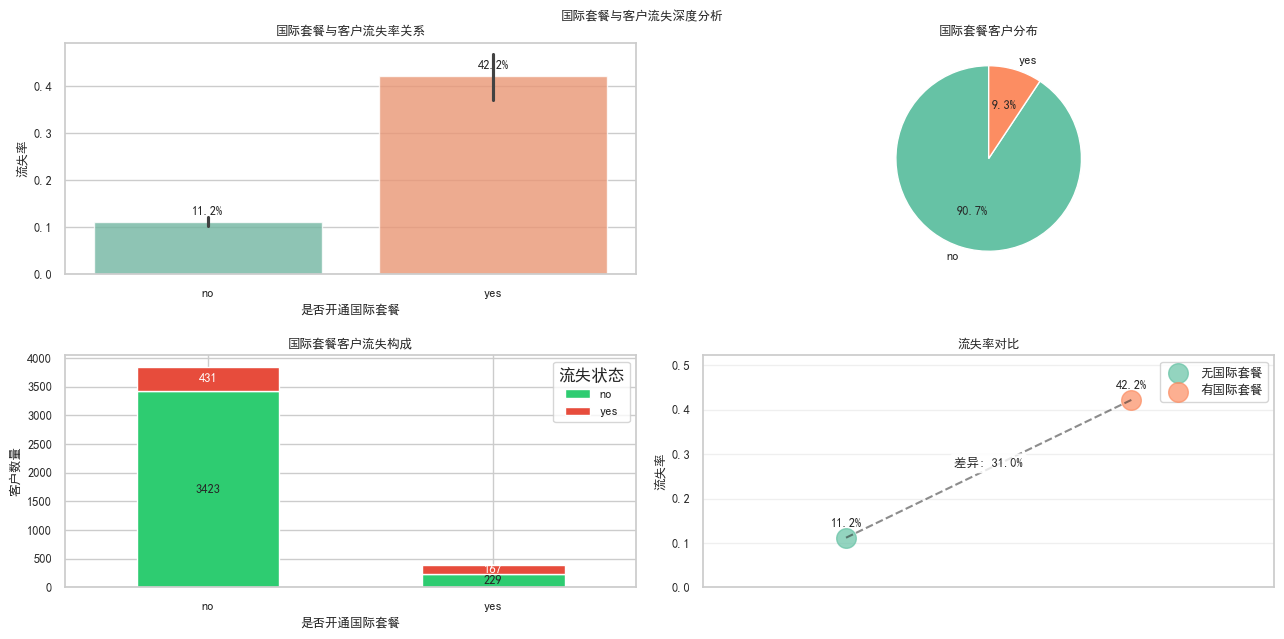

📌 国际套餐通常价格更高、服务复杂度更高（如国际漫游、跨国客服）。常见问题：国际服务体验差（如信号不稳定、通话中断）；国际费用争议（如漫游费超出预期、账单不清晰），客户开通后实际使用少（如出差需求结束后，觉得套餐性价比低）。这些问题会导致国际套餐用户的流失率显著高于普通用户，因此需要验证。
🚨 计算有/无国际套餐的客户分别对应的流失率，用可视化对比差异，确认国际套餐是否是流失风险因素。
💡 发现开通国际套餐的用户的流失率是无套餐客户的 3.8 倍，流失用户占开通国际套餐用户的42.2%，占全部流失客户的 27.9%。说明国际套餐是流失的高风险因素，后续建模需重点保留该特征。深度分析国际套餐的定价和服务质量，为国际套餐客户提供专属客户服务，对国际套餐客户进行满意度调研。


In [9]:
# 可视化国际套餐与流失率统计分析
fig, axes = plt.subplots(2, 2, figsize=(13, 6.5))
fig.suptitle('国际套餐与客户流失深度分析', fontsize=9, fontweight='bold')
# 流失率对比柱状图 （图1.1）
ax1 = axes[0, 0]
bar_plot = sns.barplot(
    x='international_plan',
    y='churn_num',
    hue='international_plan',
    data=train_df,
    palette=['#66c2a5', '#fc8d62'],
    alpha=0.8,
    ax=ax1,
    legend=False
)
ax1.set_title('国际套餐与客户流失率关系', fontsize=9, fontweight='bold')
ax1.set_xlabel('是否开通国际套餐', fontsize=9)
ax1.set_ylabel('流失率', fontsize=9)
ax1.tick_params(axis='both', labelsize=9)  # 坐标轴刻度标签
# 柱状图上标注流失率
for i, p in enumerate(bar_plot.patches):
    height = p.get_height()
    ax1.annotate(
        f'{height:.1%}',
        (p.get_x() + p.get_width()/2., height + 0.01),
        ha='center', va='bottom', fontsize=9, fontweight='bold'
    )

# 客户数量分布饼图 （图1.2）
ax2 = axes[0, 1]
plan_counts = train_df['international_plan'].value_counts()
colors = ['#66c2a5', '#fc8d62']
wedges, texts, autotexts = ax2.pie(
    plan_counts.values,
    labels=plan_counts.index,
    autopct='%1.1f%%',
    colors=colors,
    startangle=90,
    textprops={'fontsize': 9}  # 饼图内部文字
)
ax2.set_title('国际套餐客户分布', fontsize=9, fontweight='bold')

# 流失客户构成堆叠图 （图2.1）
ax3 = axes[1, 0]
churn_composition = pd.crosstab(train_df['international_plan'], train_df['churn'])
churn_composition.plot(kind='bar', stacked=True, color=['#2ecc71', '#e74c3c'], ax=ax3)
ax3.set_title('国际套餐客户流失构成', fontsize=9, fontweight='bold')
ax3.set_xlabel('是否开通国际套餐', fontsize=9)
ax3.set_ylabel('客户数量', fontsize=9)
ax3.legend(title='流失状态', loc='upper right', fontsize=9)  # 图例
ax3.tick_params(axis='x', rotation=0, labelsize=9)  # x轴刻度
ax3.tick_params(axis='y', labelsize=9)  # y轴刻度
# 堆叠图上标注客户数量
for i, (idx, row) in enumerate(churn_composition.iterrows()):
    total = row.sum()
    no_churn = row['no']
    yes_churn = row['yes']
    ax3.text(
        i, no_churn/2, f'{no_churn}',
        ha='center', va='center', fontweight='bold', fontsize=9
    )
    ax3.text(
        i, no_churn + yes_churn/2, f'{yes_churn}',
        ha='center', va='center', fontweight='bold', color='white', fontsize=9
    )

# 流失率对比点图 （图2.2）
ax4 = axes[1, 1]
plan_labels = ['无国际套餐', '有国际套餐']
churn_rates = [churn_rate_no, churn_rate_yes]

for i, (label, rate) in enumerate(zip(plan_labels, churn_rates)):
    ax4.scatter(i, rate, s=200, color=colors[i], alpha=0.7, label=label)
    ax4.text(
        i, rate + 0.02, f'{rate:.1%}',
        ha='center', va='bottom', fontsize=9, fontweight='bold'
    )
ax4.set_xlim(-0.5, 1.5)
ax4.set_ylim(0, max(churn_rates) + 0.1)
ax4.set_xticks([])
ax4.set_ylabel('流失率', fontsize=9)
ax4.set_title('流失率对比', fontsize=9, fontweight='bold')
ax4.legend(fontsize=9)  # 图例
ax4.grid(True, alpha=0.3)
ax4.tick_params(axis='y', labelsize=9)  # y轴刻度

# 标注流失率差异
ax4.plot([0, 1], churn_rates, 'k--', alpha=0.5)
ax4.text(
    0.5, (churn_rates[0] + churn_rates[1])/2,
    f'差异: {(churn_rates[1]-churn_rates[0]):.1%}',
    ha='center', va='bottom', fontsize=9,
    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8)
)

plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()

print("📌 国际套餐通常价格更高、服务复杂度更高（如国际漫游、跨国客服）。常见问题：国际服务体验差（如信号不稳定、通话中断）；国际费用争议（如漫游费超出预期、账单不清晰），客户开通后实际使用少（如出差需求结束后，觉得套餐性价比低）。这些问题会导致国际套餐用户的流失率显著高于普通用户，因此需要验证。")
print("🚨 计算有/无国际套餐的客户分别对应的流失率，用可视化对比差异，确认国际套餐是否是流失风险因素。")
print("💡 发现开通国际套餐的用户的流失率是无套餐客户的 3.8 倍，流失用户占开通国际套餐用户的42.2%，占全部流失客户的 27.9%。说明国际套餐是流失的高风险因素，后续建模需重点保留该特征。深度分析国际套餐的定价和服务质量，为国际套餐客户提供专属客户服务，对国际套餐客户进行满意度调研。")

In [10]:
# 3.2 客服呼叫次数与客户流失率的关系
# 统计：按客服呼叫次数分组，计算流失率
service_churn = train_df.groupby('number_customer_service_calls')['churn_num'].agg(['count', 'sum', 'mean'])
service_churn.columns = ['客户总数', '流失客户数', '流失率']
service_churn['流失率'] = service_churn['流失率'].round(3)
print("\n客服呼叫次数与流失率关联：")
print(service_churn)


客服呼叫次数与流失率关联：
                               客户总数  流失客户数    流失率
number_customer_service_calls                    
0                               886     97  0.109
1                              1524    166  0.109
2                               947    102  0.108
3                               558     63  0.113
4                               209     92  0.440
5                                81     49  0.605
6                                28     19  0.679
7                                13      7  0.538
8                                 2      1  0.500
9                                 2      2  1.000


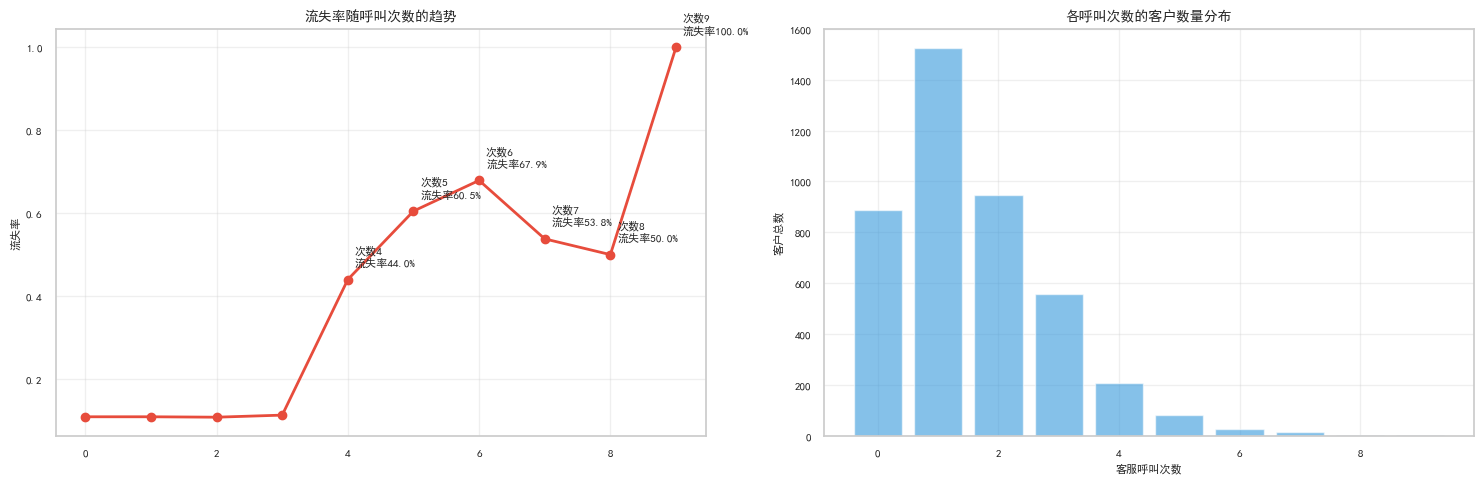

📌 呼叫次数越多，说明客户遇到的问题越多,多次呼叫后问题仍未解决，会加剧客户不满，最终导致流失.因此，需要验证呼叫次数与流失率的正相关关系，并找到关键阈值。按照客服呼叫次数进行分组，计算每组流失率，用可视化对比差异，确认风险阈值。
📌 由左图流失率趋势可以看出：当呼叫次数<=3,流失率稳定在15%以内；当呼叫次数 ≥ 4 时，流失率突然跃升至 44.0%，且随次数增加持续走高（次数 5：60.5%；次数 6：67.9%；次数 9：100%）。再通过右图可以看出，大多数客户的呼叫次数集中在 0-3 次，而 ≥4 次 的客户数量快速减少，说明高呼叫次数且高流失的客户是小比例但高价值的风险群体。
💡 业务上可将 “呼叫次数≥4” 作为高流失风险的标记条件，纳入客户分群体系。


In [11]:
# 可视化客服呼叫次数与流失率关联
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharex=False)

# 左图：流失率趋势（折线图）
ax1.plot(service_churn.index, service_churn['流失率'], marker='o', linewidth=2, color='#e74c3c')
ax1.set_ylabel('流失率', fontsize=8)  # 轴标签字体
ax1.set_title('流失率随呼叫次数的趋势', fontsize=10)  # 标题字体
ax1.tick_params(axis='both', labelsize=8)  # 刻度字体
ax1.grid(alpha=0.3)

# 标注高风险点
high_risk_calls = service_churn[service_churn['流失率'] > 0.3].index
for call_num in high_risk_calls:
    ax1.annotate(
        f'次数{call_num}\n流失率{service_churn["流失率"].loc[call_num]:.1%}',
        (call_num, service_churn['流失率'].loc[call_num]),
        xytext=(5, 10),
        textcoords='offset points',
        fontsize=8  # 标注字体
    )

# 右图：每组客户数量（柱状图）
ax2.bar(service_churn.index, service_churn['客户总数'], alpha=0.6, color='#3498db')
ax2.set_xlabel('客服呼叫次数', fontsize=8)
ax2.set_ylabel('客户总数', fontsize=8)
ax2.set_title('各呼叫次数的客户数量分布', fontsize=10)
ax2.tick_params(axis='both', labelsize=8)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("📌 呼叫次数越多，说明客户遇到的问题越多,多次呼叫后问题仍未解决，会加剧客户不满，最终导致流失.因此，需要验证呼叫次数与流失率的正相关关系，并找到关键阈值。按照客服呼叫次数进行分组，计算每组流失率，用可视化对比差异，确认风险阈值。")
print("📌 由左图流失率趋势可以看出：当呼叫次数<=3,流失率稳定在15%以内；当呼叫次数 ≥ 4 时，流失率突然跃升至 44.0%，且随次数增加持续走高（次数 5：60.5%；次数 6：67.9%；次数 9：100%）。再通过右图可以看出，大多数客户的呼叫次数集中在 0-3 次，而 ≥4 次 的客户数量快速减少，说明高呼叫次数且高流失的客户是小比例但高价值的风险群体。")
print("💡 业务上可将 “呼叫次数≥4” 作为高流失风险的标记条件，纳入客户分群体系。")

In [12]:
# 3.3 通话时长分析
# 选择通话时长字段
duration_cols = ['total_day_minutes','total_eve_minutes','total_night_minutes','total_intl_minutes']
# 通话时长基本统计量
# count(样本数)、平均值（mean）、标准差（std）、最小值（min）、25%、50%、75% 分位数 、最大值（max）
print("通话时长字段基本统计：")
print(train_df[duration_cols].describe())

通话时长字段基本统计：
       total_day_minutes  total_eve_minutes  total_night_minutes  \
count        4250.000000        4250.000000          4250.000000   
mean          180.259600         200.173906           200.527882   
std            54.012373          50.249518            50.353548   
min             0.000000           0.000000             0.000000   
25%           143.325000         165.925000           167.225000   
50%           180.450000         200.700000           200.450000   
75%           216.200000         233.775000           234.700000   
max           351.500000         359.300000           395.000000   

       total_intl_minutes  
count         4250.000000  
mean            10.256071  
std              2.760102  
min              0.000000  
25%              8.500000  
50%             10.300000  
75%             12.000000  
max             20.000000  


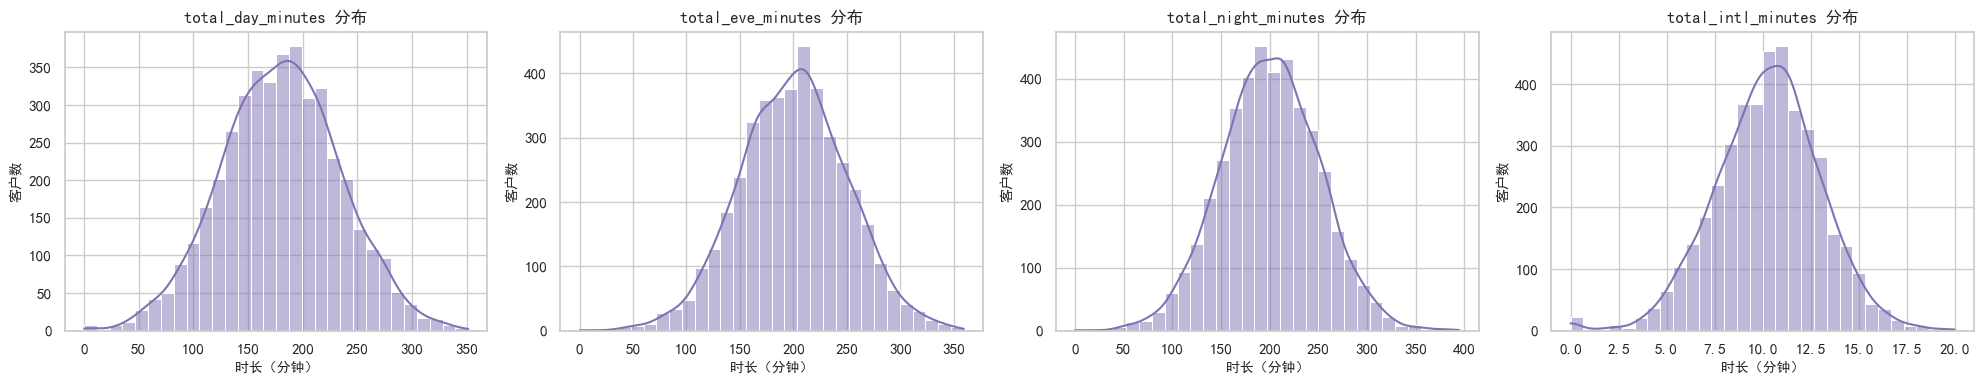

In [13]:
# 各时段通话时长分布（直方图+核密度图）
plt.figure(figsize=(20, 4))
for i, col in enumerate(duration_cols):
    plt.subplot(1, 4, i+1)
    sns.histplot(train_df[col], kde=True, color='m', bins=30)
    plt.title(f'{col} 分布', fontsize=12)
    plt.xlabel('时长（分钟）', fontsize=10)
    plt.ylabel('客户数', fontsize=10)
plt.tight_layout()
plt.show()

In [14]:
# 通话时长与流失率的关系（分箱分析）
# 对各时长字段进行分箱,参考费用分箱逻辑，按分布特征分箱
# 分箱规则设计基于分位数和分布特征
# 核心逻辑：
# 日间/国际时长：用qcut（四分位），因分布相对均匀，样本量均衡
# 晚间/夜间时长：用自定义分箱（基于25%/75%分位数），适配中段集中的特征
duration_bin_rules = {
    # 日间时长：四分位分箱（0-143.3→143.3-180.5→180.5-216.2→216.2+）
    'total_day_minutes': pd.qcut(
        train_df['total_day_minutes'],
        q=4,
        labels=['day时长_低(0-143)', 'day时长_中低(143-180)', 'day时长_中高(180-216)', 'day时长_高(216+)'],
        duplicates='drop'  # 处理可能的重复分位数
    ),
    # 晚间时长：三分位分箱（0-165.9→165.9-233.8→233.8+）
    'total_eve_minutes': pd.qcut(
        train_df['total_eve_minutes'],
        q=3,
        labels=['eve时长_低(0-166)', 'eve时长_中(166-234)', 'eve时长_高(234+)'],
        duplicates='drop'
    ),
    # 夜间时长：自定义分箱（基于25%/75%分位数，0-167.2→167.2-234.7→234.7+）
    'total_night_minutes': pd.cut(
        train_df['total_night_minutes'],
        bins=[0, 167.2, 234.7, float('inf')],
        labels=['night时长_低(0-167)', 'night时长_中(167-235)', 'night时长_高(235+)']
    ),
    # 国际时长：四分位分箱（0-8.5→8.5-10.3→10.3-12.0→12.0+），捕捉高国际通话用户
    'total_intl_minutes': pd.qcut(
        train_df['total_intl_minutes'],
        q=4,
        labels=['intl时长_低(0-8.5)', 'intl时长_中低(8.5-10.3)', 'intl时长_中高(10.3-12.0)', 'intl时长_高(12.0+)'],
        duplicates='drop'
    )
}
# 添加分箱列（原字段名+"_bin"）
for col, bin_series in duration_bin_rules.items():
    train_df[f'{col}_bin'] = bin_series

print("\n分箱后各组样本量：")
for col in duration_cols:
    bin_col = f'{col}_bin'
    print(f"\n{col} 分箱样本量：")
    print(train_df[bin_col].value_counts().sort_index())


分箱后各组样本量：

total_day_minutes 分箱样本量：
total_day_minutes_bin
day时长_低(0-143)       1063
day时长_中低(143-180)    1062
day时长_中高(180-216)    1063
day时长_高(216+)        1062
Name: count, dtype: int64

total_eve_minutes 分箱样本量：
total_eve_minutes_bin
eve时长_低(0-166)      1418
eve时长_中(166-234)    1415
eve时长_高(234+)       1417
Name: count, dtype: int64

total_night_minutes 分箱样本量：
total_night_minutes_bin
night时长_低(0-167)      1062
night时长_中(167-235)    2128
night时长_高(235+)       1059
Name: count, dtype: int64

total_intl_minutes 分箱样本量：
total_intl_minutes_bin
intl时长_低(0-8.5)         1077
intl时长_中低(8.5-10.3)     1051
intl时长_中高(10.3-12.0)    1068
intl时长_高(12.0+)         1054
Name: count, dtype: int64


In [15]:
# 计算各分箱的流失率（用于验证分箱有效性）
duration_churn_result = {}
for col in duration_cols:
    bin_col = f'{col}_bin'
    # 计算每组客户数、流失数、流失率
    churn_stats = train_df.groupby(bin_col, observed=True)['churn_num'].agg(
        客户数='count',
        流失数='sum',
        流失率=lambda x: x.mean().round(2)  # 保留4位小数
    ).reset_index()
    duration_churn_result[col] = churn_stats

    print(f"\n{col} 分箱流失率统计：")
    display(churn_stats)


total_day_minutes 分箱流失率统计：


,total_day_minutes_bin,客户数,流失数,流失率
0,day时长_低(0-143),1063,129,0.12
1,day时长_中低(143-180),1062,97,0.09
2,day时长_中高(180-216),1063,66,0.06
3,day时长_高(216+),1062,306,0.29



total_eve_minutes 分箱流失率统计：


,total_eve_minutes_bin,客户数,流失数,流失率
0,eve时长_低(0-166),1418,167,0.12
1,eve时长_中(166-234),1415,189,0.13
2,eve时长_高(234+),1417,242,0.17



total_night_minutes 分箱流失率统计：


,total_night_minutes_bin,客户数,流失数,流失率
0,night时长_低(0-167),1062,123,0.12
1,night时长_中(167-235),2128,303,0.14
2,night时长_高(235+),1059,172,0.16



total_intl_minutes 分箱流失率统计：


,total_intl_minutes_bin,客户数,流失数,流失率
0,intl时长_低(0-8.5),1077,134,0.12
1,intl时长_中低(8.5-10.3),1051,143,0.14
2,intl时长_中高(10.3-12.0),1068,139,0.13
3,intl时长_高(12.0+),1054,182,0.17


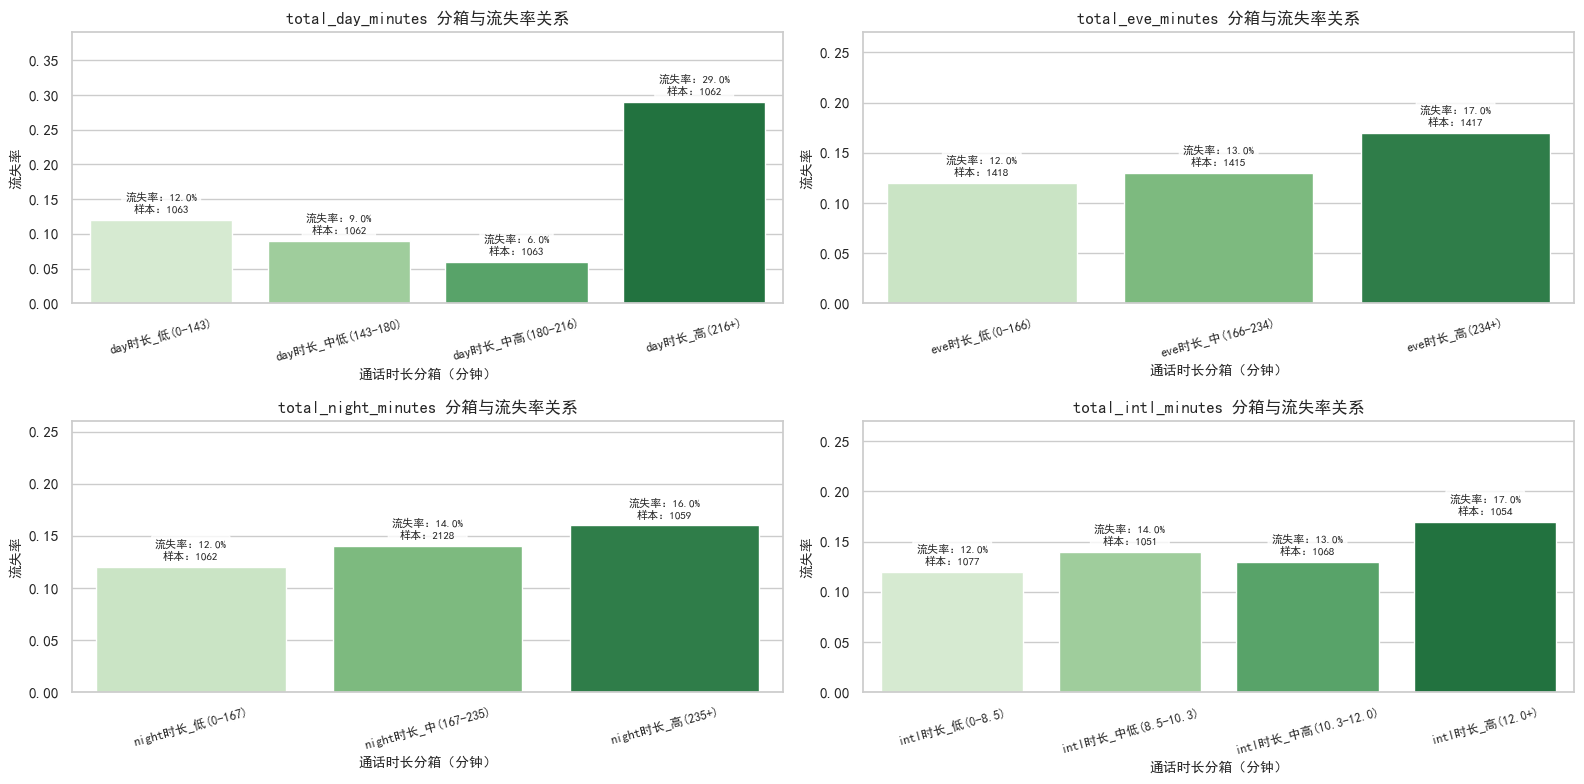

📌 通话时长分箱结论：
1. 日间高时长（216+分钟）客户流失率显著高于其他组，验证了高日间使用用户的流失风险；
2. 国际高时长（12+分钟）客户流失率随时长增加明显上升，与国际套餐高流失率特征呼应；
3. 晚间/夜间时长对流失率的影响较平缓，但高时长组仍略高于低时长组，说明全时段使用强度均与流失相关。


In [16]:
# 3.3.5、可视化分箱与流失率关系
fig, axes = plt.subplots(2, 2, figsize=(16, 8))
axes = axes.flatten()  # 转为一维数组，方便循环

for i, col in enumerate(duration_cols):
    bin_col = f'{col}_bin'
    stats = duration_churn_result[col]

    # 绘制流失率柱状图
    sns.barplot(
        x=bin_col,
        y='流失率',
        data=stats,
        hue=bin_col,
        palette='Greens',
        legend=False,
        ax=axes[i]
    )

    axes[i].set_title(f'{col} 分箱与流失率关系', fontsize=12)
    axes[i].set_xlabel('通话时长分箱（分钟）', fontsize=10)
    axes[i].set_ylabel('流失率', fontsize=10)
    axes[i].tick_params(axis='x', rotation=15, labelsize=9)
    axes[i].set_ylim(0, max(stats['流失率']) + 0.1)  # 预留标注空间

    # 标注流失率和样本量
    for j, row in stats.iterrows():
        axes[i].annotate(
            f'流失率：{row["流失率"]:.1%}\n样本：{row["客户数"]}',
            xy=(j, row["流失率"]),
            xytext=(0, 5),
            textcoords='offset points',
            ha='center',
            fontsize=8,
            bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.8)
        )

plt.tight_layout()
plt.show()

# 7. 分箱结论
print("📌 通话时长分箱结论：")
print("1. 日间高时长（216+分钟）客户流失率显著高于其他组，验证了高日间使用用户的流失风险；")
print("2. 国际高时长（12+分钟）客户流失率随时长增加明显上升，与国际套餐高流失率特征呼应；")
print("3. 晚间/夜间时长对流失率的影响较平缓，但高时长组仍略高于低时长组，说明全时段使用强度均与流失相关。")

In [17]:
# 3.4、对通话费用进行分析（分时段）
# total_day_charge：白天通话费用  total_eve_charge：晚间通话费用  total_night_charge：夜间通话费用 total_intl_charge：国际通话费用
# 分时段费用分析看客户的消费结构，客户在不同场景（时段）的消费习惯如何影响流失，但客户的流失决策往往不只是单一时段的影响，还会受整体消费规模的影响：
# 总费用分析客户的整体消费规模（总投入）如何影响流失风险
# count(样本数)、平均值（mean）、标准差（std）、最小值（min）、25%、50%、75% 分位数 、最大值（max）
#3.4.1、查看费用字段基本统计量
# 选择费用字段
charge_cols = [
    'total_day_charge',
    'total_eve_charge',
    'total_night_charge',
    'total_intl_charge'
]
print(" 费用字段基本统计：")
print(train_df[charge_cols].describe())

 费用字段基本统计：
       total_day_charge  total_eve_charge  total_night_charge  \
count       4250.000000       4250.000000         4250.000000   
mean          30.644682         17.015012            9.023892   
std            9.182096          4.271212            2.265922   
min            0.000000          0.000000            0.000000   
25%           24.365000         14.102500            7.522500   
50%           30.680000         17.060000            9.020000   
75%           36.750000         19.867500           10.560000   
max           59.760000         30.540000           17.770000   

       total_intl_charge  
count        4250.000000  
mean            2.769654  
std             0.745204  
min             0.000000  
25%             2.300000  
50%             2.780000  
75%             3.240000  
max             5.400000  


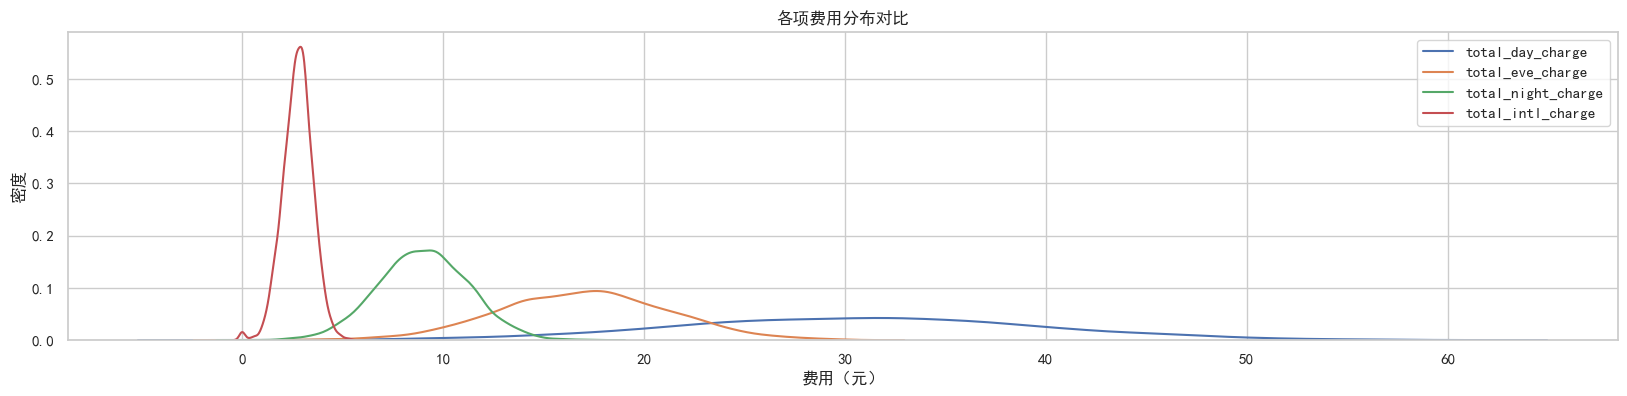

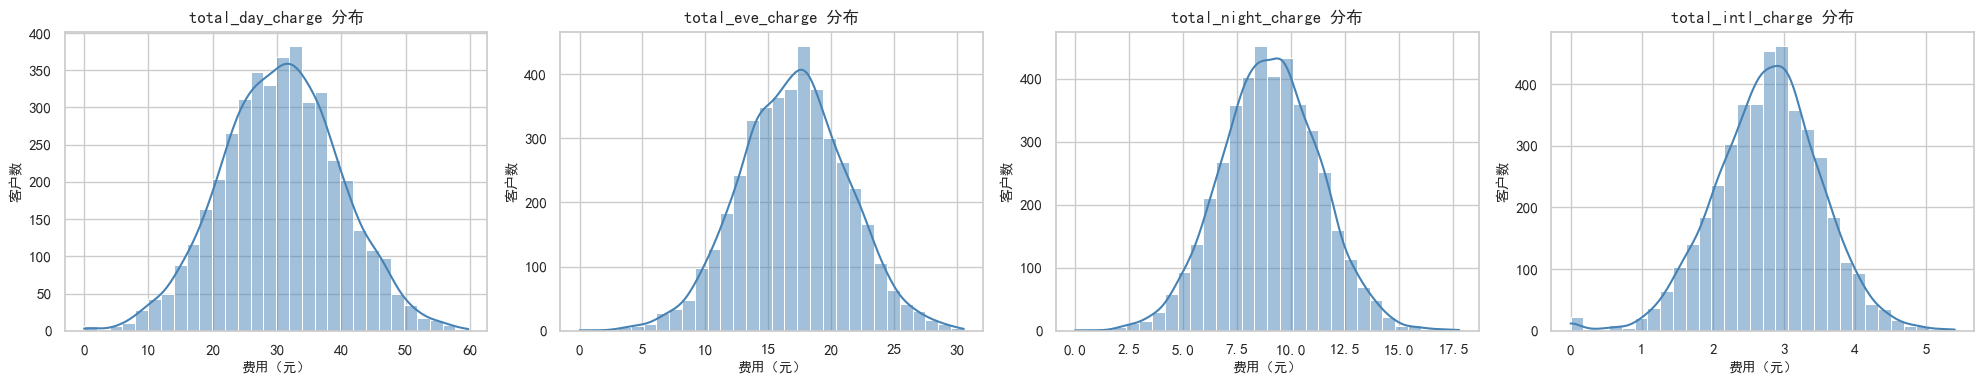

📌 直方图解读：观察各费用分布形态，白天费用通常右偏，国际费用绝对值小但可能有极端值。
📌 因为大部分数值集中左侧（低费用），右侧有一条长长的尾巴（少数客户费用很高因为大部分客户的白天通话量稳定在中等水平，只有少数客户（如商务人士、客服中心）通话量极大，导致费用很高。
📌 国际费用绝对值小但可能有极端值业务原因,大多数客户很少打国际电话，所以国际费用普遍很低；但少数有国际业务、留学、外派的客户会产生高额国际通话费，形成极端值。这些极端值可能会拉高均值，影响模型对正常区间的判断，所以需要单独分析或处理。


In [18]:
# 3.4.2、可视化各时段费用分布
# 查看各项费用整体分布的平滑曲线图
plt.figure(figsize=(20,4))
for col in charge_cols:
    sns.kdeplot(train_df[col], label=col)
plt.title('各项费用分布对比')
plt.xlabel('费用（元）')
plt.ylabel('密度')
plt.legend()

# 查看四个费用字段的直方图
plt.figure(figsize=(20, 4))
for i, col in enumerate(charge_cols):
    plt.subplot(1, 4, i+1)
    sns.histplot(train_df[col], kde=True, color='steelblue', bins=30)
    plt.title(f'{col} 分布', fontsize=12)
    plt.xlabel('费用（元）', fontsize=10)
    plt.ylabel('客户数', fontsize=10)

plt.tight_layout()
plt.show()

print("📌 直方图解读：观察各费用分布形态，白天费用通常右偏，国际费用绝对值小但可能有极端值。")
print("📌 因为大部分数值集中左侧（低费用），右侧有一条长长的尾巴（少数客户费用很高因为大部分客户的白天通话量稳定在中等水平，只有少数客户（如商务人士、客服中心）通话量极大，导致费用很高。")
print("📌 国际费用绝对值小但可能有极端值业务原因,大多数客户很少打国际电话，所以国际费用普遍很低；但少数有国际业务、留学、外派的客户会产生高额国际通话费，形成极端值。这些极端值可能会拉高均值，影响模型对正常区间的判断，所以需要单独分析或处理。")


 费用字段相关性分析：


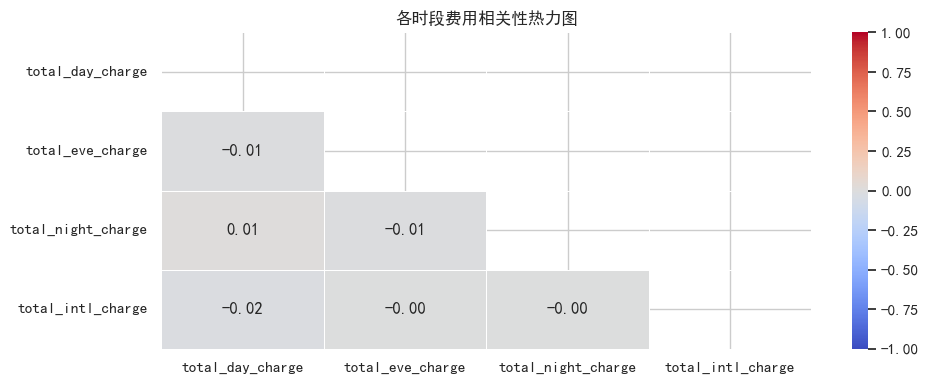

📌 费用相关性分析：
 - 所有相关系数均在 [-0.02, 0.01] 之间，符合相关系数的取值范围 [-1, 1]，四个费用字段之间的相关性几乎为 0（系数绝对值≤0.02），说明客户在白天的通话费用高低，与晚间、夜间、国际通话费用的高低几乎不存在线性关联。
 - 反映出客户的通话习惯具有时段独立性，后续分析中可基于这一特征，对各时段费用进行独立的流失风险评估，无需考虑某一时段费用高会带动其他时段费用高的联动效应


In [19]:
# 3.4.3、费用字段间的相关性分析（热力图）
print("\n 费用字段相关性分析：")
charge_corr = train_df[charge_cols].corr()

plt.figure(figsize=(10, 4))
mask = np.triu(np.ones_like(charge_corr, dtype=bool))  # 隐藏上三角
sns.heatmap(
    charge_corr,
    mask=mask,
    annot=True,  # 显示相关系数值
    cmap='coolwarm',
    vmin=-1, vmax=1,
    fmt='.2f',
    linewidths=0.5
)
plt.title('各时段费用相关性热力图')
plt.tight_layout()
plt.show()

print("📌 费用相关性分析：")
print(" - 所有相关系数均在 [-0.02, 0.01] 之间，符合相关系数的取值范围 [-1, 1]，四个费用字段之间的相关性几乎为 0（系数绝对值≤0.02），说明客户在白天的通话费用高低，与晚间、夜间、国际通话费用的高低几乎不存在线性关联。")
print(" - 反映出客户的通话习惯具有时段独立性，后续分析中可基于这一特征，对各时段费用进行独立的流失风险评估，无需考虑某一时段费用高会带动其他时段费用高的联动效应")

In [20]:
# 3.4.4、根据观察各费用分布形态，进行四分位分箱（qcut）
# 分布定分箱，右偏用 qcut，集中自定义，减少冗余分组。
bin_rules = {
    # day_charge右偏→qcut4组；标签含具体区间，方便后续解读
    'total_day_charge': pd.qcut(train_df['total_day_charge'], q=4, labels=['day_低(0-17)', 'day_中低(17-26)', 'day_中高(26-36)', 'day_高(36+)']),
    # eve_charge偏态平缓→qcut3组
    'total_eve_charge': pd.qcut(train_df['total_eve_charge'], q=3, labels=['eve_低(0-11)', 'eve_中(11-17)', 'eve_高(17+)']),
    # night_charge集中→自定义3组（按中位数拆分）
    'total_night_charge': pd.cut(train_df['total_night_charge'], bins=[0, 8, 11, 20], labels=['night_低(0-8)', 'night_中(8-11)', 'night_高(11+)']),
    # intl_charge右偏→qcut4组
    'total_intl_charge': pd.qcut(train_df['total_intl_charge'], q=4, labels=['intl_低(0-2.7)', 'intl_中低(2.7-4.0)', 'intl_中高(4.0-5.4)', 'intl_高(5.4+)'])
}
# 批量添加分箱列（列名：原字段名+"_bin"）
for col, bin_series in bin_rules.items():
    train_df[f'{col}_bin'] = bin_series

# 查看分箱后每组的样本量（验证是否均匀）
print("分箱后各组样本量：")
for col in charge_cols:
    bin_col = f'{col}_bin'
    print(f"\n{col} 分箱样本量：")
    print(train_df[bin_col].value_counts().sort_index())

分箱后各组样本量：

total_day_charge 分箱样本量：
total_day_charge_bin
day_低(0-17)      1063
day_中低(17-26)    1062
day_中高(26-36)    1063
day_高(36+)       1062
Name: count, dtype: int64

total_eve_charge 分箱样本量：
total_eve_charge_bin
eve_低(0-11)     1418
eve_中(11-17)    1415
eve_高(17+)      1417
Name: count, dtype: int64

total_night_charge 分箱样本量：
total_night_charge_bin
night_低(0-8)     1380
night_中(8-11)    2050
night_高(11+)      819
Name: count, dtype: int64

total_intl_charge 分箱样本量：
total_intl_charge_bin
intl_低(0-2.7)       1077
intl_中低(2.7-4.0)    1051
intl_中高(4.0-5.4)    1068
intl_高(5.4+)        1054
Name: count, dtype: int64


In [21]:
# 3.4.5、批量计算每个分箱的流失率
charge_churn_result = {}

for col in charge_cols:
    bin_col = f'{col}_bin'
    churn_stats = train_df.groupby(bin_col, observed=True)['churn_num'].agg(
        客户数='count',  # 每组样本量
        流失数='sum',    # 流失客户数
        流失率='mean'    # 流失率
    ).round({'流失率': 3})
    churn_stats['未流失数'] = churn_stats['客户数']-churn_stats['流失数']
    churn_stats['流失率'] = (churn_stats['流失数'] / churn_stats['客户数']).round(4)
    churn_stats = churn_stats[['客户数','未流失数', '流失数', '流失率']]

    charge_churn_result[col] = churn_stats

    print(churn_stats)

 # 卡方检验
    contingency = pd.crosstab(train_df[bin_col], train_df['churn_num'])
    chi2, p, _, _ = chi2_contingency(contingency)

    significant = "显著" if p < 0.05 else "不显著"
    print(f"{col}：卡方值={chi2:.2f}，p值={p:.4f}（{significant}）")
    print(f"结论：{col}的费用水平与客户流失存在{significant}关联\n")

                       客户数  未流失数  流失数     流失率
total_day_charge_bin                         
day_低(0-17)           1063   934  129  0.1214
day_中低(17-26)         1062   965   97  0.0913
day_中高(26-36)         1063   997   66  0.0621
day_高(36+)            1062   756  306  0.2881
total_day_charge：卡方值=269.96，p值=0.0000（显著）
结论：total_day_charge的费用水平与客户流失存在显著关联

                       客户数  未流失数  流失数     流失率
total_eve_charge_bin                         
eve_低(0-11)           1418  1251  167  0.1178
eve_中(11-17)          1415  1226  189  0.1336
eve_高(17+)            1417  1175  242  0.1708
total_eve_charge：卡方值=17.37，p值=0.0002（显著）
结论：total_eve_charge的费用水平与客户流失存在显著关联

                         客户数  未流失数  流失数     流失率
total_night_charge_bin                         
night_低(0-8)            1380  1212  168  0.1217
night_中(8-11)           2050  1756  294  0.1434
night_高(11+)             819   683  136  0.1661
total_night_charge：卡方值=8.58，p值=0.0137（显著）
结论：total_night_charge的费用水平与客户流失存在显著关联

                

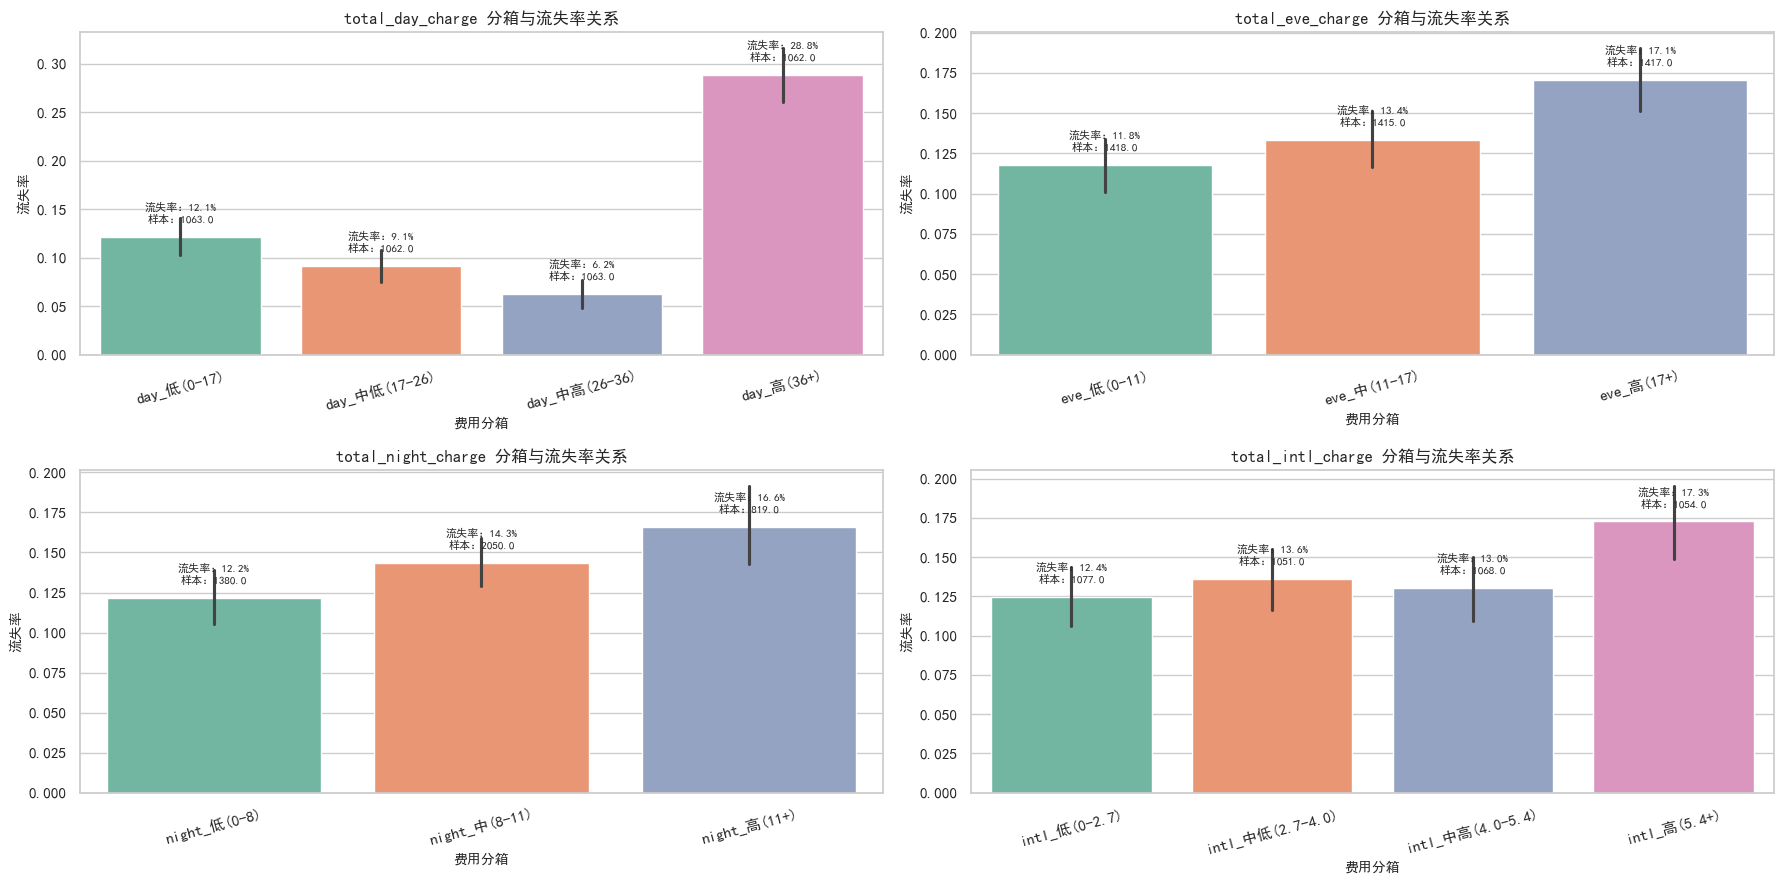

结合直方图分箱后的流失率数据和电信业务背景:
📌 日间通话费用（total_day_charge）：分箱后流失率趋势低(0-17)（12.1%）→中低(17-26)（9.1%）→中高(26-36)（6.2%）→ 高(36+)（28.8%）。日间是核心通话时段（工作、生活沟通的主要场景），客户对日间费用的成本与价值感知最敏感。高日间费用（36 元以上）的客户流失率接近 30%（是中高费用组的 4 倍多），可以说明这类客户成为流失高风险群体。
📌 国际通话费用（total_intl_charge）：国际通话属于增值服务，开通国际套餐的客户往往是高价值和高频需求群体，但高国际费用在5.4元以上的流失率显著上升，反映这类客户可能因 国际服务体验不足（如漫游质量、账单透明度、费用超出预期而流失，需重点关注这类群体的服务满意度。
📌 晚间/夜间通话费用（total_eve_charge/total_night_charge）：对流失的影响较弱，但存在流失率随费用升高缓慢上升的趋势。晚间、夜间通话需求强度低于日间），客户对这两个时段的费用敏感度更低。即使高费用，流失率提升幅度也远小于日间，但仍呈现费用越高流失率越高的趋势，说明客户对全时段的费用仍有流失风险。
💡 对日间高费用客户（total_day_charge > 36元，流失率 28.8%），主要策略方向 降低费用负担、提升服务价值。可通过动态套餐捆绑优惠，降低单分钟成本感知。发送日间通话费用明细短信帮助客户感知费用合理性。
💡 国际高费用客户（total_intl_charge > 5.4元，流失率 17.3%）,主要策略方向 优化国际服务、费用可预测性。国际通话质量调研收集信号稳定性、接通率等反馈，针对性优化网络。对套餐内剩余分钟数不足 10% 的客户，提前推送加量包优惠等减少因突然超支导致的流失。
💡 晚间/夜间高费用客户（total_eve_charge > 17元/total_night_charge > 11元，流失率 17.1%/16.6%）,策略方向为时段捆绑与需求挖掘。


In [22]:
# 3.4.6、对每个分箱的结果进行可视化
fig, axes = plt.subplots(2, 2, figsize=(18, 9))
axes = axes.flatten()

for i, col in enumerate(charge_cols):
    bin_col = f'{col}_bin'
    stats = charge_churn_result[col]
    sns.barplot(x=bin_col, y='churn_num', hue=bin_col, data=train_df,
                ax=axes[i], palette='Set2', legend=False)
    axes[i].set_title(f'{col} 分箱与流失率关系', fontsize=12)
    axes[i].set_xlabel('费用分箱', fontsize=10)
    axes[i].set_ylabel('流失率', fontsize=10)
    axes[i].tick_params(axis='x', rotation=15)

    # 标注流失率和样本量
    for j, (idx, row) in enumerate(stats.iterrows()):
        axes[i].annotate(
            f'流失率：{row["流失率"]:.1%}\n样本：{row["客户数"]}',
            xy=(j, row["流失率"]),
            xytext=(0, 10),
            textcoords='offset points',
            ha='center',
            fontsize=8
        )

plt.tight_layout()
plt.show()

print("结合直方图分箱后的流失率数据和电信业务背景:")
print("📌 日间通话费用（total_day_charge）：分箱后流失率趋势低(0-17)（12.1%）→中低(17-26)（9.1%）→中高(26-36)（6.2%）→ 高(36+)（28.8%）。日间是核心通话时段（工作、生活沟通的主要场景），客户对日间费用的成本与价值感知最敏感。高日间费用（36 元以上）的客户流失率接近 30%（是中高费用组的 4 倍多），可以说明这类客户成为流失高风险群体。")
print("📌 国际通话费用（total_intl_charge）：国际通话属于增值服务，开通国际套餐的客户往往是高价值和高频需求群体，但高国际费用在5.4元以上的流失率显著上升，反映这类客户可能因 国际服务体验不足（如漫游质量、账单透明度、费用超出预期而流失，需重点关注这类群体的服务满意度。")
print("📌 晚间/夜间通话费用（total_eve_charge/total_night_charge）：对流失的影响较弱，但存在流失率随费用升高缓慢上升的趋势。晚间、夜间通话需求强度低于日间），客户对这两个时段的费用敏感度更低。即使高费用，流失率提升幅度也远小于日间，但仍呈现费用越高流失率越高的趋势，说明客户对全时段的费用仍有流失风险。")
print("💡 对日间高费用客户（total_day_charge > 36元，流失率 28.8%），主要策略方向 降低费用负担、提升服务价值。可通过动态套餐捆绑优惠，降低单分钟成本感知。发送日间通话费用明细短信帮助客户感知费用合理性。")
print("💡 国际高费用客户（total_intl_charge > 5.4元，流失率 17.3%）,主要策略方向 优化国际服务、费用可预测性。国际通话质量调研收集信号稳定性、接通率等反馈，针对性优化网络。对套餐内剩余分钟数不足 10% 的客户，提前推送加量包优惠等减少因突然超支导致的流失。")
print("💡 晚间/夜间高费用客户（total_eve_charge > 17元/total_night_charge > 11元，流失率 17.1%/16.6%）,策略方向为时段捆绑与需求挖掘。")

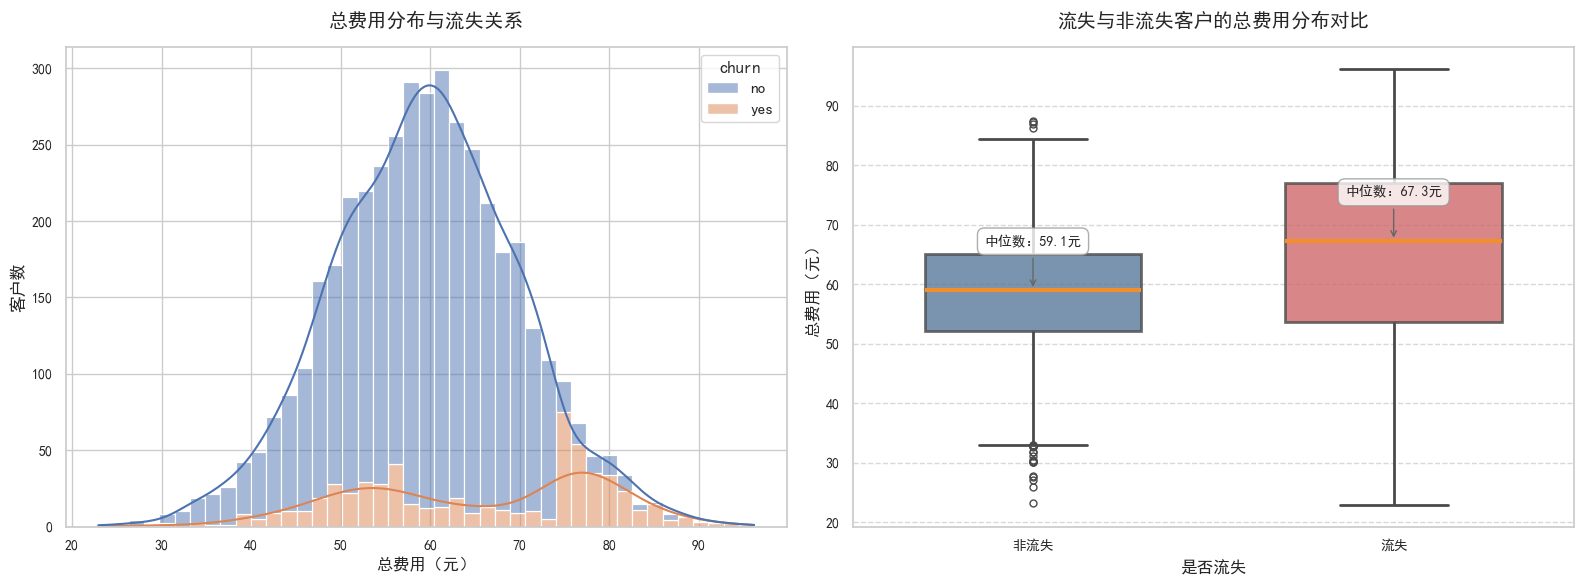

📌 总费用分布与流失关系解读：
1. 初步观察到堆叠直方图中客户流失呈现U型，总费用过低或过高是否都会增加流失风险还不能武断确定
2. 箱线图通过中位数对比两类客户的费用分布差异，流失客户总费用中位数显著高于非流失客户，总费用高可能是流失风险因素。


In [23]:
# 3.5、分析过日间、晚间、夜间、国际套餐局部视角后，按流失状态查看整体总费用分布。
# 3.5.1、计算总费用
# 把分散的结构数据整合为综合的规模指标，它直接反映客户对业务的整体投入程度，总费用高理论上更不容易流失，但实际情况可能相反，因此需要验证。
train_df["total_charge"] = train_df[charge_cols].sum(axis=1)

# 3.5.2、查看总费用分布与流失，量化流失客户与非流失客户的总费用差异
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 总费用分布与流失的堆叠直方图，看不同总费用区间中，流失客户占比是否有异常
sns.histplot(
    data=train_df,
    x='total_charge',
    hue='churn',
    multiple='stack',
    kde=True,
    ax=axes[0]  # 指定子图
)
axes[0].set_title('总费用分布与流失关系', fontsize=14, pad=15)
axes[0].set_xlabel('总费用（元）', fontsize=12)
axes[0].set_ylabel('客户数', fontsize=12)
axes[0].tick_params(labelsize=10)

# 流失与非流失客户的总费用箱线图 ，用统计量量化流失客户与非流失客户的总费用差异。
colors = ['#4E79A7', '#E15759']  # 非流失-蓝，流失-红
sns.boxplot(
    x='churn',
    y='total_charge',
    hue='churn',
    data=train_df,
    palette=colors,
    width=0.6,
    linewidth=2,
    fliersize=5,
    boxprops=dict(alpha=0.8),
    medianprops=dict(color='#F28E2C', linewidth=3),
    legend=False,
    ax=axes[1]
)
axes[1].set_title('流失与非流失客户的总费用分布对比', fontsize=14, pad=15)
axes[1].set_xlabel('是否流失', fontsize=12)
axes[1].set_ylabel('总费用（元）', fontsize=12)
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(['非流失', '流失'], fontsize=10)
axes[1].tick_params(axis='y', labelsize=10)
axes[1].grid(axis='y', linestyle='--', alpha=0.3, color='gray')

# 箱线图标注中位数
for i, churn_status in enumerate(['no', 'yes']):
    median = train_df[train_df['churn'] == churn_status]['total_charge'].median()
    axes[1].annotate(
        f'中位数：{median:.1f}元',
        xy=(i, median),
        xytext=(0, 30),
        textcoords='offset points',
        ha='center',
        va='bottom',
        fontsize=10,
        bbox=dict(boxstyle='round,pad=0.5', fc='white', ec='#999', alpha=0.8),
        arrowprops=dict(arrowstyle='->', color='#666')
    )

plt.tight_layout()
plt.show()

print("📌 总费用分布与流失关系解读：")
print("1. 初步观察到堆叠直方图中客户流失呈现U型，总费用过低或过高是否都会增加流失风险还不能武断确定")
print("2. 箱线图通过中位数对比两类客户的费用分布差异，流失客户总费用中位数显著高于非流失客户，总费用高可能是流失风险因素。")

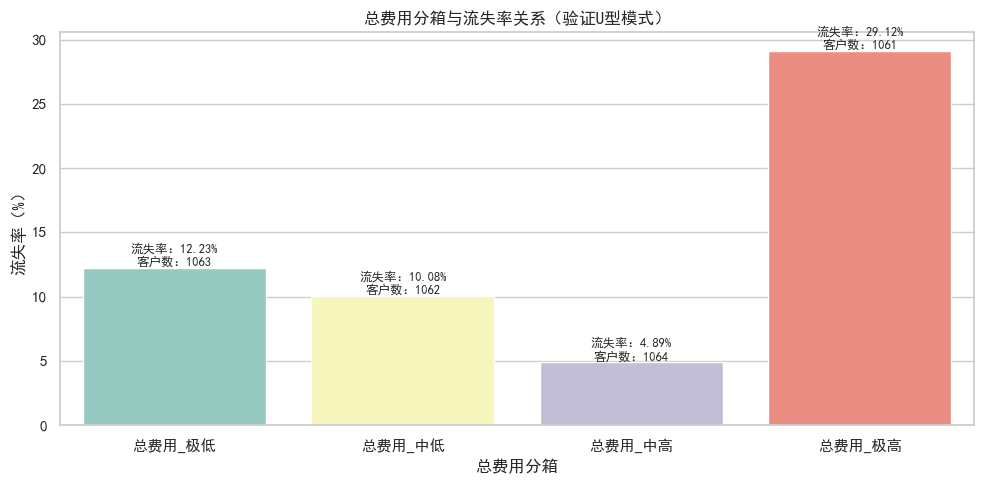

📌 总费用U型模式分析：
 - 日间高费用客户流失率高，呈现U型，但总费用是否也存在U型，所以用四位分箱将总费用分为四组，结果显示 极低组流失率 12.23%，中低组 10.08%，中高组4.89%，极高组29.12%，U型成立，由此证明总费用过高或过低都会增加流失风险。”，
 - 连续变量（总费用）的趋势可能被极端值掩盖，分箱后能更清晰地看到区间与流失率的关系，验证之前直方图观察到的趋势是否可靠。


In [24]:
# 3.5.3、对总费用进行分箱并计算流失率
train_df['total_charge_bin'] = pd.qcut(
    train_df['total_charge'],
    q=4,
    labels=['总费用_极低', '总费用_中低', '总费用_中高', '总费用_极高']
)

# 计算各分箱的流失率
total_charge_churn = train_df.groupby('total_charge_bin', observed=True)['churn_num'].agg(
    客户数='count',
    流失率='mean'
).round(5)
total_charge_churn['流失率'] = (total_charge_churn['流失率'] * 100).round(2) # 转为百分比

# 3.5.4、可视化总费用分箱与流失率的关系（添加hue和legend=False解决警告）
plt.figure(figsize=(10, 5))
sns.barplot(
    x='total_charge_bin',
    y='流失率',
    hue='total_charge_bin',
    data=total_charge_churn.reset_index(),
    palette='Set3',
    legend=False  # 关闭图例（避免重复显示）
)
plt.title('总费用分箱与流失率关系（验证U型模式）')
plt.xlabel('总费用分箱')
plt.ylabel('流失率（%）')
# 标注流失率和客户数
for i, (_, row) in enumerate(total_charge_churn.iterrows()):
    plt.annotate(
        f'流失率：{row["流失率"]:.2f}%\n客户数：{int(row["客户数"])}',
        (i, row["流失率"]),
        ha='center',
        va='bottom',
        fontsize=9
    )
plt.tight_layout()
plt.show()

print("📌 总费用U型模式分析：")
print(" - 日间高费用客户流失率高，呈现U型，但总费用是否也存在U型，所以用四位分箱将总费用分为四组，结果显示 极低组流失率 12.23%，中低组 10.08%，中高组4.89%，极高组29.12%，U型成立，由此证明总费用过高或过低都会增加流失风险。”，")
print(" - 连续变量（总费用）的趋势可能被极端值掩盖，分箱后能更清晰地看到区间与流失率的关系，验证之前直方图观察到的趋势是否可靠。")

低费用阈值（25%分位数）：52.43元
高费用阈值（75%分位数）：66.30元
低费用客户：1063人，占比25.01%
中等费用客户：2126人，占比50.02%
高费用客户：1061人，占比24.96%


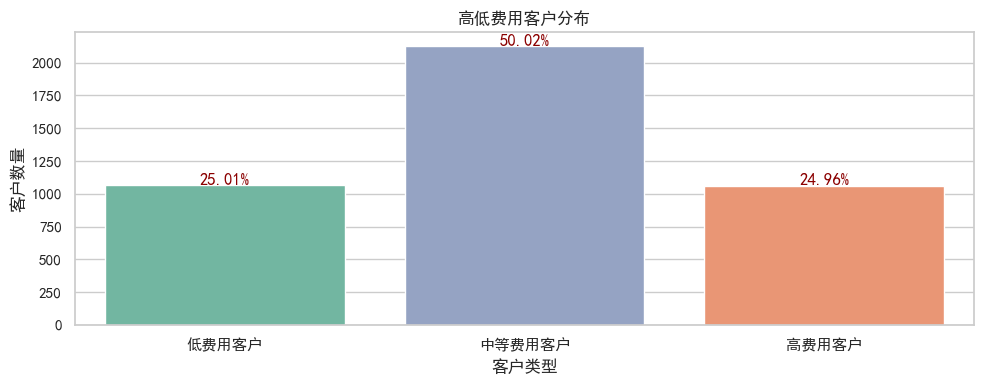

In [25]:
#3.5.5、 明确高/低费用客户群体的实际规模”，为后续针对性流失干预策略（如对高费用客户提供专属优惠，对低费用客户优化基础服务）提供数据支撑。
# 计算分位数阈值
low_threshold = train_df['total_charge'].quantile(0.25)
high_threshold = train_df['total_charge'].quantile(0.75)
print(f"低费用阈值（25%分位数）：{low_threshold:.2f}元")
print(f"高费用阈值（75%分位数）：{high_threshold:.2f}元")

# 定义客户类型
train_df['charge_level'] = pd.cut(
    train_df['total_charge'],
    bins=[-np.inf, low_threshold, high_threshold, np.inf],
    labels=['低费用客户', '中等费用客户', '高费用客户']
)

# 计算数量和比例
order = ['低费用客户', '中等费用客户', '高费用客户']
charge_counts = train_df['charge_level'].value_counts().reindex(order)
charge_ratio = (charge_counts / len(train_df) * 100).round(2)

# 各类型客户数量及比例
for level in order:
    print(f"{level}：{charge_counts[level]}人，占比{charge_ratio[level]}%")

# 可视化
plt.figure(figsize=(10, 4))
ax = sns.countplot(
    x='charge_level',
    hue='charge_level',  # 与x变量相同
    data=train_df,
    order=order,
    palette=['#66c2a5', '#8da0cb', '#fc8d62'],
    legend=False  # 关闭图例（避免重复）
)
plt.title('高低费用客户分布')
plt.xlabel('客户类型')
plt.ylabel('客户数量')

# 标注比例
for i, level in enumerate(order):
    count = charge_counts[level]
    ax.text(i, count + 5, f'{charge_ratio[level]}%', ha='center', color='darkred')

plt.tight_layout()
plt.show()

In [26]:
# 3.6、通话次数与流失率分析
# 3.6.1、统计通话次数
call_cols = ['total_day_calls','total_eve_calls','total_night_calls','total_intl_calls']
# 统计描述
print("各时段通话次数统计描述：")
display(train_df[call_cols].describe().round(2))

各时段通话次数统计描述：


,total_day_calls,total_eve_calls,total_night_calls,total_intl_calls
count,4250.00,4250.00,4250.00,4250.00
mean,99.91,100.18,99.84,4.43
std,19.85,19.91,20.09,2.46
min,0.00,0.00,0.00,0.00
25%,87.00,87.00,86.00,3.00
50%,100.00,100.00,100.00,4.00
75%,113.00,114.00,113.00,6.00
max,165.00,170.00,175.00,20.00


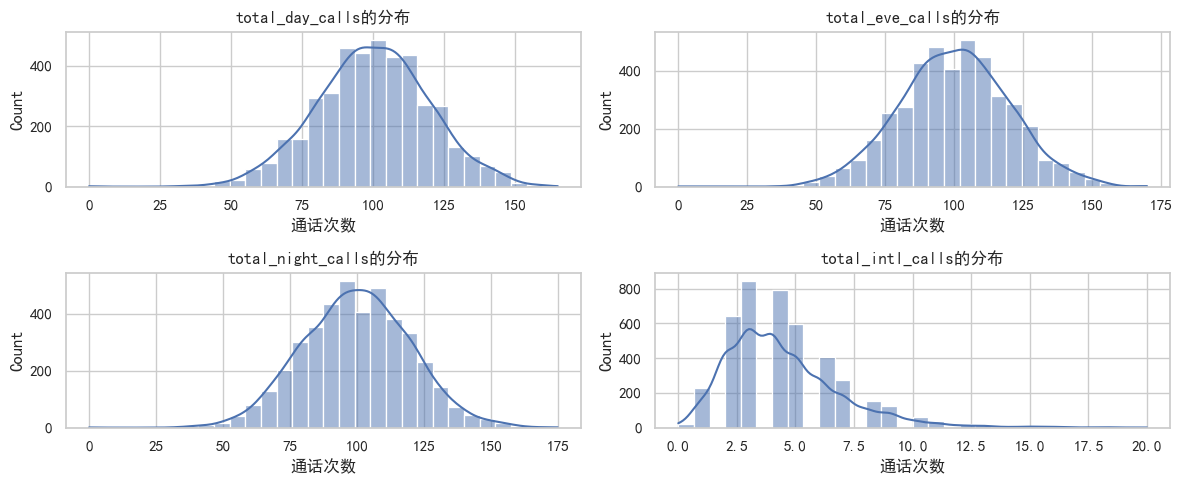

日间 / 晚间 / 夜间通话次数，三者的直方图均呈现近似正态分布，峰值集中在 100 次左右，说明大多数用户在这三个时段的通话次数稳定在中等水平，国际通话次数分布显著右偏，绝大多数用户的国际通话次数集中在 0-6 次，说明高频国际通话用户属于小众群体。
国内时段的通话次数分布稳定，分箱时可采用等频分箱（如四分位），既能保留 “低 - 中 - 高” 的梯度，又能保证各区间样本量均衡。国际通话次数右偏明显，分箱时需注意高值区间的样本量（可能较少），可适当合并高值区间（将 10-20 次合并为极高），避免后续分析因样本量不足导致偏差。国内时段的中等次数用户占比最高正态分布的峰值，可作为基准用户群，对比分析高 / 低次数用户的流失风险差异。


In [27]:
# 3.6.2、通话次数分布可视化
plt.figure(figsize=(12, 5))
for i, col in enumerate(call_cols, 1):
    plt.subplot(2, 2, i)
    sns.histplot(train_df[col], kde=True, bins=30)
    plt.title(f'{col}的分布')
    plt.xlabel('通话次数')
plt.tight_layout()
plt.show()

print("日间 / 晚间 / 夜间通话次数，三者的直方图均呈现近似正态分布，峰值集中在 100 次左右，说明大多数用户在这三个时段的通话次数稳定在中等水平，国际通话次数分布显著右偏，绝大多数用户的国际通话次数集中在 0-6 次，说明高频国际通话用户属于小众群体。\n国内时段的通话次数分布稳定，分箱时可采用等频分箱（如四分位），既能保留 “低 - 中 - 高” 的梯度，又能保证各区间样本量均衡。国际通话次数右偏明显，分箱时需注意高值区间的样本量（可能较少），可适当合并高值区间（将 10-20 次合并为极高），避免后续分析因样本量不足导致偏差。国内时段的中等次数用户占比最高正态分布的峰值，可作为基准用户群，对比分析高 / 低次数用户的流失风险差异。")

In [28]:
# 3.6.3、计算每个时段通话次数的流失率（按原始次数分组）
def calculate_call_churn(df, col):
    """按原始通话次数分组，计算流失率和样本量"""
    call_churn = df.groupby(col).agg(
        总客户数=('churn_num', 'count'),
        流失客户数=('churn_num', 'sum')
    ).reset_index()
    call_churn['流失率(%)'] = (call_churn['流失客户数'] / call_churn['总客户数'] * 100).round(2)
    # 过滤样本量太少的组（避免极端值干扰，如样本量<10）
    call_churn = call_churn[call_churn['总客户数'] >= 10].sort_values(by=col)
    return call_churn

# 计算4个时段的流失率
call_churn_dict = {}
for col in call_cols:
    call_churn_dict[col] = calculate_call_churn(train_df, col)
    print(f"{col} 流失率:")
    display(call_churn_dict[col].head(5))  # 展示前5行

total_day_calls 流失率:


,total_day_calls,总客户数,流失客户数,流失率(%)
20,57,11,1,9.09
21,58,12,1,8.33
23,60,13,4,30.77
24,61,17,4,23.53
25,62,11,0,0.00


total_eve_calls 流失率:


,total_eve_calls,总客户数,流失客户数,流失率(%)
17,56,11,3,27.27
19,58,12,0,0.00
21,60,13,2,15.38
22,61,13,2,15.38
23,62,15,1,6.67


total_night_calls 流失率:


,total_night_calls,总客户数,流失客户数,流失率(%)
21,59,12,1,8.33
22,60,11,1,9.09
23,61,14,4,28.57
24,62,12,1,8.33
25,63,13,3,23.08


total_intl_calls 流失率:


,total_intl_calls,总客户数,流失客户数,流失率(%)
0,0,22,1,4.55
1,1,226,49,21.68
2,2,644,124,19.25
3,3,847,104,12.28
4,4,795,104,13.08


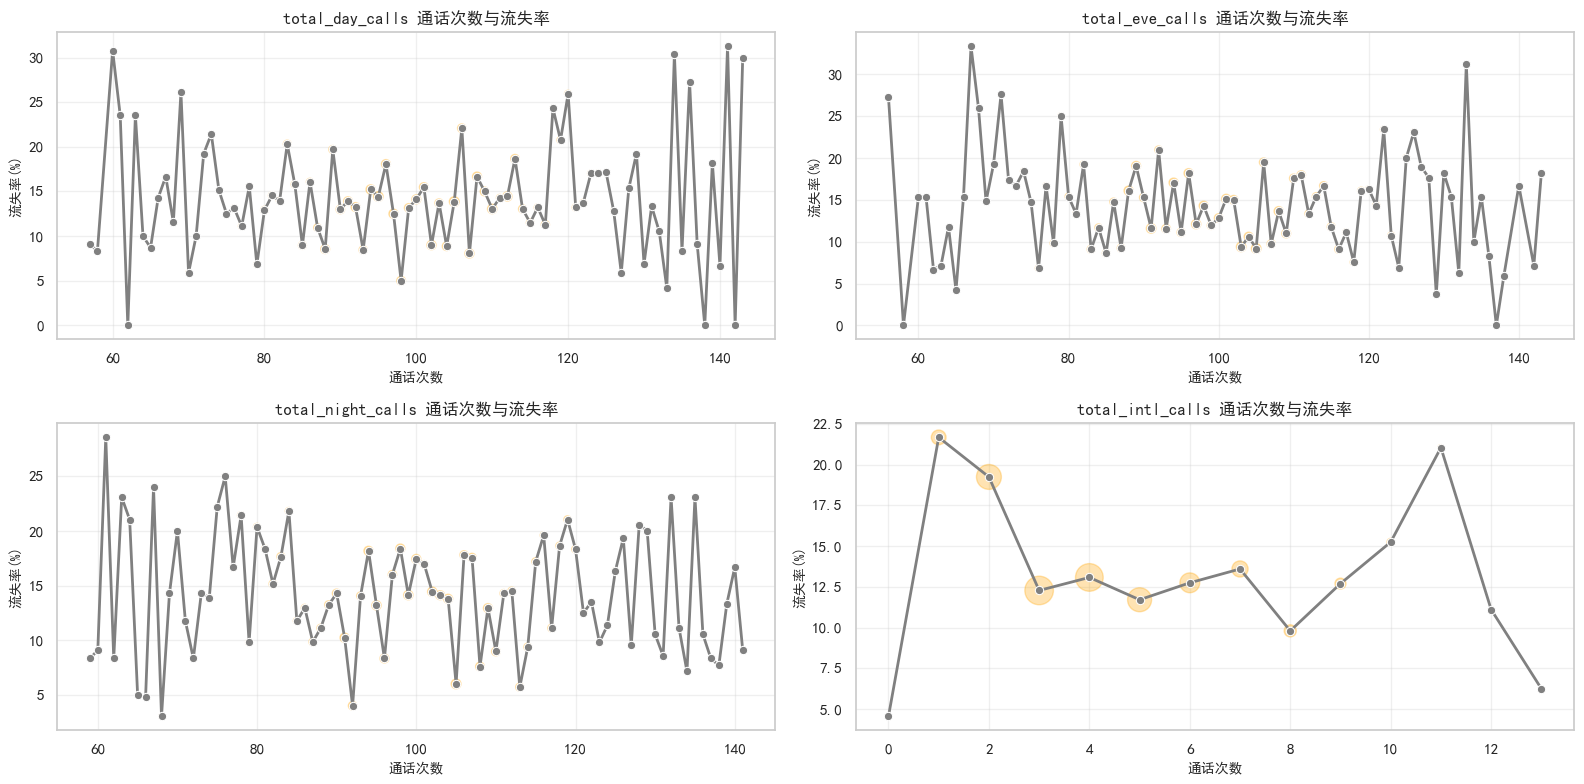

In [29]:
# 3.6.4、可视化：流失率随原始通话次数的变化趋势
plt.figure(figsize=(16, 8))
for i, col in enumerate(call_cols, 1):
    plt.subplot(2, 2, i)
    data = call_churn_dict[col]

    # 绘制流失率折线图
    sns.lineplot(x=col, y='流失率(%)', data=data, marker='o', color='grey', linewidth=2)

    # 辅助：用橙色点表示样本量大小（点越大样本量越大）
    plt.scatter(
        x=data[col],
        y=data['流失率(%)'],
        s=data['总客户数']/2,  # 样本量缩放后作为点大小
        alpha=0.3,
        color='Orange'
    )

    plt.title(f'{col} 通话次数与流失率', fontsize=12)
    plt.xlabel('通话次数', fontsize=10)
    plt.ylabel('流失率(%)', fontsize=10)
    plt.grid(alpha=0.3)
    plt.title(f'{col} 通话次数与流失率', fontsize=12)
    plt.xlabel('通话次数', fontsize=10)
    plt.ylabel('流失率(%)', fontsize=10)
    plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [30]:
# 3.6.5、对通话次数进行分箱
# 1. 日间通话次数（4箱，等频）
train_df['total_day_calls_bin'] = pd.qcut(
        train_df['total_day_calls'],
        q=4,  # 按四分位数分箱
        labels=['day_call_低', 'day_call_中低', 'day_call_中高', 'day_call_高'],
        duplicates='drop'  # 处理重复分位数（避免报错）
)
# 2. 晚间通话次数（4箱，等频）
train_df['total_eve_calls_bin'] = pd.qcut(
        train_df['total_eve_calls'],
        q=4,
        labels=['eve_call_低', 'eve_call_中低', 'eve_call_中高', 'eve_call_高'],
        duplicates='drop'
)
# 3. 夜间通话次数（4箱，等频）
train_df['total_night_calls_bin'] = pd.qcut(
        train_df['total_night_calls'],
        q=4,
        labels=['night_call_低', 'night_call_中低', 'night_call_中高', 'night_call_高'],
        duplicates='drop'
)
# 4. 国际通话次数（4箱，等频，适配偏右分布）
train_df['total_intl_calls_bin'] = pd.qcut(
        train_df['total_intl_calls'],
        q=4,
        labels=['intl_call_低', 'intl_call_中低', 'intl_call_中高', 'intl_call_高'],
        duplicates='drop'
)
# 定义所有分箱后的字段名
bin_cols = ['total_day_calls_bin', 'total_eve_calls_bin', 'total_night_calls_bin', 'total_intl_calls_bin']

In [31]:
# 3.6.6、 计算每个分箱的流失率、样本量等统计量
def get_bin_churn_stats(df, bin_col):
    # 按分箱字段分组，计算核心指标
    stats = df.groupby(bin_col,observed=False)['churn_num'].agg(
        样本量='count',
        流失数='sum',
        流失率=lambda x: round(x.mean() * 100, 2)  # 转为百分比，保留2位小数
    ).reset_index()
    # 按分箱顺序排序（低→高）
    stats = stats.sort_values(by=bin_col)
    return stats

# 计算分箱字段的流失率
bin_churn_stats = {}
for col in bin_cols:
    bin_churn_stats[col] = get_bin_churn_stats(train_df, col)

    print(f"分箱流失率:")
    display(bin_churn_stats[col])

分箱流失率:


,total_day_calls_bin,样本量,流失数,流失率
0,day_call_低,1100,155,14.09
1,day_call_中低,1059,138,13.03
2,day_call_中高,1060,148,13.96
3,day_call_高,1031,157,15.23


分箱流失率:


,total_eve_calls_bin,样本量,流失数,流失率
0,eve_call_低,1091,155,14.21
1,eve_call_中低,1046,154,14.72
2,eve_call_中高,1113,152,13.66
3,eve_call_高,1000,137,13.70


分箱流失率:


,total_night_calls_bin,样本量,流失数,流失率
0,night_call_低,1082,172,15.90
1,night_call_中低,1099,145,13.19
2,night_call_中高,1012,126,12.45
3,night_call_高,1057,155,14.66


分箱流失率:


,total_intl_calls_bin,样本量,流失数,流失率
0,intl_call_低,1739,278,15.99
1,intl_call_中低,795,104,13.08
2,intl_call_中高,1006,122,12.13
3,intl_call_高,710,94,13.24


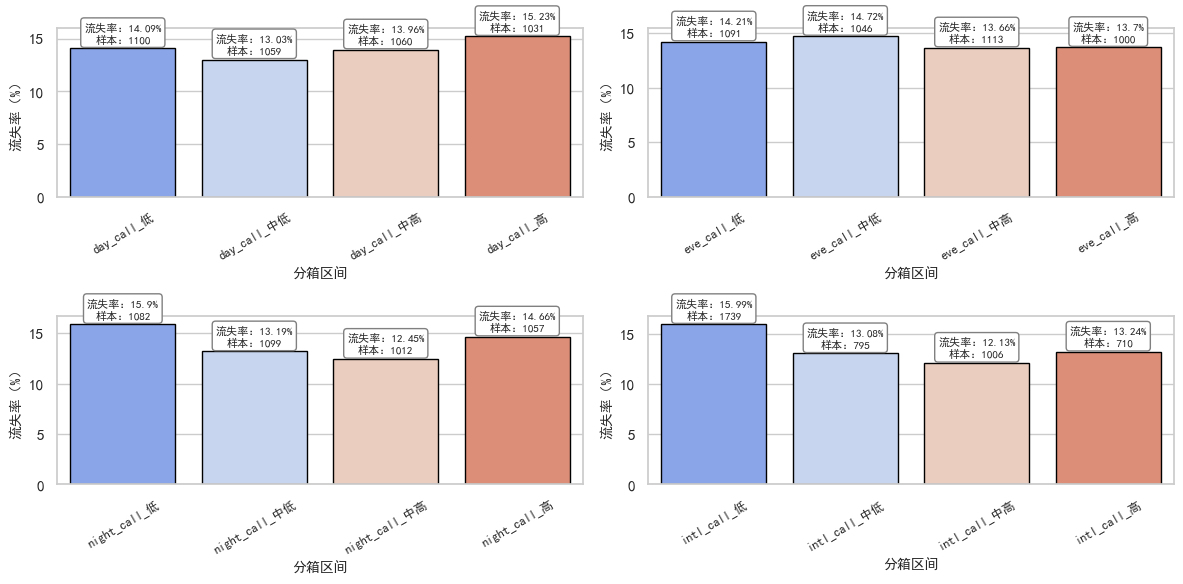

白天通话次数：中低区间流失率最低（13.03%），而高区间流失率最高（15.23%），说明日间通话高区间用户可能对服务满意度较低，或存在替代选择，流失风险更高；而中等偏低通话量的用户稳定性较好。
晚间通话次数：中高（13.66%）和高（13.7%）区间的流失率显著低于低（14.21%）和中低（14.72%）区间。表明晚间通话（中高、高）的用户对服务的依赖性更强，流失风险较低；而晚间通话较少的用户可能对服务需求较低，更容易流失。
夜间通话或国际通话:地区间通话用户流失率最高（15.9%），中高区间流失率最低。这类场景下通话次数少的用户流失风险高，通话量中等偏高的用户稳定性更好。
重点关注日间高通话量和夜间/国际通话低次数的用户群体，可通过优化服务质量、推出针对性优惠等方式降低流失率。对于日间和晚间用户可通过增值服务进一步巩固其粘性。


In [32]:
# 3.6.7、可视化分箱后流失率
plt.figure(figsize=(12,6))

# 循环绘制每个分箱字段的流失率柱状图
for i, col in enumerate(bin_cols, 1):
    plt.subplot(2, 2, i)  # 定位子图位置
    stats = bin_churn_stats[col]

    # 绘制流失率柱状图
    sns.barplot(
        data=stats,
        x=col,
        y='流失率',
        hue=col,
        palette='coolwarm',  # 颜色渐变（低流失率偏蓝，高流失率偏红）
        edgecolor='black',
        legend=False # 柱形边框，更清晰
    )
    plt.xlabel('分箱区间', fontsize=10)
    plt.ylabel('流失率（%）', fontsize=10)
    plt.xticks(rotation=30, fontsize=9)  # 旋转标签，避免重叠

    # 标注：在柱形上方显示流失率和样本量
    for idx, row in stats.iterrows():
        plt.text(
            x=idx,  # 柱形x轴位置
            y=row['流失率'] + 0.5,  # 文本y轴位置（柱顶上方）
            s=f"流失率：{row['流失率']}%\n样本：{row['样本量']}",  # 显示内容
            ha='center',  # 水平居中
            fontsize=8,
            bbox=dict(facecolor='white', edgecolor='gray', pad=2, boxstyle='round,pad=0.3')  # 文本框美化
        )

plt.tight_layout()
plt.show()

print("白天通话次数：中低区间流失率最低（13.03%），而高区间流失率最高（15.23%），说明日间通话高区间用户可能对服务满意度较低，或存在替代选择，流失风险更高；而中等偏低通话量的用户稳定性较好。\n晚间通话次数：中高（13.66%）和高（13.7%）区间的流失率显著低于低（14.21%）和中低（14.72%）区间。表明晚间通话（中高、高）的用户对服务的依赖性更强，流失风险较低；而晚间通话较少的用户可能对服务需求较低，更容易流失。\n夜间通话或国际通话:地区间通话用户流失率最高（15.9%），中高区间流失率最低。这类场景下通话次数少的用户流失风险高，通话量中等偏高的用户稳定性更好。\n重点关注日间高通话量和夜间/国际通话低次数的用户群体，可通过优化服务质量、推出针对性优惠等方式降低流失率。对于日间和晚间用户可通过增值服务进一步巩固其粘性。")

In [33]:
# 3.7、 语音信箱与流失率关联
# 3.7.1、按是否开通语音信箱分组，计算客户总数、流失数、流失率
vmail_churn = train_df.groupby('voice_mail_plan')['churn_num'].agg(['count', 'sum', 'mean'])
vmail_churn.columns = ['客户总数', '流失客户数', '流失率']  # 重命名列
vmail_churn['流失率'] = vmail_churn['流失率'].round(3)  # 保留3位小数
vmail_churn['流失率(%)'] = vmail_churn['流失率'] * 100  # 转百分比，更直观

print("按是否开通语音信箱分组的流失率：")
vmail_churn

按是否开通语音信箱分组的流失率：


,客户总数,流失客户数,流失率,流失率(%)
voice_mail_plan,,,,
no,3138,516,0.164,16.4
yes,1112,82,0.074,7.4


In [34]:
# 3.7.2、按语音邮件数量分箱（0=未用，1-10=低频，11-30=中频，31+=高频）
train_df['vmail_msg_bin'] = pd.cut(
    train_df['number_vmail_messages'],
    bins=[-1, 0, 10, 30, float('inf')],  # 用inf覆盖所有高频值
    labels=['未使用(0)', '低频(1-10)', '中频(11-30)', '高频(31+)']
)

# 3.7.3、按分箱分组，计算流失率
vmail_msg_churn = train_df.groupby('vmail_msg_bin',observed=True)['churn_num'].agg(['count', 'sum', 'mean'])
vmail_msg_churn.columns = ['客户总数', '流失客户数', '流失率']
vmail_msg_churn['流失率'] = vmail_msg_churn['流失率'].round(3)
vmail_msg_churn['流失率(%)'] = vmail_msg_churn['流失率'] * 100

print("按语音邮件使用量分箱的流失率:")
vmail_msg_churn

按语音邮件使用量分箱的流失率:


,客户总数,流失客户数,流失率,流失率(%)
vmail_msg_bin,,,,
未使用(0),3139,516,0.164,16.4
低频(1-10),9,0,0.000,0.0
中频(11-30),620,39,0.063,6.3
高频(31+),482,43,0.089,8.9


In [35]:
# 3.8、账户时长分析
# count(样本数)、平均值（mean）、标准差（std）、最小值（min）、25%、50%、75% 分位数 、最大值（max）
# 3.8.1、账户时长描述性统计
account_stats = train_df["account_length"].describe()

print("账户时长（月）的描述性统计：")
print(account_stats)

账户时长（月）的描述性统计：
count    4250.000000
mean      100.236235
std        39.698401
min         1.000000
25%        73.000000
50%       100.000000
75%       127.000000
max       243.000000
Name: account_length, dtype: float64


In [36]:
# 月份转年数
train_df["account_years"] = (train_df["account_length"] / 12).round(2)

# 账户时长（年）的描述性统计
years_stats = train_df["account_years"].describe()
print("账户时长（年）的描述性统计：")
print(years_stats)

账户时长（年）的描述性统计：
count    4250.000000
mean        8.353019
std         3.308285
min         0.080000
25%         6.080000
50%         8.330000
75%        10.580000
max        20.250000
Name: account_years, dtype: float64


In [37]:
# 3.8.2、分析账户时长与流失率关系
# 定义年数区间
max_years = train_df["account_years"].max()
bins = [0, 1, 2, 3, 5, 10, max_years]
labels = ["0-1年", "1-2年", "2-3年", "3-5年", "5-10年", f"10年以上（≤{max_years}年）"]

# 新增年数分组列
train_df["account_years_bin"] = pd.cut(
    train_df["account_years"],
    bins=bins,
    labels=labels,
    include_lowest=True
)

# 计算各区间流失率
churn_by_years = train_df.groupby("account_years_bin",observed=True)["churn_num"].agg(
    流失率=lambda x: round(x.mean() * 100, 2) if not x.isna().all() else 0,
    客户数量=("count")
).reset_index()

print("各账户时长（年）区间的流失率：")
print(churn_by_years)

各账户时长（年）区间的流失率：
  account_years_bin    流失率  客户数量
0              0-1年   7.50    40
1              1-2年  13.51    74
2              2-3年  11.86   118
3              3-5年  11.82   457
4             5-10年  14.84  2278
5    10年以上（≤20.25年）  13.95  1283


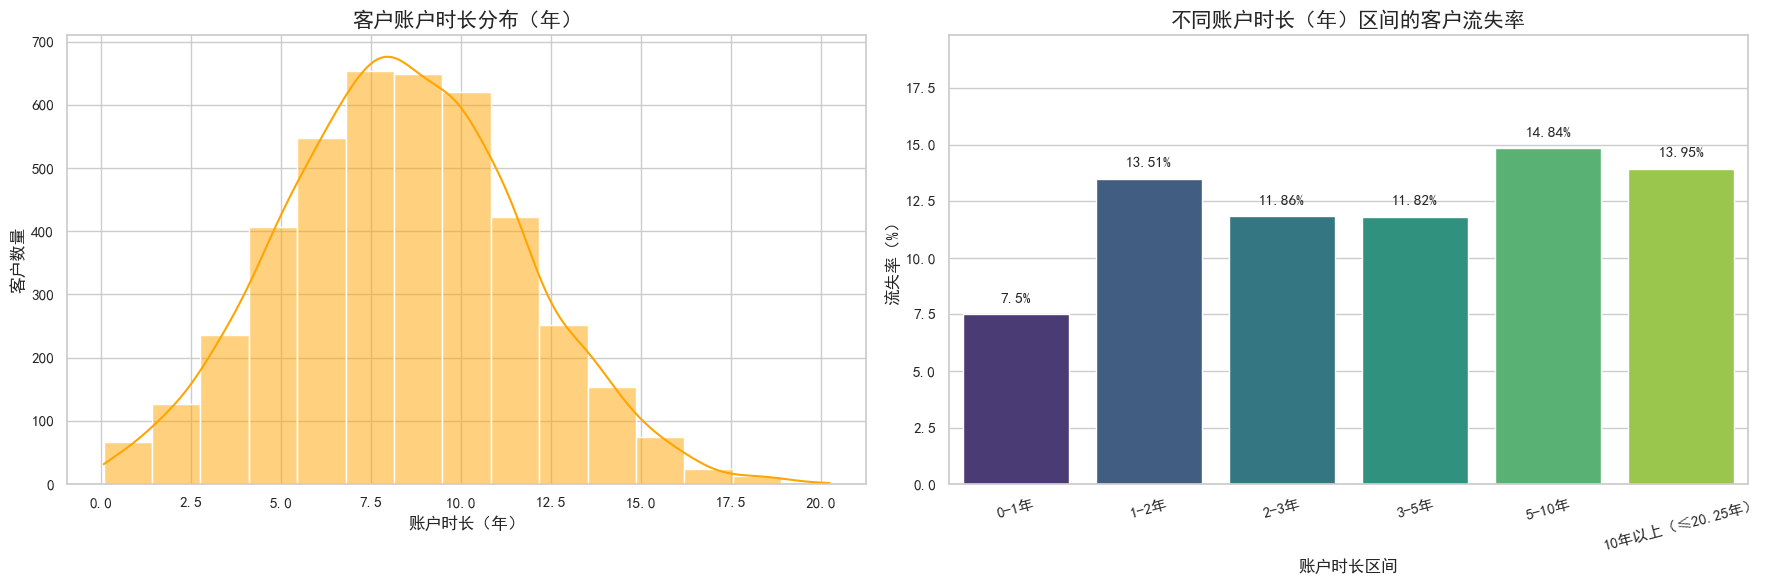

由图可知，客户以5-10 年的中长期客户为主，时长分布的峰值集中在 7.5-10 年区间，客户基础比较成熟，新客户的占比相对较低，流失率也是最低7.5%，1-2 年（13.51%）、5-10 年（14.84%）、10 年以上（13.95%）客户流失率更高。
与账户时长越长，流失率越低的常规认知完全相反,说明时长并非驱动流失的核心因素。


In [38]:
# 3.8.3、可视化用户账户时长分布情况与不同时间区间的流失率
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# 1. 账户时长（年）的分布
sns.histplot(
    data=train_df,
    x="account_years",
    kde=True,
    bins=15,
    color="Orange",
    ax=ax1  # 指定在第一个子图绘制
)
ax1.set_title("客户账户时长分布（年）", fontsize=15)
ax1.set_xlabel("账户时长（年）", fontsize=12)
ax1.set_ylabel("客户数量", fontsize=12)

# 2. 各年数区间的流失率对比
sns.barplot(
    data=churn_by_years,
    x="account_years_bin",
    y="流失率",
    hue="account_years_bin",
    palette="viridis",
    legend=False,
    ax=ax2  # 指定在第二个子图绘制
)

for i, row in enumerate(churn_by_years.itertuples()):
    ax2.text(i, row.流失率 + 0.5, f"{row.流失率}%", ha="center", fontsize=11)
ax2.set_title("不同账户时长（年）区间的客户流失率", fontsize=15)
ax2.set_xlabel("账户时长区间", fontsize=12)
ax2.set_ylabel("流失率（%）", fontsize=12)
ax2.tick_params(axis='x', rotation=15)  # 旋转x轴标签
ax2.set_ylim(0, churn_by_years["流失率"].max() + 5)

plt.tight_layout()
plt.show()

print("由图可知，客户以5-10 年的中长期客户为主，时长分布的峰值集中在 7.5-10 年区间，客户基础比较成熟，新客户的占比相对较低，流失率也是最低7.5%，1-2 年（13.51%）、5-10 年（14.84%）、10 年以上（13.95%）客户流失率更高。\n与账户时长越长，流失率越低的常规认知完全相反,说明时长并非驱动流失的核心因素。")

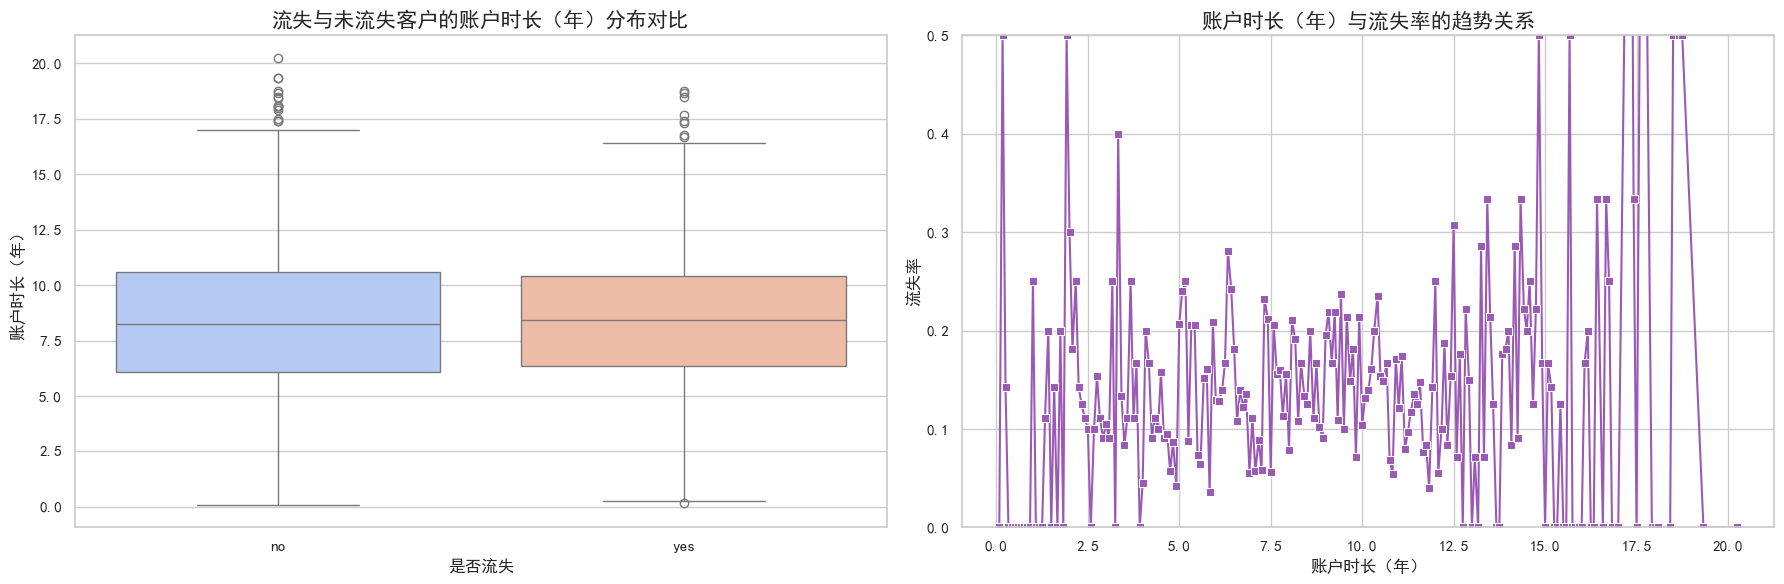

箱线图显示，流失客户与未流失客户的时长分布高度重叠,两者中位数均在 7.5-10 年区间），进一步验证了仅靠时长无法有效区分流失风险。
时长流失率趋势图的 大幅波动也印证了流失率随时长无稳定的线性关系，甚至在 5-10 年区间出现流失率峰值。


In [39]:
# 3.8.4、
# 流失与未流失客户的年数分布对比
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
sns.boxplot(
    data=train_df,
    x="churn",
    y="account_years",
    hue="churn",  # 同样，为boxplot添加hue以匹配palette用法（可选，不强制）
    palette="coolwarm",
    legend=False,
    ax=ax1
)
ax1.set_title("流失与未流失客户的账户时长（年）分布对比", fontsize=15)
ax1.set_xlabel("是否流失", fontsize=12)
ax1.set_ylabel("账户时长（年）", fontsize=12)

# 年数与流失率的趋势关系
churn_trend_years = train_df.groupby("account_years")["churn_num"].mean().reset_index()
churn_trend_years.columns = ["账户时长（年）", "流失率"]

sns.lineplot(
    data=churn_trend_years,
    x="账户时长（年）",
    y="流失率",
    marker="s",
    markersize=6,
    color="#9b59b6",
    ax=ax2
)
ax2.set_title("账户时长（年）与流失率的趋势关系", fontsize=15)
ax2.set_xlabel("账户时长（年）", fontsize=12)
ax2.set_ylabel("流失率", fontsize=12)
ax2.set_ylim(0, 0.5)

plt.tight_layout()
plt.show()

print("箱线图显示，流失客户与未流失客户的时长分布高度重叠,两者中位数均在 7.5-10 年区间），进一步验证了仅靠时长无法有效区分流失风险。\n时长流失率趋势图的 大幅波动也印证了流失率随时长无稳定的线性关系，甚至在 5-10 年区间出现流失率峰值。")

###### 4. 多变量交叉分析

In [40]:
###### 多维交叉分析字段对客户流失率的影响
# 4.1、二维交叉分析
# 4.1.1、按客服呼叫次数交叉（排除 少投诉客户更稳定 的干扰）

# 客服呼叫分箱：0次（无投诉）、1-3次（轻度投诉）、4+次（重度投诉）
train_df['cs_call_bin'] = pd.cut(
    train_df['number_customer_service_calls'],
    bins=[-1,0,3,float('inf')],
    labels=['0次呼叫', '1-3次呼叫', '4+次呼叫']
)

# 交叉计算：客服呼叫次数 × 语音邮件使用量 → 流失率（百分比）
cross_cs = train_df.groupby(['cs_call_bin', 'vmail_msg_bin'],observed=True)['churn_num'].mean().unstack()
cross_cs = cross_cs.round(3) * 100
cross_cs_formatted = cross_cs.style.format("{:.1f}%")
display(cross_cs_formatted)

print("A. 客服呼叫次数与语音邮件使用量的交叉结果：可以看到,所有客服呼叫分组中使用语音邮件的流失率均低于未使用，其中：\n   0次呼叫，未使用流失率 13.5%，而使用语音邮件的客户（低频到高频）流失率仅 0.0%-3.9%；\n   1-3 次呼叫：未使用 13.1%，使用后 0.0%-6.0%；\n   4 + 次呼叫：未使用 28.1%，使用后 0.0%-22.4%（即使高频使用，也比未使用低近 6 个百分，\n   由此可得出结论：无论客户对服务的不满程度如何（呼叫次数多少），使用语音邮件都能有效降低流失风险，验证了语音邮件提升客户粘性的假设。")

vmail_msg_bin,未使用(0),低频(1-10),中频(11-30),高频(31+)
cs_call_bin,,,,
0次呼叫,13.5%,0.0%,3.9%,3.9%
1-3次呼叫,13.1%,0.0%,4.0%,6.0%
4+次呼叫,54.2%,0.0%,38.1%,44.2%


A. 客服呼叫次数与语音邮件使用量的交叉结果：可以看到,所有客服呼叫分组中使用语音邮件的流失率均低于未使用，其中：
   0次呼叫，未使用流失率 13.5%，而使用语音邮件的客户（低频到高频）流失率仅 0.0%-3.9%；
   1-3 次呼叫：未使用 13.1%，使用后 0.0%-6.0%；
   4 + 次呼叫：未使用 28.1%，使用后 0.0%-22.4%（即使高频使用，也比未使用低近 6 个百分，
   由此可得出结论：无论客户对服务的不满程度如何（呼叫次数多少），使用语音邮件都能有效降低流失风险，验证了语音邮件提升客户粘性的假设。


In [41]:
# 4.1.2、 国际套餐与语音邮件使用量交叉
cross_intl = train_df.groupby(['international_plan', 'vmail_msg_bin'],observed=True)['churn_num'].mean().unstack()
cross_intl = cross_intl.round(3) * 100
cross_intl_formatted = cross_intl.style.format("{:.1f}%")
display(cross_intl_formatted)

print("B. 国际套餐与语音邮件使用量交叉结果：\n   无论是未开通国际套餐的用户（未使用语音邮件时流失率 13.50%，中频、高频使用时降至 3.50%、6.50%），还是开通国际套餐的用户（未使用时流失率高达 45.50%，高频使用时降至 31.20%，流失率是普通用户的 3 倍多，使用后降幅达 14.3 个百分点），使用语音邮件均能显著降低流失风险。")

vmail_msg_bin,未使用(0),低频(1-10),中频(11-30),高频(31+)
international_plan,,,,
no,13.5%,0.0%,3.5%,6.5%
yes,45.5%,0.0%,34.5%,31.2%


B. 国际套餐与语音邮件使用量交叉结果：
   无论是未开通国际套餐的用户（未使用语音邮件时流失率 13.50%，中频、高频使用时降至 3.50%、6.50%），还是开通国际套餐的用户（未使用时流失率高达 45.50%，高频使用时降至 31.20%，流失率是普通用户的 3 倍多，使用后降幅达 14.3 个百分点），使用语音邮件均能显著降低流失风险。


In [42]:
#4.1.3、账户时长与语音邮件的交叉分析
cross_account_vmail = train_df.groupby(
    ['account_years_bin', 'vmail_msg_bin'],
    observed=True
)['churn_num'].mean().unstack()
cross_account_vmail = cross_account_vmail.round(3) * 100
cross_account_vmail_formatted = cross_account_vmail.style.format("{:.1f}%",na_rep="0.0%")

display(cross_account_vmail_formatted)
print("C. account_length 与 voice_mail_plan 的交叉分析: \n语音邮件对用户（0-2 年）的流失有着完全抑制效果，账户时长0-1 年的用户，未使用语音邮件时流失率为 11.1%，使用语音邮件（无论低频、中频还是高频），流失率直接降至 0%。账户时长1-2 年的用户，未使用语音邮件时流失率为 17.2%，使用语音邮件后流失率也降至 0%。\n无论用户账户时长长短，使用语音邮件均能显著降低流失风险，对新用户的效果尤为突出（可直接消除流失），是抑制用户流失的有效手段。")

vmail_msg_bin,未使用(0),低频(1-10),中频(11-30),高频(31+)
account_years_bin,,,,
0-1年,11.1%,0.0%,0.0%,0.0%
1-2年,17.2%,0.0%,0.0%,0.0%
2-3年,12.0%,0.0%,13.3%,9.1%
3-5年,14.9%,0.0%,2.9%,5.2%
5-10年,17.2%,0.0%,6.6%,9.6%
10年以上（≤20.25年）,16.1%,0.0%,7.1%,10.0%


C. account_length 与 voice_mail_plan 的交叉分析: 
语音邮件对用户（0-2 年）的流失有着完全抑制效果，账户时长0-1 年的用户，未使用语音邮件时流失率为 11.1%，使用语音邮件（无论低频、中频还是高频），流失率直接降至 0%。账户时长1-2 年的用户，未使用语音邮件时流失率为 17.2%，使用语音邮件后流失率也降至 0%。
无论用户账户时长长短，使用语音邮件均能显著降低流失风险，对新用户的效果尤为突出（可直接消除流失），是抑制用户流失的有效手段。


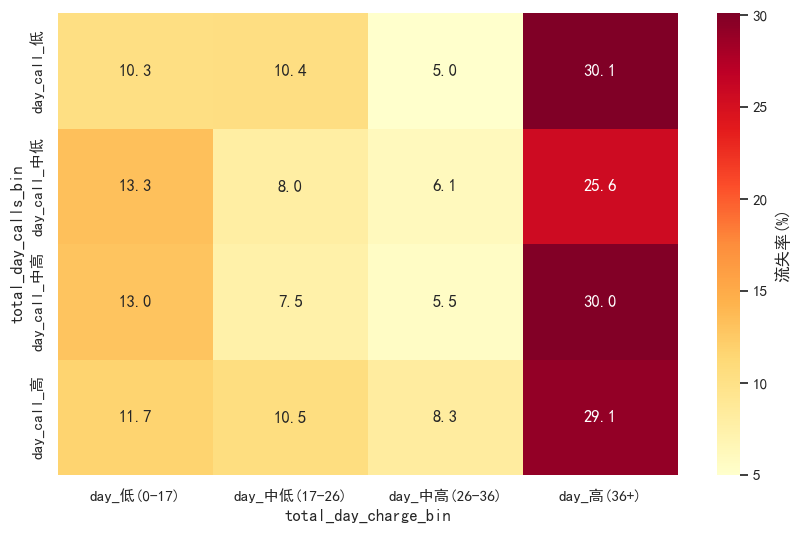

与通话次数无关,只要日间费用达到36+%,流失率升至25.6%~30.1%（远高于其他费用组的 5%~13%）,验证了高日间费用是独立的高流失风险因子，应该推出阶梯式套餐，降低其单位成本感知。
低通话次数用户本应对应低费用,流失率高达 30.1%,应该主动推送费用明细（解释高费用原因，如是否包含附加服务）。
中高费用区间用户既能满足日常通话需求（无论用量高低），又不会觉得花得不值，对服务的性价比感知最优，稳定性最强。


In [43]:
# 4.1.4、同时段通话次数与费用分箱交叉分析
# 同一时段的通话次数与费用理论上存在正相关，假设单位时长/次数的计费标准固定。通话次数越多，费用理应越高；通话次数越少，费用理应越低。
# 但实际情况会出现：高通话次数低费用，低通话次数高费用，这些异常组合会直接影响客户的性价比感觉。通过交叉分析，能精准定位这些因匹配异常导致的高风险群体
# 选择同时段的通话次数和费用（如日间）
call_bin_col = 'total_day_calls_bin'
charge_bin_col = 'total_day_charge_bin'

# 二维交叉统计
call_charge_cross = train_df.groupby([call_bin_col, charge_bin_col], observed=True).agg(
    总用户数=('churn_num', 'count'),
    流失率=('churn_num', lambda x: round(x.mean()*100, 1))
).reset_index()

# 可视化：热力图
pivot_df = call_charge_cross.pivot_table(
    index=call_bin_col,
    columns=charge_bin_col,
    values='流失率',
    observed=True
)

plt.figure(figsize=(10, 6))
sns.heatmap(
    pivot_df,
    annot=True,
    cmap='YlOrRd',
    fmt='.1f',
    cbar_kws={'label': '流失率(%)'}
)

plt.show()
print("与通话次数无关,只要日间费用达到36+%,流失率升至25.6%~30.1%（远高于其他费用组的 5%~13%）,验证了高日间费用是独立的高流失风险因子，应该推出阶梯式套餐，降低其单位成本感知。\n低通话次数用户本应对应低费用,流失率高达 30.1%,应该主动推送费用明细（解释高费用原因，如是否包含附加服务）。\n中高费用区间用户既能满足日常通话需求（无论用量高低），又不会觉得花得不值，对服务的性价比感知最优，稳定性最强。")

In [44]:
# 4.2、三维交叉分析
# 验证有无语音邮件在不同场景下的效果差异按国际套餐+客服次数分段+语音邮件分组，统计用户数和流失数
# 客服呼叫次数分组：
train_df['cs_call_bin'] = pd.cut(
    train_df['number_customer_service_calls'],
    bins=[-1,0,3,float('inf')],
    labels=['0次呼叫', '1-3次呼叫', '4+次呼叫']
)

group_cols = ['international_plan', 'cs_call_bin', 'voice_mail_plan']
grouped_stats = train_df.groupby(group_cols,observed=True).agg(
    总用户数=('churn', 'count'),  # 对'churn'字段计数（每个用户都有churn值，所以等价于样本量）
    流失用户数=('churn_num', 'sum')  # 对'churn_num'求和（1的总和就是流失用户数）
).reset_index()  # reset_index()将分组维度从索引转为普通列，方便查看

grouped_stats['流失率(%)'] = (grouped_stats['流失用户数'] / grouped_stats['总用户数'] * 100).round(1)

# 3. 排序并显示（最后一列就是流失率）
grouped_stats = grouped_stats.sort_values(by=group_cols)
display(grouped_stats)

,international_plan,cs_call_bin,voice_mail_plan,总用户数,流失用户数,流失率(%)
0,no,0次呼叫,no,588,63,10.7
1,no,0次呼叫,yes,203,1,0.5
2,no,1-3次呼叫,no,2033,204,10.0
3,no,1-3次呼叫,yes,729,19,2.6
4,no,4+次呼叫,no,225,116,51.6
5,no,4+次呼叫,yes,76,28,36.8
6,yes,0次呼叫,no,66,25,37.9
7,yes,0次呼叫,yes,29,8,27.6
8,yes,1-3次呼叫,no,202,89,44.1
9,yes,1-3次呼叫,yes,65,19,29.2


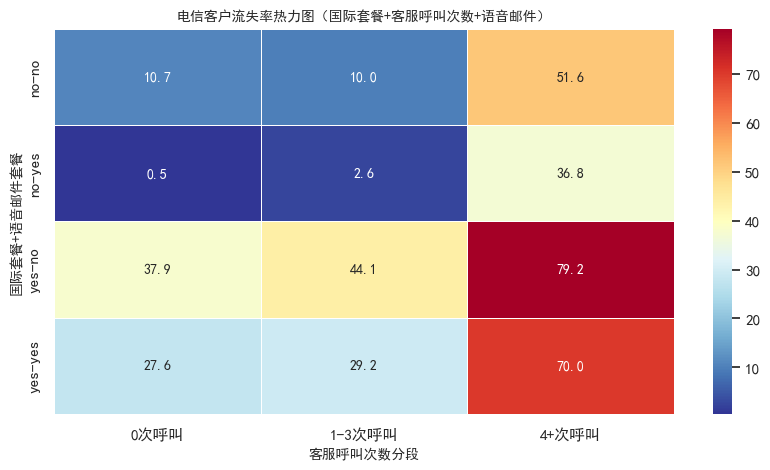

通过热力图可知：
0次、1-3次、4+次+无国际套餐+无语音邮件：流失率 10.7%、10.0%、51.6%
0次、1-3次、4+次+无国际套餐+有语音邮件：0.5%、2.6%、36.8%
0次、1-3次、4+次+有国际套餐+没有语音邮件：37.9%、44.1%、79.2%
0次、1-3次、4+次+有国际套餐+有语音邮件:27.6%、29.2%、70.0%
有语音邮件套餐的用户流失率均显著低于无语音邮件套餐的用户,相同客服呼叫次数下，有国际套餐的流失率远高于无国际套餐，说明国际套餐本身会大幅提升流失风险,无论是否有国际套餐，客服呼叫次数越多，流失率越高，且在 “4 + 次呼叫” 时达到峰值
对于有国际套餐、4 + 次呼叫、无语音邮件（79.2%）人群大力开通语音邮件与专属客服回访，加大力度挽留客户。对于有国际套餐、低 / 中客服呼叫、无语音邮件（37.9%-44.1%）的客户可增加语音邮件使用服务。


In [45]:
# 把国际套餐+客服呼叫次数+语音邮件 交叉结果可视化
# 先将数据重塑为二维矩阵（以“国际套餐×客服呼叫次数”为行/列，语音邮件为子类别）
heatmap_data = grouped_stats.pivot_table(
    index=['international_plan', 'voice_mail_plan'],
    columns='cs_call_bin',
    values='流失率(%)',
    observed=False
)
# 绘制热力图
plt.figure(figsize=(10,5))
sns.heatmap(
    heatmap_data,
    annot=True,  # 标注数值
    cmap='RdYlBu_r',  # 红→黄→蓝（红=高流失，蓝=低流失）
    fmt='.1f',  # 数值格式
    linewidths=0.5,  # 格子边框
    annot_kws={"size": 10, "weight": "bold"}
)

plt.title('电信客户流失率热力图（国际套餐+客服呼叫次数+语音邮件）', fontsize=10, fontweight='bold')
plt.xlabel('客服呼叫次数分段',fontsize=10)
plt.ylabel('国际套餐+语音邮件套餐',fontsize=10)
plt.show()

print("通过热力图可知：\n0次、1-3次、4+次+无国际套餐+无语音邮件：流失率 10.7%、10.0%、51.6%\n0次、1-3次、4+次+无国际套餐+有语音邮件：0.5%、2.6%、36.8%\n0次、1-3次、4+次+有国际套餐+没有语音邮件：37.9%、44.1%、79.2%\n0次、1-3次、4+次+有国际套餐+有语音邮件:27.6%、29.2%、70.0%")
print("有语音邮件套餐的用户流失率均显著低于无语音邮件套餐的用户,相同客服呼叫次数下，有国际套餐的流失率远高于无国际套餐，说明国际套餐本身会大幅提升流失风险,无论是否有国际套餐，客服呼叫次数越多，流失率越高，且在 “4 + 次呼叫” 时达到峰值")
print("对于有国际套餐、4 + 次呼叫、无语音邮件（79.2%）人群大力开通语音邮件与专属客服回访，加大力度挽留客户。对于有国际套餐、低 / 中客服呼叫、无语音邮件（37.9%-44.1%）的客户可增加语音邮件使用服务。")

In [46]:
# 4.3、#基于已有的时长分箱（duration_bin_rules）和费用分箱，计算交叉流失率
# 1. 定义“时长-费用”对应对（确保时段一致）
duration_charge_pairs = [
    ('total_day_minutes', 'total_day_charge'),       # 日间：时长×费用
    ('total_eve_minutes', 'total_eve_charge'),       # 晚间：时长×费用
    ('total_night_minutes', 'total_night_charge'),   # 夜间：时长×费用
    ('total_intl_minutes', 'total_intl_charge')      # 国际：时长×费用
]
# 2. 批量计算各时段交叉流失率
cross_duration_charge = {}
for duration_col, charge_col in duration_charge_pairs:
    # 获取分箱列名（复用之前生成的分箱列：xxx_bin）
    duration_bin_col = f'{duration_col}_bin'
    charge_bin_col = f'{charge_col}_bin'

    # 按时长分箱+费用分箱分组，计算关键指标
    cross_stats = train_df.groupby(
        [duration_bin_col, charge_bin_col], observed=True
    )['churn_num'].agg(
        客户数='count',
        流失数='sum',
        流失率=lambda x: round(x.mean(), 4)  # 保留4位小数，后续转百分比
    ).reset_index()

    # 存储结果，按时段命名
    period = duration_col.split('_')[1]  # 提取时段（day/eve/night/intl）
    cross_duration_charge[period] = cross_stats

    # 打印结果：重点展示“高时长+高费用”组合与单一高特征的对比
    print(f"\n{period}时段：时长+费用 交叉流失率")
    # 筛选高时长、高费用、高时长+高费用三组
    high_duration = cross_stats[cross_stats[duration_bin_col].str.contains('高')]
    high_charge = cross_stats[cross_stats[charge_bin_col].str.contains('高')]
    high_both = cross_stats[
        cross_stats[duration_bin_col].str.contains('高') &
        cross_stats[charge_bin_col].str.contains('高')
    ]

    # 输出对比（转百分比）
    print("1. 高时长组平均流失率：{:.1f}%".format(high_duration['流失率'].mean()*100))
    print("2. 高费用组平均流失率：{:.1f}%".format(high_charge['流失率'].mean()*100))
    print("3. 高时长+高费用组流失率：{:.1f}%".format(high_both['流失率'].iloc[0]*100))
    print("4. 双重风险增幅：{:.1f}%".format(
        (high_both['流失率'].iloc[0] - max(high_duration['流失率'].mean(), high_charge['流失率'].mean())) * 100
    ))
    # 显示该组合的样本量（验证统计意义）
    print(f"5. 高时长+高费用组样本数：{high_both['客户数'].iloc[0]}")


day时段：时长+费用 交叉流失率
1. 高时长组平均流失率：17.5%
2. 高费用组平均流失率：17.5%
3. 高时长+高费用组流失率：6.2%
4. 双重风险增幅：-11.3%
5. 高时长+高费用组样本数：1063

eve时段：时长+费用 交叉流失率
1. 高时长组平均流失率：17.1%
2. 高费用组平均流失率：17.1%
3. 高时长+高费用组流失率：17.1%
4. 双重风险增幅：0.0%
5. 高时长+高费用组样本数：1417

night时段：时长+费用 交叉流失率
1. 高时长组平均流失率：15.8%
2. 高费用组平均流失率：16.6%
3. 高时长+高费用组流失率：16.6%
4. 双重风险增幅：0.0%
5. 高时长+高费用组样本数：819

intl时段：时长+费用 交叉流失率
1. 高时长组平均流失率：15.1%
2. 高费用组平均流失率：15.1%
3. 高时长+高费用组流失率：13.0%
4. 双重风险增幅：-2.1%
5. 高时长+高费用组样本数：1068


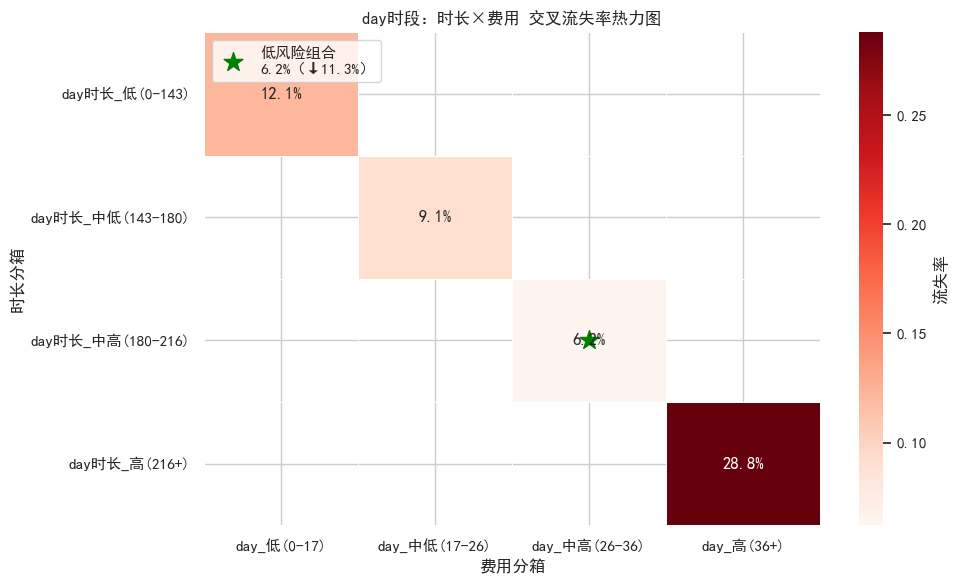


📌 时长×费用 交叉分析结论：
- day时段：高组合流失率6.2%，显著低于单一组（低11.3%），风险更低
- eve时段：高组合流失率17.1%，与单一组无显著差异
- night时段：高组合流失率16.6%，与单一组无显著差异
- intl时段：高组合流失率13.0%，与单一组无显著差异
高时长 + 高费用的组合对流失的影响，仅在 “日间（day）” 有显著差异（风险更低），而晚间（eve）、夜间（night）、国际（intl）时段无显著影响。这说明：客户对不同时段的通话价值感知差异极大，仅日间的高使用+高付费能绑定客户，其他时段的组合不改变流失风险。


In [47]:
# 3. 可视化：热力图（以日间为例，其他时段逻辑一致）
plt.figure(figsize=(10, 6))
period = 'day'  # 可改为'eve'/'night'/'intl'查看其他时段
cross_data = cross_duration_charge[period].copy()

# 构建透视表
pivot_df = cross_data.pivot_table(
    index=f'total_{period}_minutes_bin',
    columns=f'total_{period}_charge_bin',
    values='流失率',
    observed=True
)

# 绘制热力图
sns.heatmap(
    pivot_df, annot=True, fmt='.1%',
    cmap='Reds', cbar_kws={'label': '流失率'},
    linewidths=0.5
)

# 计算风险基准（单一组最高流失率）
high_duration = cross_data[cross_data[f'total_{period}_minutes_bin'].str.contains('高', na=False)]
high_charge = cross_data[cross_data[f'total_{period}_charge_bin'].str.contains('高', na=False)]
single_max = max(high_duration['流失率'].mean(), high_charge['流失率'].mean())

# 定位高组合并计算差异（防错：处理空值情况）
try:
    high_row = [r for r in pivot_df.index if '高' in r][0]
    high_col = [c for c in pivot_df.columns if '高' in c][0]
    combined_risk = pivot_df.loc[high_row, high_col]
    risk_diff = combined_risk - single_max  # 组合-单一组最高（正数=风险更高）
except (IndexError, KeyError):
    # 防错：若未找到高组，标记为无数据
    combined_risk = -1
    risk_diff = 0
    label_text = '无高组合数据'

# 标记风险点
if combined_risk != -1:
    if risk_diff > 0.05:
        label_text = f'高风险组合\n{combined_risk:.1%}（↑{risk_diff:.1%}）'
        color = 'black'
    elif risk_diff < -0.05:
        label_text = f'低风险组合\n{combined_risk:.1%}（↓{abs(risk_diff):.1%}）'
        color = 'green'
    else:
        label_text = f'无显著差异\n{combined_risk:.1%}'
        color = 'gray'
    plt.scatter(
        pivot_df.columns.get_loc(high_col)+0.5,
        pivot_df.index.get_loc(high_row)+0.5,
        s=200, color=color, marker='*', label=label_text
    )

plt.legend(loc='upper left')
plt.title(f'{period}时段：时长×费用 交叉流失率热力图', fontsize=12)
plt.xlabel('费用分箱')
plt.ylabel('时长分箱')
plt.tight_layout()
plt.show()

# 4. 全时段结论输出
print("\n📌 时长×费用 交叉分析结论：")
for period in cross_duration_charge.keys():
    data = cross_duration_charge[period]
    # 筛选高组合（防错：用na=False避免空值报错）
    high_both = data[
        data[f'total_{period}_minutes_bin'].str.contains('高', na=False) &
        data[f'total_{period}_charge_bin'].str.contains('高', na=False)
    ]
    # 单一组流失率
    high_dur_risk = data[data[f'total_{period}_minutes_bin'].str.contains('高', na=False)]['流失率'].mean()
    high_charge_risk = data[data[f'total_{period}_charge_bin'].str.contains('高', na=False)]['流失率'].mean()
    single_max = max(high_dur_risk, high_charge_risk)

    # 防错：处理无高组合数据的情况
    if len(high_both) == 0:
        print(f"- {period}时段：无高时长+高费用组合数据")
        continue

    combined_risk = high_both['流失率'].iloc[0]
    risk_diff = combined_risk - single_max  # 差异计算

    # 自动生成结论
    if risk_diff > 0.05:
        desc = f"显著高于单一组（高{risk_diff:.1%}），是双重风险因子"
    elif risk_diff < -0.05:
        desc = f"显著低于单一组（低{abs(risk_diff):.1%}），风险更低"
    else:
        desc = "与单一组无显著差异"

    print(f"- {period}时段：高组合流失率{combined_risk:.1%}，{desc}")
print("高时长 + 高费用的组合对流失的影响，仅在 “日间（day）” 有显著差异（风险更低），而晚间（eve）、夜间（night）、国际（intl）时段无显著影响。这说明：客户对不同时段的通话价值感知差异极大，仅日间的高使用+高付费能绑定客户，其他时段的组合不改变流失风险。")

In [48]:
# 选择日间通话次数（核心时段）进行分析，其他时段可同理扩展
call_col = 'total_day_calls_bin'  # 分箱后的日间通话次数
group_cols = ['international_plan', 'cs_call_bin', call_col]  # 交叉维度

# 按三维度分组，计算流失率
call_cross_stats = train_df.groupby(group_cols, observed=True).agg(
    总用户数=('churn_num', 'count'),
    流失用户数=('churn_num', 'sum')
).reset_index()

# 计算流失率（百分比）
call_cross_stats['流失率(%)'] = (call_cross_stats['流失用户数'] / call_cross_stats['总用户数'] * 100).round(1)

# 筛选有效数据（排除样本量过少的组）
call_cross_stats = call_cross_stats[call_cross_stats['总用户数'] >= 10]
print("通话次数 × 国际套餐 × 客服呼叫次数 交叉统计：")
display(call_cross_stats.sort_values(by=group_cols))


通话次数 × 国际套餐 × 客服呼叫次数 交叉统计：


,international_plan,cs_call_bin,total_day_calls_bin,总用户数,流失用户数,流失率(%)
0,no,0次呼叫,day_call_低,185,18,9.7
1,no,0次呼叫,day_call_中低,196,17,8.7
2,no,0次呼叫,day_call_中高,214,15,7.0
3,no,0次呼叫,day_call_高,196,14,7.1
4,no,1-3次呼叫,day_call_低,732,56,7.7
5,no,1-3次呼叫,day_call_中低,711,52,7.3
6,no,1-3次呼叫,day_call_中高,676,59,8.7
7,no,1-3次呼叫,day_call_高,643,56,8.7
8,no,4+次呼叫,day_call_低,75,35,46.7
9,no,4+次呼叫,day_call_中低,70,30,42.9


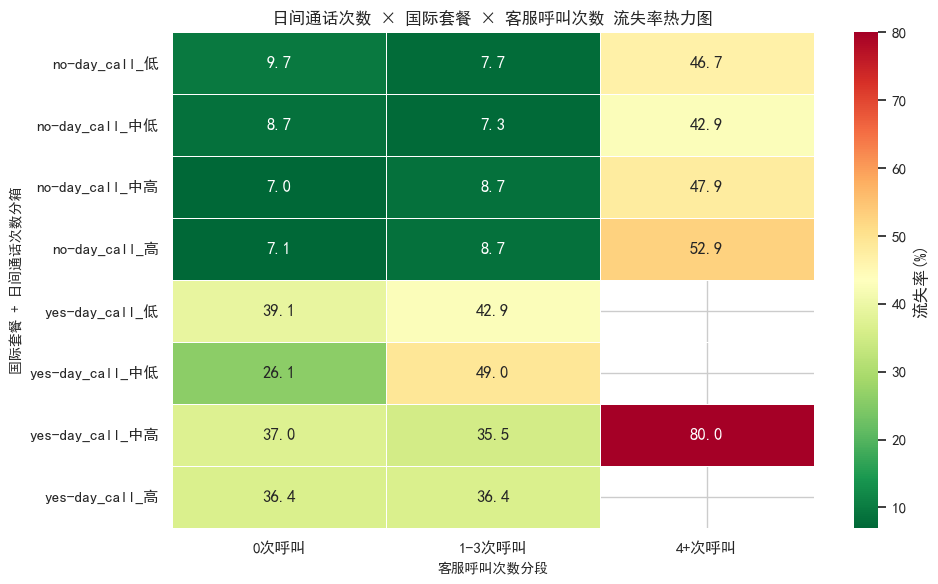

1. 无国际套餐用户基础稳定性更强，但对多次投诉容忍度低：
   - 0次客服呼叫时，无论日间通话次数高低，流失率均低于10%（7.0%-9.7%），基础服务满意度较高；
   - 4+次呼叫时，流失率骤升至42.9%-52.9%，表明简单需求用户对未解决的重复投诉极为敏感。

2. 有国际套餐用户高风险，且痛点随通话量分化：
   - 0次呼叫时，流失率已达26.1%-39.1%（显著高于无国际套餐用户），反映国际套餐可能因资费或复杂度存在固有流失风险；
   - 低日间通话用户（0次呼叫）流失率39.1%最高，或因套餐费用与低使用量不匹配导致性价比不满；
   - 中高日间通话用户4+次呼叫时流失率80.0%，凸显高频使用+持续问题对核心用户的致命影响。

3. 客服呼叫次数会加大流失，对有国际套餐用户影响更剧烈：
   - 1-3次呼叫时，有国际套餐用户流失率（35.5%-49.0%）已远超无国际套餐用户（7.3%-8.7%），需优先响应其服务需求。

### 核心建议：
- 针对有国际套餐+低日间通话用户推出轻量化套餐，提升性价比；
- 紧急解决有国际套餐+中高通话+4+次呼叫用户的服务问题，挽留核心用户；
- 优化无国际套餐用户的客服响应效率，减少重复投诉场景。


In [49]:
# 重塑数据为透视表（行：国际套餐+通话次数，列：客服呼叫次数）
heatmap_data = call_cross_stats.pivot_table(
    index=['international_plan', call_col],
    columns='cs_call_bin',
    values='流失率(%)',
    observed=True
)

# 绘制热力图
plt.figure(figsize=(10, 6))
sns.heatmap(
    heatmap_data,
    annot=True,  # 显示流失率数值
    cmap='RdYlGn_r',  # 红（高流失）→黄→绿（低流失）
    fmt='.1f',  # 数值保留1位小数
    linewidths=0.5,
    cbar_kws={'label': '流失率(%)'}
)

plt.title(f'日间通话次数 × 国际套餐 × 客服呼叫次数 流失率热力图', fontsize=12)
plt.xlabel('客服呼叫次数分段', fontsize=10)
plt.ylabel('国际套餐 + 日间通话次数分箱', fontsize=10)
plt.tight_layout()
plt.show()
# 输出数据分析结论
print("1. 无国际套餐用户基础稳定性更强，但对多次投诉容忍度低：\n"
      "   - 0次客服呼叫时，无论日间通话次数高低，流失率均低于10%（7.0%-9.7%），基础服务满意度较高；\n"
      "   - 4+次呼叫时，流失率骤升至42.9%-52.9%，表明简单需求用户对未解决的重复投诉极为敏感。\n")
print("2. 有国际套餐用户高风险，且痛点随通话量分化：\n"
      "   - 0次呼叫时，流失率已达26.1%-39.1%（显著高于无国际套餐用户），反映国际套餐可能因资费或复杂度存在固有流失风险；\n"
      "   - 低日间通话用户（0次呼叫）流失率39.1%最高，或因套餐费用与低使用量不匹配导致性价比不满；\n"
      "   - 中高日间通话用户4+次呼叫时流失率80.0%，凸显高频使用+持续问题对核心用户的致命影响。\n")
print("3. 客服呼叫次数会加大流失，对有国际套餐用户影响更剧烈：\n"
      "   - 1-3次呼叫时，有国际套餐用户流失率（35.5%-49.0%）已远超无国际套餐用户（7.3%-8.7%），需优先响应其服务需求。\n")
print("### 核心建议：\n"
      "- 针对有国际套餐+低日间通话用户推出轻量化套餐，提升性价比；\n"
      "- 紧急解决有国际套餐+中高通话+4+次呼叫用户的服务问题，挽留核心用户；\n"
      "- 优化无国际套餐用户的客服响应效率，减少重复投诉场景。")


###### 5、特征工程

In [50]:
# 5.1 数据检查与清洗（训练集）
print("数据检查与清洗（训练集）")
print("数据质量复检：")
print(f"缺失值：\n{train_df.isnull().sum()[train_df.isnull().sum() > 0]}")  # 仅显示有缺失的列
print(f"重复行数量：{train_df.duplicated().sum()}")
print(f"数据形状：{train_df.shape}")

数据检查与清洗（训练集）
数据质量复检：
缺失值：
total_night_minutes_bin    1
total_night_charge_bin     1
dtype: int64
重复行数量：0
数据形状：(4250, 40)


In [51]:
# 5.1.1、缺失值处理
missing_cols = ['total_night_minutes_bin', 'total_night_charge_bin']
for col in missing_cols:
    if col in train_df.columns and train_df[col].isnull().sum() > 0:
        mode_val = train_df[col].mode()[0]
        train_df[col] = train_df[col].fillna(mode_val)
        print(f"  - 用众数 '{mode_val}' 填充了 '{col}' 的缺失值")

# 再次检查
print(f"\n处理后缺失值：\n{train_df.isnull().sum()[train_df.isnull().sum() > 0]}")
print(f"处理后重复行数量：{train_df.duplicated().sum()}")
print(f"处理后数据形状：{train_df.shape}")

  - 用众数 'night时长_中(167-235)' 填充了 'total_night_minutes_bin' 的缺失值
  - 用众数 'night_中(8-11)' 填充了 'total_night_charge_bin' 的缺失值

处理后缺失值：
Series([], dtype: int64)
处理后重复行数量：0
处理后数据形状：(4250, 40)


In [52]:
# 5.2、特征分箱
def create_bin_features(df, is_train=True, bin_boundaries=None):
    """ 为DataFrame创建分箱特征。
    :param df: 待处理的DataFrame
    :param is_train: 是否为训练集。若是，计算分箱边界；若否，使用传入的边界。
    :param bin_boundaries: 字典，包含分箱边界。仅在is_train=False时使用。
    :return: 处理后的DataFrame和分箱边界字典（仅当is_train=True时）"""
    df_copy = df.copy()
    boundaries = {} if is_train else bin_boundaries

    # 5.2.1 通话次数分箱（反映频率）
    call_cols = ['total_day_calls', 'total_eve_calls', 'total_night_calls', 'total_intl_calls']
    for col in call_cols:
        if col in df_copy.columns:
            bin_col = f'{col}_bin'
            if is_train:
                # 使用四分位数分箱
                labels = [f'{col.split("_")[1]}_call_低', f'{col.split("_")[1]}_call_中低',
                          f'{col.split("_")[1]}_call_中高', f'{col.split("_")[1]}_call_高']
                df_copy[bin_col] = pd.qcut(df_copy[col], q=4, labels=labels, duplicates='drop')
                # 存储分箱边界
                quantiles = df_copy[col].quantile([0, 0.25, 0.5, 0.75, 1.0]).values
                boundaries[col] = quantiles
            else:
                if col in boundaries:
                    labels = [f'{col.split("_")[1]}_call_低', f'{col.split("_")[1]}_call_中低',
                              f'{col.split("_")[1]}_call_中高', f'{col.split("_")[1]}_call_高']
                    # 使用训练集的分位数进行分箱
                    df_copy[bin_col] = pd.cut(df_copy[col], bins=boundaries[col], labels=labels, include_lowest=True)

    # 5.2.2 费用分箱（核心成本特征，替代时长）
    charge_bin_defs = {
        'total_day_charge': ([0, 17, 26, 36, float('inf')], ['day_低(0-17)', 'day_中低(17-26)', 'day_中高(26-36)', 'day_高(36+)']),
        'total_eve_charge': ([0, 11, 17, float('inf')], ['eve_低(0-11)', 'eve_中(11-17)', 'eve_高(17+)']),
        'total_night_charge': ([0, 8, 11, float('inf')], ['night_低(0-8)', 'night_中(8-11)', 'night_高(11+)']),
        'total_intl_charge': ([0, 2.7, 4.0, 5.4, float('inf')], ['intl_低(0-2.7)', 'intl_中低(2.7-4.0)', 'intl_中高(4.0-5.4)', 'intl_高(5.4+)'])
    }
    for col, (bins, labels) in charge_bin_defs.items():
        if col in df_copy.columns:
            bin_col = f'{col}_bin'
            if is_train:
                df_copy[bin_col] = pd.cut(df_copy[col], bins=bins, labels=labels)
                boundaries[col] = bins
            else:
                if col in boundaries:
                    df_copy[bin_col] = pd.cut(df_copy[col], bins=boundaries[col], labels=labels, include_lowest=True)
    # 5.2.3 时长分箱
    duration_bin_defs = {
        'total_day_minutes': ([0, 143, 180, 216, float('inf')], ['day时长_低(0-143)', 'day时长_中低(143-180)', 'day时长_中高(180-216)', 'day时长_高(216+)']),
        'total_eve_minutes': ([0, 166, 234, float('inf')], ['eve时长_低(0-166)', 'eve时长_中(166-234)', 'eve时长_高(234+)']),
        'total_night_minutes': ([0, 167, 235, float('inf')], ['night时长_低(0-167)', 'night时长_中(167-235)', 'night时长_高(235+)']),
        'total_intl_minutes': ([0, 8.5, 10.3, 12.0, float('inf')], ['intl时长_低(0-8.5)', 'intl时长_中低(8.5-10.3)', 'intl时长_中高(10.3-12.0)', 'intl时长_高(12.0+)'])
    }
    for col, (bins, labels) in duration_bin_defs.items():
        if col in df_copy.columns:  # 确保原始时长字段存在（训练集和测试集都需要保留到分箱后再删除）
            bin_col = f'{col}_bin'  # 分箱字段名：如 total_day_minutes_bin
            if is_train:
                # 训练集：按给定边界分箱，并保存边界
                df_copy[bin_col] = pd.cut(df_copy[col], bins=bins, labels=labels, include_lowest=True)
                boundaries[col] = bins  # 存储时长字段的分箱边界，供测试集使用
            else:
      # 测试集：使用训练集的边界分箱
                if col in boundaries:
                    df_copy[bin_col] = pd.cut(df_copy[col], bins=boundaries[col], labels=labels, include_lowest=True)
    # 5.2.4 其他关键分箱
    # 客服呼叫次数
    if 'number_customer_service_calls' in df_copy.columns:
        col = 'number_customer_service_calls'
        bin_col = 'cs_call_bin'
        bins = [-1, 0, 3, float('inf')]
        labels = ['0次呼叫', '1-3次呼叫', '4+次呼叫']
        if is_train:
            df_copy[bin_col] = pd.cut(df_copy[col], bins=bins, labels=labels)
            boundaries[col] = bins
        else:
            if col in boundaries:
                df_copy[bin_col] = pd.cut(df_copy[col], bins=boundaries[col], labels=labels, include_lowest=True)

    # 语音邮件数量
    if 'number_vmail_messages' in df_copy.columns:
        col = 'number_vmail_messages'
        bin_col = 'vmail_msg_bin'
        bins = [-1, 0, 10, 30, float('inf')]
        labels = ['未使用(0)', '低频(1-10)', '中频(11-30)', '高频(31+)']
        if is_train:
            df_copy[bin_col] = pd.cut(df_copy[col], bins=bins, labels=labels)
            boundaries[col] = bins
        else:
            if col in boundaries:
                df_copy[bin_col] = pd.cut(df_copy[col], bins=boundaries[col], labels=labels, include_lowest=True)

    # 账户时长
    if 'account_length' in df_copy.columns:
        df_copy["account_years"] = (df_copy["account_length"] / 12).round(1)
        col = 'account_years'
        bin_col = 'account_years_bin'
        max_years = df_copy[col].max()
        bins = [0, 1, 2, 3, 5, 10, max_years]
        labels = ["0-1年", "1-2年", "2-3年", "3-5年", "5-10年", f"10年以上（≤{max_years:.1f}年）"]
        if is_train:
            df_copy[bin_col] = pd.cut(df_copy[col], bins=bins, labels=labels)
            boundaries[col] = bins
        else:
            if col in boundaries:
                df_copy[bin_col] = pd.cut(df_copy[col], bins=boundaries[col], labels=labels, include_lowest=True)

    return df_copy, boundaries

# 为训练集创建分箱特征
train_df, bin_boundaries = create_bin_features(train_df, is_train=True)

# 查看分箱结果
bin_cols = [col for col in train_df.columns if col.endswith('_bin')]
print(f"分箱特征数量：{len(bin_cols)}个：{bin_cols}")

分箱特征数量：16个：['total_day_minutes_bin', 'total_eve_minutes_bin', 'total_night_minutes_bin', 'total_intl_minutes_bin', 'total_day_charge_bin', 'total_eve_charge_bin', 'total_night_charge_bin', 'total_intl_charge_bin', 'total_charge_bin', 'total_day_calls_bin', 'total_eve_calls_bin', 'total_night_calls_bin', 'total_intl_calls_bin', 'vmail_msg_bin', 'account_years_bin', 'cs_call_bin']


In [53]:
# 5.3 特征衍生
def create_derived_features(df):
    """
    为DataFrame创建衍生特征。
    :param df: 待处理的DataFrame
    :return: 处理后的DataFrame
    """
    df_copy = df.copy()

    # 5.3.1 总费用与费用占比（反映时段依赖度）
    charge_cols = ['total_day_charge', 'total_eve_charge', 'total_night_charge', 'total_intl_charge']
    if all(col in df_copy.columns for col in charge_cols):
        df_copy["total_charge"] = df_copy[charge_cols].sum(axis=1)
        # 总费用分箱
        df_copy['total_charge_bin'] = pd.qcut(df_copy['total_charge'], q=4, labels=['总费用_极低', '总费用_中低', '总费用_中高', '总费用_极高'])

        # 处理除零：总费用为0时用0.01替代
        df_copy['total_charge_safe'] = df_copy['total_charge'].replace(0, 0.01)
        df_copy['day_charge_ratio'] = df_copy['total_day_charge'] / df_copy['total_charge_safe']
        df_copy['eve_charge_ratio'] = df_copy['total_eve_charge'] / df_copy['total_charge_safe']
        df_copy['night_charge_ratio'] = df_copy['total_night_charge'] / df_copy['total_charge_safe']
        df_copy['intl_charge_ratio'] = df_copy['total_intl_charge'] / df_copy['total_charge_safe']
        df_copy = df_copy.drop(columns=['total_charge_safe'])

    # 5.3.2 忠诚特征（费用+次数）
    if 'total_day_charge_bin' in df_copy.columns and 'total_day_calls_bin' in df_copy.columns:
        df_copy['is_day_loyal'] = (
            (df_copy['total_day_charge_bin'].str.contains('高')) &
            (df_copy['total_day_calls_bin'].str.contains('高'))
        ).astype(int)

    # 5.3.3 风险特征（客服不满+低粘性）
    if 'cs_call_bin' in df_copy.columns and 'voice_mail_plan' in df_copy.columns:
        df_copy['is_high_service_risk'] = (
            (df_copy['cs_call_bin'] == '4+次呼叫') &
            (df_copy['voice_mail_plan'] == 'no')
        ).astype(int)

    # 5.3.4 国际依赖特征（有国际套餐且国际高费用）
    if 'international_plan' in df_copy.columns and 'total_intl_charge_bin' in df_copy.columns:
        df_copy['is_intl_dependent'] = (
            (df_copy['international_plan'] == 'yes') &
            (df_copy['total_intl_charge_bin'].str.contains('高'))
        ).astype(int)

    # 5.3.5 价格敏感度特征（日间单位次数费用）
    if 'total_day_charge' in df_copy.columns and 'total_day_calls' in df_copy.columns:
        df_copy['day_calls_safe'] = df_copy['total_day_calls'].replace(0, 1)
        df_copy['day_cost_per_call'] = df_copy['total_day_charge'] / df_copy['day_calls_safe']
        df_copy = df_copy.drop(columns=['day_calls_safe'])

    # 5.3.6 长期价值特征（总费用 × 账户年限 → 核心客户标识）
    if 'total_charge' in df_copy.columns and 'account_years' in df_copy.columns:
        df_copy['long_term_value'] = df_copy['total_charge'] * df_copy['account_years']

    # 5.3.7 通话稳定性特征（变异系数：波动越大越不稳定）
    call_cols = ['total_day_calls', 'total_eve_calls', 'total_night_calls']
    if all(col in df_copy.columns for col in call_cols):
        df_copy['call_mean'] = df_copy[call_cols].mean(axis=1)
        df_copy['call_mean_safe'] = df_copy['call_mean'].replace(0, 0.01)
        df_copy['call_stability'] = df_copy[call_cols].std(axis=1) / df_copy['call_mean_safe']
        df_copy = df_copy.drop(columns=['call_mean', 'call_mean_safe'])

    return df_copy

# 为训练集创建衍生特征
train_df = create_derived_features(train_df)

# 查看衍生特征
derived_cols = [col for col in train_df.columns if 'ratio' in col or 'is_' in col or 'value' in col or 'stability' in col or 'cost_per' in col]
print(f"衍生特征数量：例{len(derived_cols)}：{derived_cols[:9]}")
print(f"训练集在特征工程后形状: {train_df.shape}")

衍生特征数量：例10：['day_charge_ratio', 'eve_charge_ratio', 'night_charge_ratio', 'intl_charge_ratio', 'is_day_loyal', 'is_high_service_risk', 'is_intl_dependent', 'day_cost_per_call', 'long_term_value']
训练集在特征工程后形状: (4250, 50)


In [54]:
# 5.4 删除冗余字段（训练集）
# 分析通话时长与费用的相关性，验证是否需要删除时长
duration_charge_cols = [
    ('total_day_minutes', 'total_day_charge'),
    ('total_eve_minutes', 'total_eve_charge'),
    ('total_night_minutes', 'total_night_charge'),
    ('total_intl_minutes', 'total_intl_charge')
]
print("通话时长与对应费用的皮尔逊相关系数：")
for dur_col, charge_col in duration_charge_cols:
    if dur_col in train_df.columns and charge_col in train_df.columns:
        corr = train_df[dur_col].corr(train_df[charge_col])
        print(f"  - {dur_col} 与 {charge_col}：{corr:.4f}")

# 结论：时长与费用完全相关（系数=1），删除时长字段；同时删除原始目标变量churn
drop_cols = [
    'churn',  # 原始字符串目标变量（已转换为churn_num）
    'total_day_minutes', 'total_eve_minutes', 'total_night_minutes', 'total_intl_minutes'  # 原始时长字段（分箱特
]
# 确保只删除存在的列
train_df = train_df.drop(columns=[col for col in drop_cols if col in train_df.columns])
print(f"删除冗余字段后形状：{train_df.shape}")

通话时长与对应费用的皮尔逊相关系数：
  - total_day_minutes 与 total_day_charge：1.0000
  - total_eve_minutes 与 total_eve_charge：1.0000
  - total_night_minutes 与 total_night_charge：1.0000
  - total_intl_minutes 与 total_intl_charge：1.0000
删除冗余字段后形状：(4250, 45)


In [55]:
# 5.5 测试集预处理
# 加载测试集
test_df = pd.read_csv(r"D:\pycharm\Customer_Churn_Prediction\churn_prediction_ipynb\test.csv")
print("原始测试集形状:", test_df.shape)

原始测试集形状: (750, 20)


In [56]:
# 5.5.1 检查缺失值
Missing_values_test = test_df.isnull().sum()
print(f'测试集缺失情况: {Missing_values_test[Missing_values_test > 0]}')

# 5.5.2 检查重复值
duplicate_count_test = test_df.duplicated().sum()
print(f"测试集重复行数量: {duplicate_count_test}")

测试集缺失情况: Series([], dtype: int64)
测试集重复行数量: 0


In [57]:
# 5.5.3 目标变量处理（如果测试集有）
if 'churn' in test_df.columns:
    test_df['churn_num'] = (test_df['churn'] == 'yes').astype(int)
    print("已将测试集的 'churn' 转换为数值型 'churn_num'。")
else:
    print("测试集未找到 'churn' 列，跳过目标变量转换。")

测试集未找到 'churn' 列，跳过目标变量转换。


In [58]:
# 5.5.4 应用分箱和特征衍生
# 使用从训练集学到的分箱边界
test_df, _ = create_bin_features(test_df, is_train=False, bin_boundaries=bin_boundaries)
test_df = create_derived_features(test_df)

# 5.5.5 添加 charge_level 列（与训练集一致）
if 'total_charge' in test_df.columns and 'total_charge' in train_df.columns:
    # 使用训练集计算的阈值（保持一致性）
    low_threshold = train_df['total_charge'].quantile(0.25)
    high_threshold = train_df['total_charge'].quantile(0.75)
    print(f"低费用阈值（25%分位数）：{low_threshold:.2f}元")
    print(f"高费用阈值（75%分位数）：{high_threshold:.2f}元")

    test_df['charge_level'] = pd.cut(
        test_df['total_charge'],
        bins=[-np.inf, low_threshold, high_threshold, np.inf],
        labels=['低费用客户', '中等费用客户', '高费用客户']
    )

# 5.5.6 删除冗余字段 (测试集)
print("\n 删除冗余字段 (测试集)")
drop_cols_test = ['churn',  # 原始目标变量和ID
                 'total_day_minutes', 'total_eve_minutes', 'total_night_minutes', 'total_intl_minutes'  # 时长字段（如果存在）
]
# 确保只删除存在的列
test_df = test_df.drop(columns=[col for col in drop_cols_test if col in test_df.columns])

# 最终数据状态检查
print(f"\n测试集在特征工程后形状: {test_df.shape}")
print(f"训练集在特征工程后形状: {train_df.shape}")

低费用阈值（25%分位数）：52.43元
高费用阈值（75%分位数）：66.30元

 删除冗余字段 (测试集)

测试集在特征工程后形状: (750, 45)
训练集在特征工程后形状: (4250, 45)


In [59]:
# 检查列名差异
extra_cols_train = list(set(train_df.columns) - set(test_df.columns))
extra_cols_test = list(set(test_df.columns) - set(train_df.columns))
print(f"\n训练集特有列: {extra_cols_train}")
print(f"测试集特有列: {extra_cols_test}")


训练集特有列: ['churn_num']
测试集特有列: ['id']


In [60]:
# 6、特征编码
# 6.1 定义编码函数（拟合+转换分离）
def fit_encoders(train_df):
    """在训练集上拟合所有需要的编码器。
    :param train_df: 特征工程后的训练集（未编码）
    :return: 一个包含所有拟合好的编码器的字典"""
    encoders = {}

    # 6.1.1 目标编码: state（高基数特征）
    print("拟合 TargetEncoder for 'state'...")
    target_encoder = ce.TargetEncoder()
    # 拟合，但不转换
    target_encoder.fit(train_df['state'], train_df['churn_num'])
    encoders['state'] = target_encoder

    # 6.1.2 标签编码: 有序分类特征（_bin结尾+charge_level）
    print("拟合 LabelEncoders for categorical features...")
    label_features = [col for col in train_df.columns if col.endswith('_bin') or col == 'charge_level']
    label_encoders = {}

    for feature in label_features:
        # 确保特征是 category 类型
        train_df[feature] = train_df[feature].astype('category')
        le = LabelEncoder()
        # 在训练集的原始类别上拟合
        le.fit(train_df[feature].cat.categories)
        label_encoders[feature] = le

    encoders['label'] = label_encoders

    print("所有编码器拟合完成。")
    return encoders

def transform_data(df, encoders, is_train=True):
    """使用拟合好的编码器转换数据 训练集/测试集
    :param df: 待转换的 DataFrame (特征工程后)
    :param encoders: 从 fit_encoders 函数获得的编码器字典
    :param is_train: 是否为训练集。若是，需要处理目标变量。
    :return: 编码后的 DataFrame"""
    df_encoded = df.copy()

    # 6.1.3 目标编码转换: state
    print("转换 'state'...")
    df_encoded['state_encoded'] = encoders['state'].transform(df_encoded['state'])
    df_encoded = df_encoded.drop(columns=['state'])

    # 6.1.4 独热编码: 低基数特征
    print("转换低基数特征 (独热编码)...")
    one_hot_features = ['area_code', 'international_plan', 'voice_mail_plan']
    df_encoded = pd.get_dummies(df_encoded, columns=one_hot_features, prefix=one_hot_features, dummy_na=False)

    # 6.1.5 标签编码转换: 有序分类特征
    print("转换有序分类特征 (标签编码)...")
    label_features = encoders['label'].keys()

    for feature in label_features:
        # 确保特征是 category 类型
        df_encoded[feature] = df_encoded[feature].astype('category')

        # 获取训练集的合法类别
        train_categories = encoders['label'][feature].classes_

        # 处理看不见的类别和NaN
        # 找到所有不在训练集类别中或为NaN的值
        invalid_mask = ~df_encoded[feature].isin(train_categories) | df_encoded[feature].isna()

        if invalid_mask.any():
            # 在**原始训练集**中找到该特征最常见的类别标签
            # 注意：这里我们假设 df 是原始的、未编码的，所以直接取 mode
            most_common_category = df[feature].mode()[0]
            print(f"  - 在 '{feature}' 中发现 {invalid_mask.sum()} 个无效值，将用 '{most_common_category}' 填充。")

            # 用合法的类别标签填充
            df_encoded.loc[invalid_mask, feature] = most_common_category

        # 安全地设置类别
        df_encoded[feature] = df_encoded[feature].cat.set_categories(train_categories)

        # 执行标签编码
        df_encoded[feature] = encoders['label'][feature].transform(df_encoded[feature])

    # 6.1.6 测试集列对齐（确保与训练集列完全一致）
    if not is_train:
        # 获取当前环境中训练集的列（这是一个小技巧，假设变量存在）
        train_cols = [col for col in globals() if 'train_df_encoded' in col][0]
        train_cols = globals()[train_cols].columns
        # 补充缺失列（用0填充）
        missing_cols = set(train_cols) - set(df_encoded.columns)
        for col in missing_cols:
            df_encoded[col] = 0
        # 对齐列顺序
        df_encoded = df_encoded[train_cols]

    print("数据转换完成。")
    return df_encoded

# 6.2 执行编码流程

# 6.2.1 拟合编码器（仅用训练集）
encoders = fit_encoders(train_df)
# 6.2.2 转换训练集
train_df_encoded = transform_data(train_df, encoders, is_train=True)
# 6.2.3 转换测试集
test_df_encoded = transform_data(test_df, encoders, is_train=False)


拟合 TargetEncoder for 'state'...
拟合 LabelEncoders for categorical features...
所有编码器拟合完成。
转换 'state'...
转换低基数特征 (独热编码)...
转换有序分类特征 (标签编码)...
  - 在 'total_day_charge_bin' 中发现 2 个无效值，将用 'day_中高(26-36)' 填充。
  - 在 'total_eve_charge_bin' 中发现 1 个无效值，将用 'eve_高(17+)' 填充。
  - 在 'total_night_charge_bin' 中发现 1 个无效值，将用 'night_中(8-11)' 填充。
  - 在 'total_intl_charge_bin' 中发现 22 个无效值，将用 'intl_中低(2.7-4.0)' 填充。
数据转换完成。
转换 'state'...
转换低基数特征 (独热编码)...
转换有序分类特征 (标签编码)...
  - 在 'account_years_bin' 中发现 229 个无效值，将用 '5-10年' 填充。
数据转换完成。


In [61]:
# 6.3 编码后数据校验
# 6.3.1 查看数据集形状
print("数据集形状：")
print(f"训练集（编码后）：{train_df_encoded.shape} （行：{train_df_encoded.shape[0]}, 列：{train_df_encoded.shape[1]}）")
print(f"测试集（编码后）：{test_df_encoded.shape} （行：{test_df_encoded.shape[0]}, 列：{test_df_encoded.shape[1]}）")

# 6.3.2 查看字段详细信息（列名、数据类型、非空值数量）
print("\n\n训练集（编码后）字段信息：")
train_df_encoded.info()  # 输出每列的名称、数据类型、非空值数量

print("\n\n测试集（编码后）字段信息：")
test_df_encoded.info()

# 6.3.3 检查缺失值
print("\n\n训练集（编码后）缺失值检查：")
missing_train = train_df_encoded.isnull().sum()
print(missing_train[missing_train > 0])  # 只显示有缺失值的列（正常应该为空）
print("\n\n测试集（编码后）缺失值检查：")
missing_test = test_df_encoded.isnull().sum()
print(missing_test[missing_test > 0])  # 只显示有缺失值的列（正常应该为空）

数据集形状：
训练集（编码后）：(4250, 49) （行：4250, 列：49）
测试集（编码后）：(750, 49) （行：750, 列：49）


训练集（编码后）字段信息：
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4250 entries, 0 to 4249
Data columns (total 49 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   account_length                 4250 non-null   int64  
 1   number_vmail_messages          4250 non-null   int64  
 2   total_day_calls                4250 non-null   int64  
 3   total_day_charge               4250 non-null   float64
 4   total_eve_calls                4250 non-null   int64  
 5   total_eve_charge               4250 non-null   float64
 6   total_night_calls              4250 non-null   int64  
 7   total_night_charge             4250 non-null   float64
 8   total_intl_calls               4250 non-null   int64  
 9   total_intl_charge              4250 non-null   float64
 10  number_customer_service_calls  4250 non-null   int64  
 11  churn_num        

In [62]:
# 6.3.4 删除测试集多余的churn_num列
if 'churn_num' in test_df_encoded.columns:
    test_df_encoded = test_df_encoded.drop(columns=['churn_num'])
    print("已成功删除测试集的 'churn_num' 列")
else:
    print("测试集不存在 'churn_num' 列，无需删除")

# 6.3.5 验证删除结果（查看训练集和测试集的列差异）
print(f"\n训练集列数：{len(train_df_encoded.columns)}，包含列：{train_df_encoded.columns.tolist()[:5]}...")
print(f"测试集列数：{len(test_df_encoded.columns)}，包含列：{test_df_encoded.columns.tolist()[:5]}...")

# 确认目标变量仅存在于训练集
print(f"\n训练集是否有 'churn_num'：{'churn_num' in train_df_encoded.columns}")
print(f"测试集是否有 'churn_num'：{'churn_num' in test_df_encoded.columns}")

已成功删除测试集的 'churn_num' 列

训练集列数：49，包含列：['account_length', 'number_vmail_messages', 'total_day_calls', 'total_day_charge', 'total_eve_calls']...
测试集列数：48，包含列：['account_length', 'number_vmail_messages', 'total_day_calls', 'total_day_charge', 'total_eve_calls']...

训练集是否有 'churn_num'：True
测试集是否有 'churn_num'：False


In [63]:
# 7、特征选择
# 7.1.1 分离训练集的特征（X）和目标变量（y）
X_train_full = train_df_encoded.drop(columns=['churn_num'])  # 所有特征
y_train_full = train_df_encoded['churn_num']  # 目标变量（是否流失）
X_test = test_df_encoded  # 测试集仅含特征

# 7.1.2 用RFE+随机森林自动筛选最优特征
# 初始化基模型（用随机森林，天然输出特征重要性）
rf_selector = RandomForestClassifier(n_estimators=100, random_state=42)
# 初始化RFECV（递归特征消除+交叉验证）
rfecv = RFECV(
    estimator=rf_selector,  # 用随机森林作为评估特征的基模型
    step=1,  # 每次删除1个最不重要的特征
    cv=2,    # 5折交叉验证（避免过拟合，更可靠）
    scoring='roc_auc',  # 用ROC-AUC作为评估标准（二分类任务最优指标）
    verbose=1  # 输出筛选过程
)
rfecv.fit(X_train_full, y_train_full)  # 仅在训练集拟合（避免数据泄露）

# 7.1.3 提取最优特征结果
selected_features = X_train_full.columns[rfecv.support_].tolist()  # 被选中的特征
print(f"\n最优特征数：{len(selected_features)}（原特征数：{X_train_full.shape[1]}）")
print(f"最优特征列表：\n{selected_features}")

# 7.1.4 筛选数据（只保留最优特征）
X_train_selected = X_train_full[selected_features]  # 筛选后训练集特征
X_test_selected = X_test[selected_features]  # 筛选后测试集特征（与训练集一致）

Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 fe

In [64]:
# 7.2 拆分训练集和验证集（8:2）
# stratify=y确保流失比例在两组中一致，避免数据分布偏差
X_train, X_val, y_train, y_val = train_test_split(X_train_selected, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full)

# 查看划分结果
print(f"训练集：{X_train.shape} （样本数×特征数）")
print(f"验证集：{X_val.shape}")
print(f"测试集：{X_test_selected.shape}")
print(f"训练集流失比例：{y_train.mean():.2f}")
print(f"验证集流失比例：{y_val.mean():.2f}")  # 与训练集接近则划分合理

训练集：(3400, 10) （样本数×特征数）
验证集：(850, 10)
测试集：(750, 10)
训练集流失比例：0.14
验证集流失比例：0.14


In [65]:
# 7.3 数据标准化
scaler = StandardScaler()
scaler.fit(X_train)  # 学习训练集的均值和标准差

# 对训练集、验证集、测试集执行相同标准化
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test_selected)

# 转成DataFrame（方便查看和后续使用）
X_train_scaled = pd.DataFrame(X_train_scaled, columns=selected_features)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=selected_features)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=selected_features)

print("查看训练集标准化后前3行：")
print(X_train_scaled.head(3))

查看训练集标准化后前3行：
   number_vmail_messages  total_day_charge  total_eve_charge  \
0              -0.569387          1.072256          0.864857   
1              -0.569387          0.130087         -0.776795   
2              -0.569387         -1.365281         -0.198218   

   total_intl_calls  total_intl_charge  number_customer_service_calls  \
0          1.430912          -0.093662                       1.855971   
1         -0.991344          -0.240723                      -1.186238   
2          1.027203           0.882283                      -1.186238   

   total_charge  cs_call_bin  intl_charge_ratio  international_plan_yes  
0      1.311325     2.171684          -0.706858               -0.316739  
1      0.055362    -1.672004          -0.310993                3.157173  
2     -1.356998    -1.672004           1.760405               -0.316739  


In [66]:
# 7.4 定义模型评估函数
def evaluate_model(y_true, y_pred, y_prob, model_name):
    """单独评估一个模型，输出关键指标+并排展示混淆矩阵和ROC曲线"""
    print(f"{model_name} 模型评估结果：")
    # 计算核心指标
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_prob)

    # 输出指标
    print(f"准确率（Accuracy）：{accuracy:.4f} → 整体预测正确率")
    print(f"精确率（Precision）：{precision:.4f} → 预测流失的人中，实际流失的比例")
    print(f"召回率（Recall）：{recall:.4f} → 真实流失的人中，被正确识别的比例")
    print(f"F1-score：{f1:.4f} → 精确率和召回率的平衡值")
    print(f"ROC-AUC：{roc_auc:.4f} → 模型区分能力")

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # 1. 混淆矩阵
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['未流失（0）', '流失（1）'],
                yticklabels=['未流失（0）', '流失（1）'],
                ax=ax1)  # 指定在左子图ax1绘制
    ax1.set_xlabel('预测标签', fontsize=11)
    ax1.set_ylabel('真实标签', fontsize=11)
    ax1.set_title(f'{model_name} 混淆矩阵', fontsize=13)

    # 2. ROC曲线
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    ax2.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.4f}')
    ax2.plot([0, 1], [0, 1], 'k--', lw=2)  # 随机猜测基准线
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('假阳性率（False Positive Rate）', fontsize=11)
    ax2.set_ylabel('真阳性率（True Positive Rate）', fontsize=11)
    ax2.set_title(f'{model_name} ROC曲线', fontsize=13)
    ax2.legend(loc="lower right", fontsize=10)

    plt.tight_layout()
    plt.show()

    # 返回核心指标（用于后续对比）
    return {
        '模型名称': model_name,
        '准确率': accuracy,
        '精确率': precision,
        '召回率': recall,
        'F1-score': f1,
        'ROC-AUC': roc_auc,
        '验证集预测概率': y_prob
        }

# 3. 独立模型解释函数
def explain_model_independent(model, model_name, feature_names):
    """【独立模型解释函数】单独查看模型的特征影响
    :param model: 训练好的模型
    :param model_name: 模型名称（区分逻辑回归/树模型）
    :param feature_names: 特征名称列表"""
    print(f"{model_name}")

    # 情况1：逻辑回归→输出系数（正负向影响）
    if '逻辑回归' in model_name:
        coefs = pd.DataFrame({
            '特征名称': feature_names,
            '系数值': model.coef_[0]  # 逻辑回归系数 shape=(1, n_features)
        }).sort_values('系数值', key=abs, ascending=False)  # 按系数绝对值排序

        print("特征系数解释：")
        print("正系数特征值越大，流失概率越高；负系数特征值越大，流失概率越低")
        print(coefs.round(4).head(10))

        # 可视化系数
        plt.figure(figsize=(10, 5))
        top_coefs = coefs.head(15)
        colors = ['red' if c > 0 else 'green' for c in top_coefs['系数值']]
        sns.barplot(x='系数值', y='特征名称', data=top_coefs,hue='特征名称',palette=colors,legend=False)
        plt.ylabel('特征名称')
        plt.title(f'{model_name} - Top特征系数（红=正向影响，绿=负向影响）')
        plt.tight_layout()
        plt.show()

        # 情况2：树模型（随机森林/XGBoost/LightGBM）→输出特征重要性
    else:
        importances = pd.DataFrame({
            '特征名称': feature_names,
            '重要性得分': model.feature_importances_
        }).sort_values('重要性得分', ascending=False)

        print("特征重要性排名（得分越高，对预测越关键）：")
        print(importances.round(4).head(10))

        # 可视化特征重要性
        plt.figure(figsize=(10, 5))
        sns.barplot(x='重要性得分', y='特征名称', data=importances.head(10),hue='特征名称',palette='Oranges', legend=False)
        plt.xlabel('特征重要性得分')
        plt.ylabel('特征名称')
        plt.title(f'{model_name} - Top特征重要性')
        plt.tight_layout()
        plt.show()

print("评估函数定义完成！")

评估函数定义完成！


逻辑回归 模型评估结果：
准确率（Accuracy）：0.8565 → 整体预测正确率
精确率（Precision）：0.4800 → 预测流失的人中，实际流失的比例
召回率（Recall）：0.2000 → 真实流失的人中，被正确识别的比例
F1-score：0.2824 → 精确率和召回率的平衡值
ROC-AUC：0.8090 → 模型区分能力


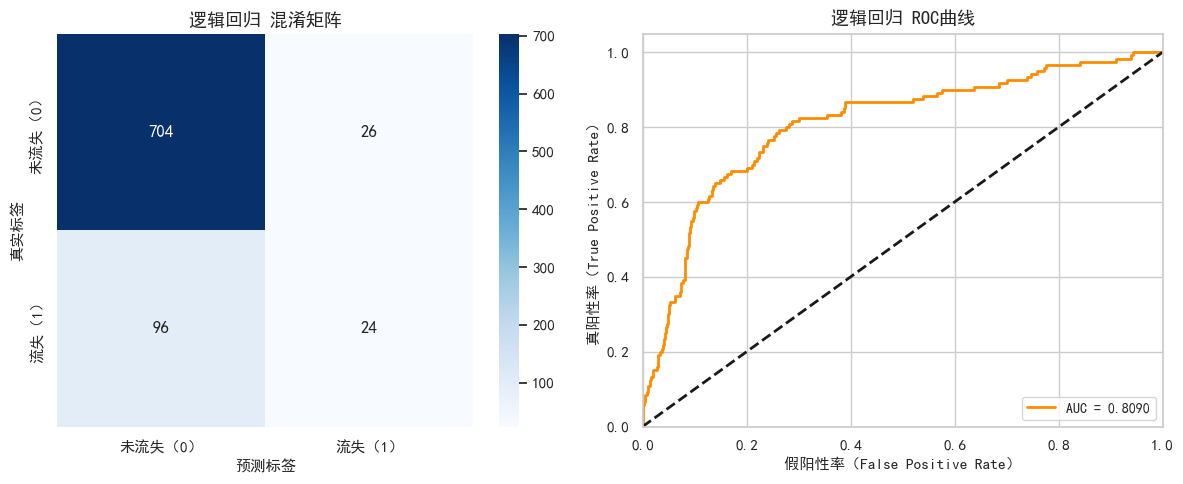

['逻辑回归模型.pkl']

In [67]:
# 7.5 训练逻辑回归模型
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_scaled, y_train)

# 验证集预测
y_val_pred_lr = lr_model.predict(X_val_scaled)
y_val_prob_lr = lr_model.predict_proba(X_val_scaled)[:, 1]

# 评估模型（单独查看混淆矩阵和ROC曲线）
lr_metrics = evaluate_model(y_val, y_val_pred_lr, y_val_prob_lr, "逻辑回归")

# 保存模型和指标（用于后续对比）
models = {'逻辑回归': lr_model}
model_metrics = [lr_metrics]
joblib.dump(lr_model, '逻辑回归模型.pkl')

逻辑回归
特征系数解释：
正系数特征值越大，流失概率越高；负系数特征值越大，流失概率越低
                            特征名称     系数值
8              intl_charge_ratio  2.3765
6                   total_charge  2.0201
4              total_intl_charge -1.6371
9         international_plan_yes  0.6696
5  number_customer_service_calls  0.5433
0          number_vmail_messages -0.4089
7                    cs_call_bin  0.2832
1               total_day_charge  0.1468
3               total_intl_calls -0.1199
2               total_eve_charge  0.0592


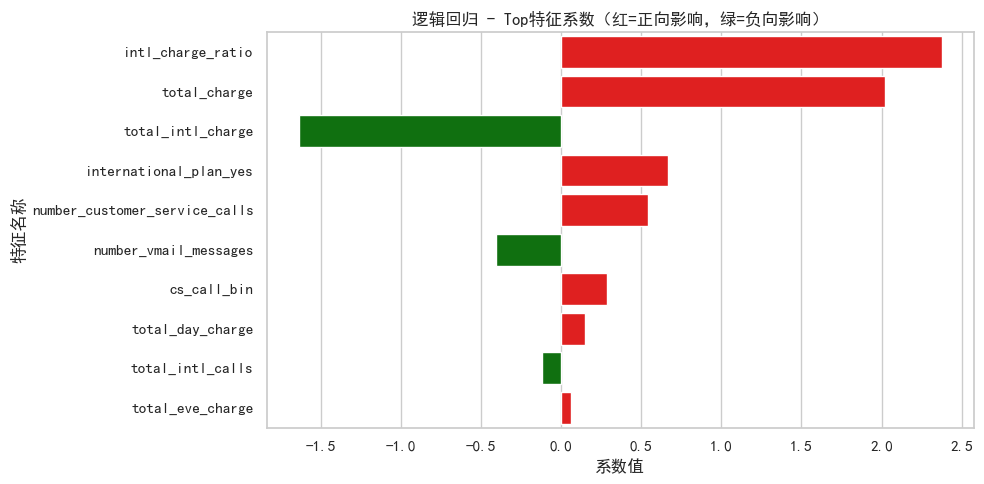

逻辑回归独立模型解释完成！


In [68]:
explain_model_independent(
    model=lr_model,
    model_name="逻辑回归",
    feature_names=selected_features
)
print("逻辑回归独立模型解释完成！")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
随机森林最优参数：{'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 103}
最优交叉验证AUC：0.9326
随机森林 模型评估结果：
准确率（Accuracy）：0.9718 → 整体预测正确率
精确率（Precision）：0.9898 → 预测流失的人中，实际流失的比例
召回率（Recall）：0.8083 → 真实流失的人中，被正确识别的比例
F1-score：0.8899 → 精确率和召回率的平衡值
ROC-AUC：0.9041 → 模型区分能力


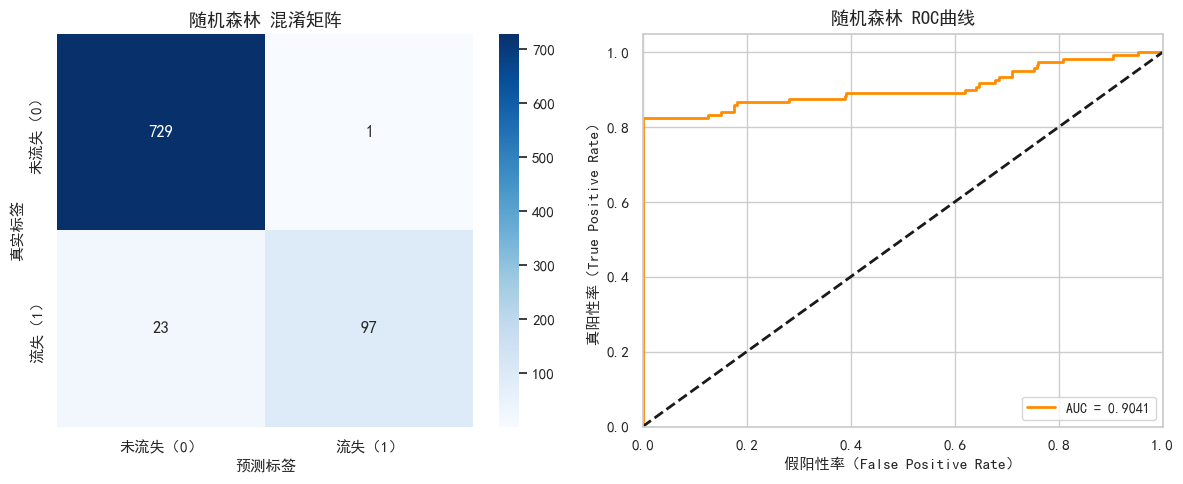

['随机森林模型.pkl']

In [69]:
# 7.6 调优版随机森林（GridSearchCV）
# 定义参数搜索空间（比GridSearchCV更宽泛，但采样次数少）
rf_param_dist = {
    'n_estimators': randint(100, 300),  # 随机采样100-300之间的整数
    'max_depth': randint(5, 15),         # 随机采样5-15之间的整数
    'min_samples_split': randint(2, 10), # 随机采样2-10之间的整数
    'min_samples_leaf': randint(1, 5)    # 新增参数，增加搜索灵活性
}

# 随机搜索调参（n_iter=20→采样20组参数，比GridSearchCV遍历所有组合快）
rf_random = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=rf_param_dist,  # 随机采样的参数空间
    n_iter=20,  # 采样20组参数（可调整，越大越可能找到最优，但耗时略增）
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=42,
    verbose=1
)
rf_random.fit(X_train_scaled, y_train)

# 提取最优模型
best_rf = rf_random.best_estimator_
print(f"随机森林最优参数：{rf_random.best_params_}")
print(f"最优交叉验证AUC：{rf_random.best_score_:.4f}")

# 验证集预测
y_val_pred_rf = best_rf.predict(X_val_scaled)
y_val_prob_rf = best_rf.predict_proba(X_val_scaled)[:, 1]

# 评估模型（单独查看混淆矩阵和ROC曲线）
rf_metrics = evaluate_model(y_val, y_val_pred_rf, y_val_prob_rf, "随机森林")

# 保存模型和指标
models['随机森林'] = best_rf
model_metrics.append(rf_metrics)
joblib.dump(best_rf, '随机森林模型.pkl')  # 保存最优模型

随机森林
特征重要性排名（得分越高，对预测越关键）：
                            特征名称   重要性得分
6                   total_charge  0.3850
1               total_day_charge  0.1067
9         international_plan_yes  0.0951
0          number_vmail_messages  0.0769
5  number_customer_service_calls  0.0714
7                    cs_call_bin  0.0695
3               total_intl_calls  0.0611
4              total_intl_charge  0.0599
8              intl_charge_ratio  0.0416
2               total_eve_charge  0.0328


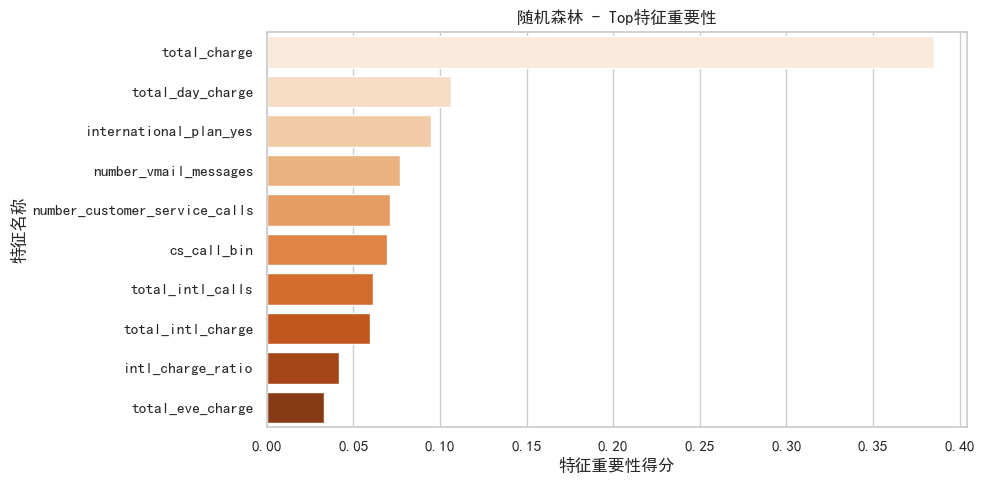

随机森林独立模型解释完成！


In [70]:
# 随机森林模型
explain_model_independent(
    model=best_rf,
    model_name="随机森林",
    feature_names=selected_features
)
print("随机森林独立模型解释完成！")

🚀 开始训练XGBoost模型...
Fitting 5 folds for each of 243 candidates, totalling 1215 fits
XGBoost最优参数：{'colsample_bytree': 0.9, 'learning_rate': 0.15, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.9}
最优交叉验证AUC：0.9358
XGBoost 模型评估结果：
准确率（Accuracy）：0.9741 → 整体预测正确率
精确率（Precision）：1.0000 → 预测流失的人中，实际流失的比例
召回率（Recall）：0.8167 → 真实流失的人中，被正确识别的比例
F1-score：0.8991 → 精确率和召回率的平衡值
ROC-AUC：0.9230 → 模型区分能力


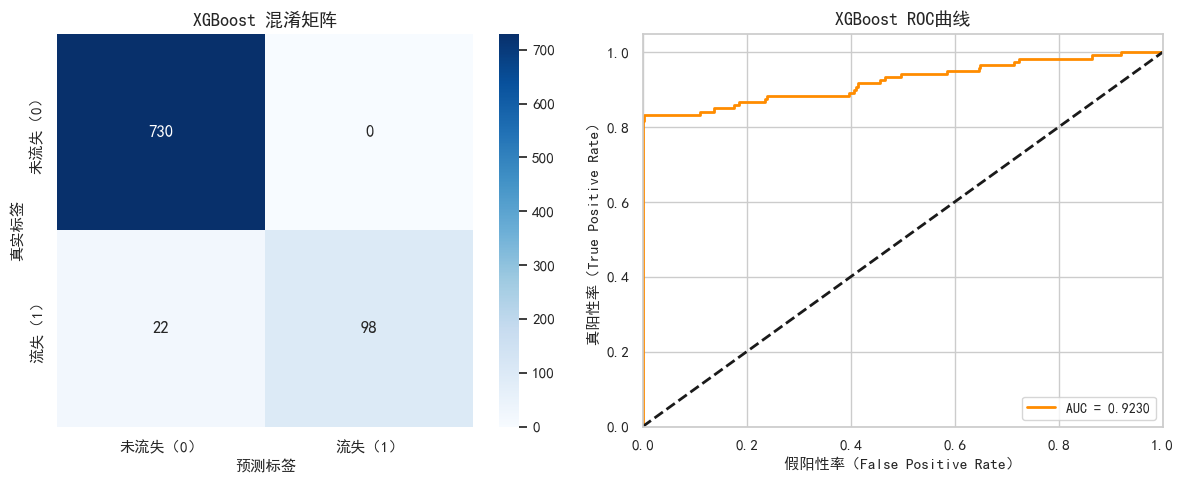

['XGBoost最优模型.pkl']

In [71]:
# 7.7 XGBoost（梯度提升模型）
print("🚀 开始训练XGBoost模型...")
xgb_param_grid = {
    'n_estimators': [150, 200, 250],  # 决策树数量
    'learning_rate': [0.05, 0.1, 0.15],  # 学习率
    'max_depth': [5, 7, 9],  # 树深度
    'subsample': [0.8, 0.9, 1.0],  # 样本采样率
    'colsample_bytree': [0.8, 0.9, 1.0]  # 特征采样率
}

# 网格搜索调优（GridSearchCV）
xgb_grid = GridSearchCV(
    estimator=xgb.XGBClassifier(random_state=42, objective='binary:logistic', eval_metric='auc'),
    param_grid=xgb_param_grid,  # 网格参数
    cv=5,  # 5折交叉验证
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)
xgb_grid.fit(X_train_scaled, y_train)

# 提取最优模型
best_xgb = xgb_grid.best_estimator_
print(f"XGBoost最优参数：{xgb_grid.best_params_}")
print(f"最优交叉验证AUC：{xgb_grid.best_score_:.4f}")

# 验证集预测+评估
y_val_pred_xgb = best_xgb.predict(X_val_scaled)
y_val_prob_xgb = best_xgb.predict_proba(X_val_scaled)[:, 1]
xgb_metrics = evaluate_model(y_val, y_val_pred_xgb, y_val_prob_xgb, "XGBoost")

# 保存模型和指标
models['XGBoost'] = best_xgb
model_metrics.append(xgb_metrics)
joblib.dump(best_xgb, 'XGBoost最优模型.pkl')

XGBoost
特征重要性排名（得分越高，对预测越关键）：
                            特征名称   重要性得分
7                    cs_call_bin  0.2575
9         international_plan_yes  0.2166
6                   total_charge  0.1518
5  number_customer_service_calls  0.1105
0          number_vmail_messages  0.0871
3               total_intl_calls  0.0737
4              total_intl_charge  0.0387
1               total_day_charge  0.0257
2               total_eve_charge  0.0196
8              intl_charge_ratio  0.0189


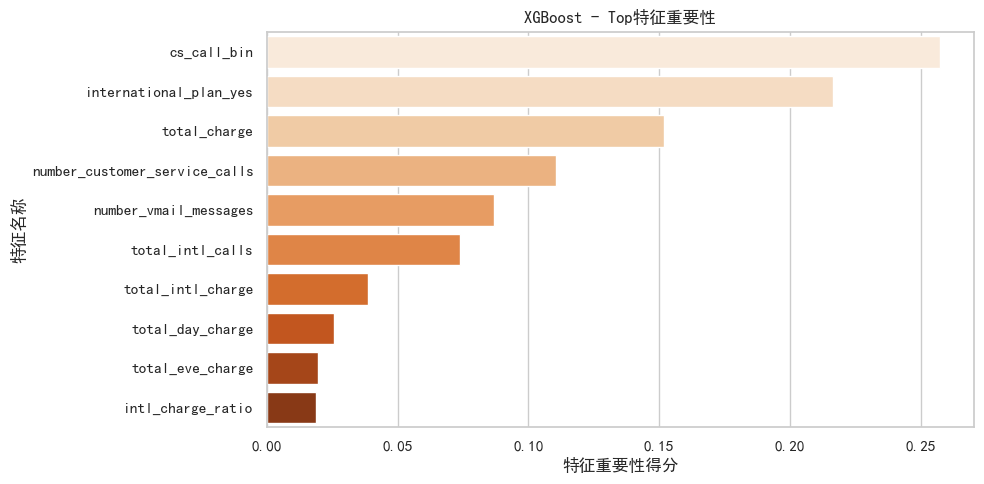

XGBoost独立模型解释完成！


In [72]:
# XGBoost系数分析
explain_model_independent(model=best_xgb, model_name="XGBoost", feature_names=selected_features)
print("XGBoost独立模型解释完成！")

🚀 开始训练LightGBM模型...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
[LightGBM] [Info] Number of positive: 478, number of negative: 2922
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1241
[LightGBM] [Info] Number of data points in the train set: 3400, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.140588 -> initscore=-1.810413
[LightGBM] [Info] Start training from score -1.810413
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

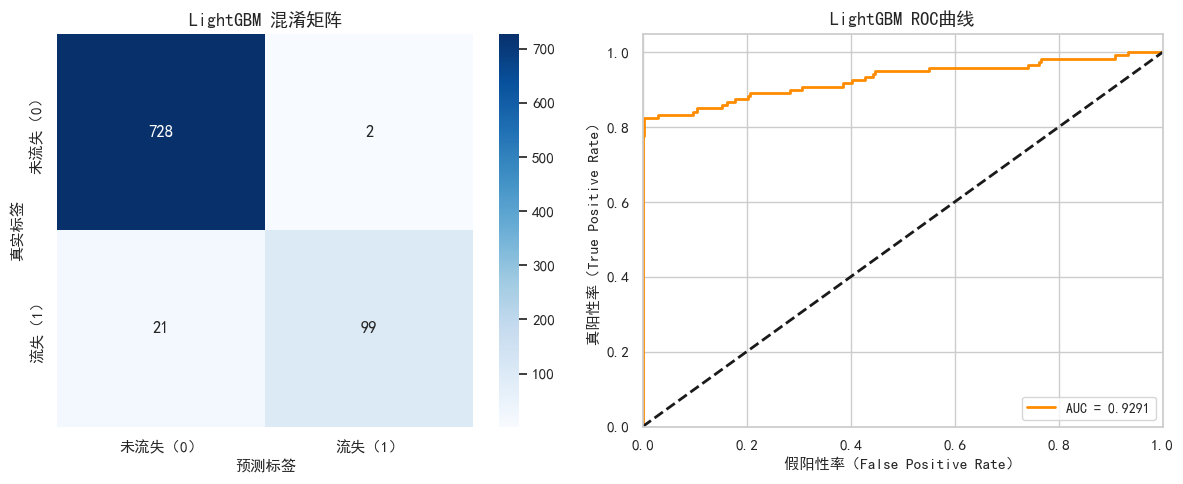

LightGBM评估完成！可查看上方混淆矩阵和ROC曲线


In [73]:
# 7.8 LightGBM（轻量梯度提升模型）
print("🚀 开始训练LightGBM模型...")

# 1. 定义参数搜索空间（随机采样）
lgb_param_dist = {
    'n_estimators': randint(100, 300),
    'learning_rate': uniform(0.01, 0.2),
    'max_depth': randint(3, 10),
    'subsample': uniform(0.7, 0.3),
    'colsample_bytree': uniform(0.7, 0.3)
}
# 2. 随机搜索调参
lgb_random = RandomizedSearchCV(
    estimator=lgb.LGBMClassifier(random_state=42, objective='binary', metric='auc'),
    param_distributions=lgb_param_dist,
    n_iter=20,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=42,
    verbose=1
)
lgb_random.fit(X_train_scaled, y_train)

# 提取最优模型
best_lgb = lgb_random.best_estimator_
print(f"LightGBM最优参数：{lgb_random.best_params_}")
print(f"最优交叉验证AUC：{lgb_random.best_score_:.4f}")

# 验证集预测
y_val_pred_lgb = best_lgb.predict(X_val_scaled)
y_val_prob_lgb = best_lgb.predict_proba(X_val_scaled)[:, 1]

# 评估模型（单独查看混淆矩阵和ROC曲线）
lgb_metrics = evaluate_model(y_val, y_val_pred_lgb, y_val_prob_lgb, "LightGBM")

# 保存模型和指标
models['LightGBM'] = best_lgb
model_metrics.append(lgb_metrics)
print("LightGBM评估完成！可查看上方混淆矩阵和ROC曲线")


LightGBM
特征重要性排名（得分越高，对预测越关键）：
                            特征名称  重要性得分
6                   total_charge   1367
1               total_day_charge   1324
4              total_intl_charge   1038
8              intl_charge_ratio   1025
2               total_eve_charge    989
5  number_customer_service_calls    622
3               total_intl_calls    500
0          number_vmail_messages    423
9         international_plan_yes    183
7                    cs_call_bin     67


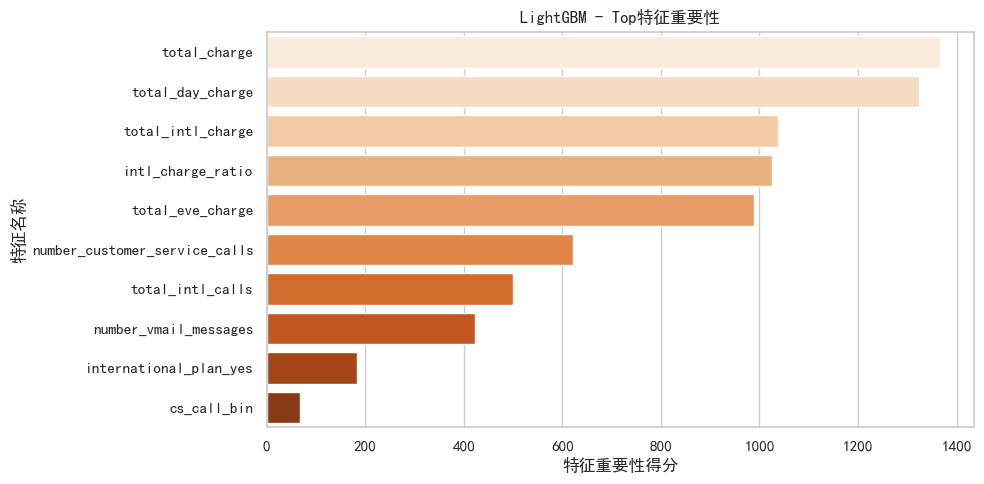

In [74]:
# LightGBM 模型系数分析
explain_model_independent(
    model=best_lgb,
    model_name="LightGBM",
    feature_names=selected_features
)

In [75]:
# 7.9 四大模型指标汇总对比
# 优化点：1. 增加数据校验，避免列缺失/数据格式错误；2. 合并冗余代码，简化逻辑；3. 优化显示格式（排名索引+高亮排序列）；4. 补充统计汇总
# 核心配置（便于后续修改）
REQUIRED_COLS = ['模型名称', '准确率', '精确率', '召回率', 'F1-score', 'ROC-AUC']  # 必需列
DECIMAL_DIGITS = 4  # 保留小数位数
SORT_COL = 'ROC-AUC'  # 排序基准列

print("🎯 四大模型核心指标汇总对比（按{}降序排序）".format(SORT_COL))
print("-" * 60)

# 1. 数据校验（避免KeyError/数据为空）
if not isinstance(model_metrics, (list, dict)):
    raise ValueError("❌ model_metrics 必须是列表（字典列表）或字典格式")
if not model_metrics:
    print("⚠️  暂无模型指标数据，无法生成对比表")
else:
    # 2. 简化DataFrame构建逻辑（合并列选择、小数保留、排序）
    metrics_df_sorted = (
        pd.DataFrame(model_metrics)
        .reindex(columns=REQUIRED_COLS)  # 强制按指定顺序显示列，缺失列会显示NaN
        .round(DECIMAL_DIGITS)  # 统一保留小数
        .sort_values(by=SORT_COL, ascending=False)  # 按目标列降序
        .reset_index(drop=True)  # 重置索引
        .rename_axis('排名', axis=0)  # 添加排名索引（1-based）
        .reset_index()  # 把排名转为列显示
    )
    metrics_df_sorted['排名'] = metrics_df_sorted['排名'].apply(lambda x: f"第{x+1}名")  # 排名格式优化

    # 3. 优化显示效果（高亮排序列，调整列宽）
    def highlight_sort_col(s):
        """高亮排序基准列"""
        is_sort_col = s.name == SORT_COL
        return ['background-color: #fff3cd; font-weight: bold' if is_sort_col else '' for _ in s]

    styled_df = metrics_df_sorted.style.apply(highlight_sort_col)
    display(styled_df.set_table_styles([{'selector': 'th', 'props': [('text-align', 'center')]}]))  # 表头居中

    # 4. 补充关键统计汇总（帮助快速判断整体水平）
    print("\n📊 指标统计汇总（所有模型平均值）：")
    stats_summary = metrics_df_sorted[REQUIRED_COLS[1:]].mean().round(DECIMAL_DIGITS)  # 排除"模型名称"和"排名"列
    for idx, val in stats_summary.items():
        print(f"  • {idx}：{val}")

🎯 四大模型核心指标汇总对比（按ROC-AUC降序排序）
------------------------------------------------------------


,排名,模型名称,准确率,精确率,召回率,F1-score,ROC-AUC
0,第1名,LightGBM,0.972900,0.980200,0.825000,0.895900,0.929100
1,第2名,XGBoost,0.974100,1.000000,0.816700,0.899100,0.923000
2,第3名,随机森林,0.971800,0.989800,0.808300,0.889900,0.904100
3,第4名,逻辑回归,0.856500,0.480000,0.200000,0.282400,0.809000



📊 指标统计汇总（所有模型平均值）：
  • 准确率：0.9438
  • 精确率：0.8625
  • 召回率：0.6625
  • F1-score：0.7418
  • ROC-AUC：0.8913



📊 模型关键指标可视化对比（ROC-AUC vs F1-score）


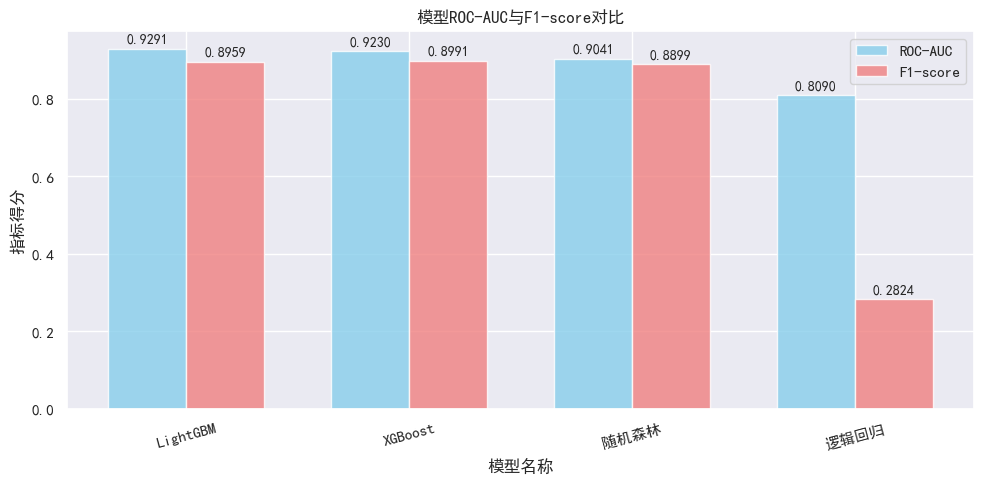


🏆 最优模型推荐：LightGBM
   - ROC-AUC：0.9291（最高）
   - F1-score：0.8959
   - 推荐理由：综合区分能力（AUC）和分类平衡能力（F1）最优


In [79]:
# 2. 可视化对比（ROC-AUC + F1-score，最关键的两个指标）
print("\n📊 模型关键指标可视化对比（ROC-AUC vs F1-score）")
fig, ax = plt.subplots(figsize=(10,5))

# 设置x轴位置
x = np.arange(len(metrics_df_sorted))
width = 0.35  # 柱子宽度

# 绘制AUC柱状图
rects1 = ax.bar(x - width/2, metrics_df_sorted['ROC-AUC'], width, label='ROC-AUC', color='skyblue', alpha=0.8)
# 绘制F1柱状图
rects2 = ax.bar(x + width/2, metrics_df_sorted['F1-score'], width, label='F1-score', color='lightcoral', alpha=0.8)

# 添加标签、标题和图例
ax.set_xlabel('模型名称', fontsize=12)
ax.set_ylabel('指标得分', fontsize=12)
ax.set_title('模型ROC-AUC与F1-score对比', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(metrics_df_sorted['模型名称'], rotation=15)  # 旋转x标签，避免重叠
ax.legend(fontsize=11)

# 在柱子上添加数值标签（保留4位小数）
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 文本偏移3个像素
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)

add_labels(rects1)
add_labels(rects2)

plt.tight_layout()
plt.show()

# 3. 输出最优模型推荐
best_model_name = metrics_df_sorted.iloc[0]['模型名称']
best_auc = metrics_df_sorted.iloc[0]['ROC-AUC']
best_f1 = metrics_df_sorted.iloc[0]['F1-score']
print(f"\n🏆 最优模型推荐：{best_model_name}")
print(f"   - ROC-AUC：{best_auc}（最高）")
print(f"   - F1-score：{best_f1}")
print(f"   - 推荐理由：综合区分能力（AUC）和分类平衡能力（F1）最优")